In [2]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))
 
# %matplotlib inline

import os
import sys
import platform
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
from flopy.export.shapefile_utils import shp2recarray
from rasterio import Affine
from flopy.utils.reference import SpatialReference
from flopy.utils.postprocessing import get_transmissivities, get_water_table, get_gradients

import shapefile    # not used directly here but for some reason flopy needs this to do shapefile stuff and BTW its not import pyshp as you would think its import shapefile, dumb...
import pandas as pd
import fiona
from rasterio.features import rasterize
import rasterio
import rasterio.mask
import geopandas
from osgeo import gdal

#import simplekml
import ogr
from shapely.wkb import loads

from scipy.interpolate import interp2d
import scipy.optimize as opt


print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

#Set name of MODFLOW exe
#  assumes executable is in users path statement
exe_name = 'mf2005'
if platform.system() == 'Windows':
    exe_name = 'mf2005.exe'

workspace = os.path.join('Flo_py_wrkspace2')
#make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)
    
figurespace = os.path.join(workspace, "Figures")
if not os.path.exists(figurespace):
    os.makedirs(figurespace)
    
WGS84UTM2S_string = 'PROJCS["WGS_1984_UTM_Zone_2S",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-171],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]'
pd.set_option('display.max_rows', 75)

# define the spatial reference object 
model_epsg = 32702   # epsg code specifying coordinate reference system: in this case, UTM zone 2S, WGS 84, A proj4 string has also been fetched from <spatialreference.org> using the supplied epsg code.

# in line plotting and saving options. Change these to plot or not to plot inline
Plotnsave_plot = True
Plotnsave_save = True

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 16:38:51) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.18.1
matplotlib version: 3.1.3
flopy version: 3.3.0


# Model geometry notes


model boundaries square at 
X	Y
- 530200	8425825
- 537700	8425825
- 537700	8418325
- 530200	8418325

with length of 7500 m on both sides


next steps 
- try and just follow existing github model notebook 

Shapefile Boundaries: (530200.0, 8418325.0, 537700.0000000009, 8425825.000000002)
wrote Flo_py_wrkspace2\Model_polyarea.shp
wrote Flo_py_wrkspace2\Model_grid.shp


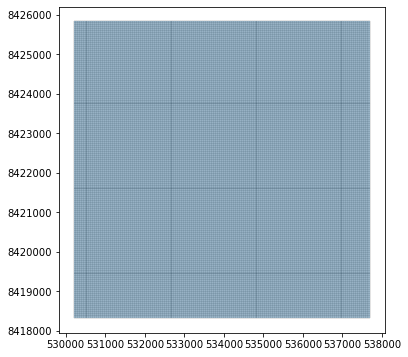

In [3]:
''' Define the number of layers, rows and columns.'''

ncol = 150
nrow = 150
nlay = 1

# model run times
nper = 1                     # Number of model stress periods (the default is 1)
perlen = [3650]              # An array of the stress period lengths in days separated by commas
nstp = [1]      # Number of time steps in each stress period (default is 1).
save_head = [3650]
steady = True
rotation = 0                             # rotation (positive counterclockwise)

# this cell inports the boundary shapefile to make the model around
ra = shp2recarray(os.path.join("..", "Data/Raw/GIS", 'model_square.shp'))
# these are the bondaries of the shapefile
shp_xmin = round(ra.geometry[0].bounds[0],1)
shp_ymin = round(ra.geometry[0].bounds[1],1)
shp_xmax = round(ra.geometry[0].bounds[2],1)
shp_ymax = round(ra.geometry[0].bounds[3],1)
print("Shapefile Boundaries: {}".format(ra.geometry[0].bounds))  

xll = int(shp_xmin)  # Lower left corner of model grid  
yll = int(shp_ymin)   # Lower left corner of model grid 


# grid spacing as a percentage of model x domain (in model units) note 10% buffer around boundary
delr = abs(int((shp_xmax-shp_xmin)/ncol))   # the width of each cell
delc = abs(int((shp_ymax-shp_ymin)/nrow))   # the height of eech cell
delr_4_sr  = np.ones(ncol, dtype=float) * delr    # This just puts the above into an array for the sr object 
delc_4_sr = np.ones(nrow, dtype=float) * delc   

# create the model boundary area polygon
sr = SpatialReference(delr=[delr_4_sr.sum()], delc=[delc_4_sr.sum()], xll=xll, yll=yll, rotation=rotation, proj4_str=WGS84UTM2S_string, lenuni=2) #  # model length units (1 for feet, 2 for meters (default)) (also calculeted uper left corner of model) 
sr.write_shapefile(os.path.join(workspace, 'Model_polyarea.shp'))          # write a shapefile of the model area for later use
prj = open(os.path.join(workspace, 'Model_polyarea.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()     # write the .prj file manually
#print("corners are at {}".format(sr.get_extent()))

# create the model boundary grid polygon   (NOTE THIS MUST OVERWRITE THe PREVIOUS sr. definition!)
sr = SpatialReference(delr=delr_4_sr, delc=delc_4_sr, xll=xll, yll=yll, rotation=rotation, proj4_str= '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs' , lenuni=2) #  # model length units (1 for feet, 2 for meters (default)) (also calculeted uper left corner of model) 
sr.write_shapefile(os.path.join(workspace, 'Model_grid.shp'))          # write a shapefile of the model grid for later use
prj = open(os.path.join(workspace, 'Model_grid.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()   # write the .prj file manually

# output control parameters
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}    

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize=(12,6))
    Tutuila = geopandas.read_file(os.path.join("..", "Data/Raw/GIS", 'model_square.shp'))
    Grid = geopandas.read_file(os.path.join(workspace, 'Model_grid.shp'))
    Grid.plot(ax=ax, facecolor="white", edgecolor="Black", linewidth=.2)
    Tutuila.plot(ax=ax, linewidth=2, alpha = .3)

### Assign Layer elevations from a DEM

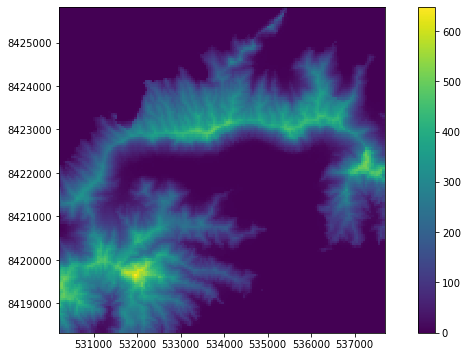

In [4]:
#Set model top to DEM
# Needed to clip the raster to appropriate dimensions, () https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html)
Raster_2_Clip = os.path.join("..",  'Data/Raw/GIS/3m_DEM', '3m_dem_cp.tif')
Clipped_raster = os.path.join(workspace, "DEM_10m_clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features,
                                                        crop=True)
out_meta = src.meta.copy()

out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(Clipped_raster, "w", **out_meta) as dest:
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
Top_raw = np.loadtxt(Clipped_raster, skiprows=7)   # the 7th row was a no data row for some reason not sure why, if another DEM is used might need to skiprows back to 6

y = np.linspace(0, np.shape(Top_raw)[0]-1, np.shape(Top_raw)[0])   
x = np.linspace(0, np.shape(Top_raw)[1]-1, np.shape(Top_raw)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, Top_raw, kind='cubic')
top = f(x2, y2)

botm = -500    # this will clearly need to change to accomadate the Tutuila bathymetry
top = np.where(top <= botm, botm+10, top) # force top elevations to always be higher than bottom elevations

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(top, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

Starting heads will be tricky.  Easiest might be to assign starting heads of 0.01 in ocean, then heads of 10 m less than top elevation in land surface areas, if optimization yields different starting heads then can modify. could also use the ending heads from the regional model. 


overall, I bound needs to be 

### starting heads

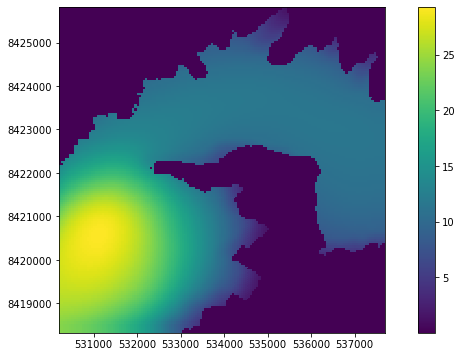

In [5]:
## First import regional heads from the regional model

Raster_2_Clip = os.path.join("..",  'Data/From_regional', 'PyPCGA_model_Heads_Clip.tif')
Clipped_raster = os.path.join(workspace, "PyPCGA_model_Heads_Clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features,
                                                        crop=True)
out_meta = src.meta.copy()

out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(Clipped_raster, "w", **out_meta) as dest:
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
Top_raw = np.loadtxt(Clipped_raster, skiprows=7)   # the 7th row was a no data row for some reason not sure why, if another DEM is used might need to skiprows back to 6

y = np.linspace(0, np.shape(Top_raw)[0]-1, np.shape(Top_raw)[0])   
x = np.linspace(0, np.shape(Top_raw)[1]-1, np.shape(Top_raw)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, Top_raw, kind='cubic')
regional_Heads = f(x2, y2)

#botm = -500    # this will clearly need to change to accomadate the Tutuila bathymetry
#top = np.where(top <= botm, botm+10, top) # force top elevations to always be higher than bottom elevations


# then explicitly say that the ocean area has a specified head, since the regional heads are fuzzy

with fiona.open(os.path.join("..",  'Data/Raw/GIS/ibounds/For_heads', 'Land_Ocean.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['OceanCell'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
mask = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

masked_heads = abs(regional_Heads)*mask                        # set ocean cells to a negative number through multoplication with -1
Ocean_starting_head = 0.01   # in meters 
start_heads = np.where(masked_heads < 0, Ocean_starting_head, masked_heads) # Set ocean cells (defined as any negative values in the array) to Ocean_starting_head value

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(start_heads, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### make new ibound and specified head 
- Negative ibound (-1) is constant head
- Ibound of (0) is inactive
- Any positive Ibound (1) is variable head (active) 

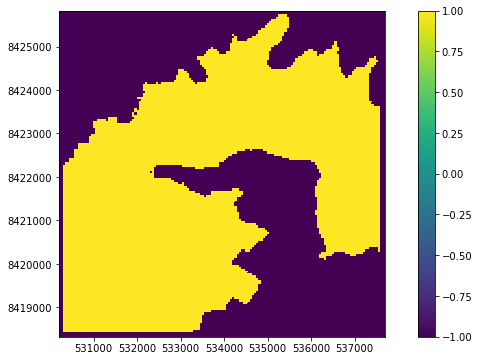

In [6]:
#### Use a Tutuila polygon to define the model active area as the island and the ghb cells as the offshore cells

with fiona.open(os.path.join("..",  'Data/Raw/GIS/ibounds', 'ibound_specHd_w_100m_buff.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['ibound'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
ibound = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(ibound, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### Observation points

note need to cut out obs that are not within the model domain

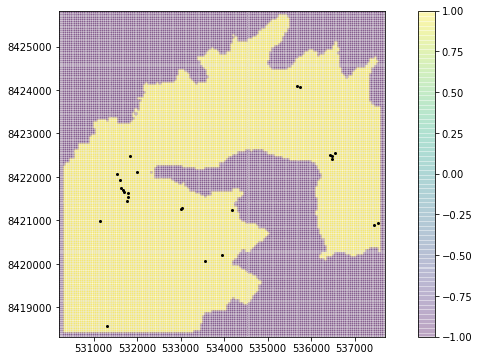

In [8]:
Pdevel_WLs = pd.read_csv(os.path.join("..",  'Data/Raw/Water_levels', 'Predevelop_WLs_MOD_vai183.csv'))

# Cut out observations that are outside of the model square (dont need the y's but could add those too for shoots and giggls
Pdevel_WLs = Pdevel_WLs[Pdevel_WLs['x_utm'] > shp_xmin]
Pdevel_WLs = Pdevel_WLs[Pdevel_WLs['x_utm'] < shp_xmax]

Pdevel_WLs['row_num'] = Pdevel_WLs['x_utm'].apply(lambda x_utm_val: math.ceil((x_utm_val-xll)/delr) )          # this formula calculates the column number based on the x coordinate 
Pdevel_WLs['col_num'] = Pdevel_WLs['y_utm'].apply(lambda y_utm_val: (1+nrow)-math.ceil((y_utm_val-yll)/delc) )   # this formula calculates the row number based on the y coordinate 
Pdevel_WLs['rowcol']  = list(zip(Pdevel_WLs.row_num, Pdevel_WLs.col_num))                                      # just make a tuplel of the row and col

# This takes obs wells that occupy the same cell and averages them! 
Unique_WLs = Pdevel_WLs.groupby('rowcol', as_index=False).mean()                                               # Average the duplicate WLs that fall into a single cell, to get one "observed" water level for that cell 

# make new unique names for each obs point
Unique_WLs["name"] = "Obs_"+Unique_WLs.index.map(str)

nobs = len(Unique_WLs['WL_m_MSL']) 
layervals = [0] * nobs
rowvals = list(Unique_WLs['col_num'].astype(int))
colvals = list(Unique_WLs['row_num'].astype(int))
obsvals = list(Unique_WLs['WL_m_MSL'])
obsnames = list(Unique_WLs["name"])

if Plotnsave_plot: 
    gdf = geopandas.GeoDataFrame(Unique_WLs, geometry=geopandas.points_from_xy(Unique_WLs.x_utm, Unique_WLs.y_utm))
    fig, ax = plt.subplots(figsize = (12,6))
    Grid.plot(ax=ax, facecolor="white", edgecolor="Black", linewidth=.2, alpha = .2)
    qm = sr.plot_array(ibound, ax=ax, alpha = .2)
    ax.set_aspect(1); plt.colorbar(qm)
    gdf.plot(ax=ax, color='black', markersize=4)

### Import Recharge .asc from SWB output into MODFLOW rech array
(note I am not sure what happens when the model area is bigger then the raster....)

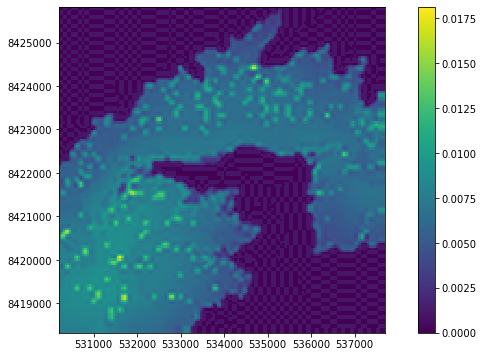

In [9]:
SWB_output_recharge = os.path.join("..",  'Data/Raw/GIS/Recharge','recharge_v1.asc')  

# Needed to clip the raster to appropriate dimensions, () https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html)   
Raster_2_Clip = os.path.join(SWB_output_recharge)
Clipped_raster = os.path.join(workspace, "raw_net_infiltration_clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    
out_meta = src.meta.copy()
out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(Clipped_raster, "w", **out_meta) as dest:          # create the new clipped .asc file
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
recharge_raw_SWB = np.loadtxt(Clipped_raster, skiprows=6)

y = np.linspace(0, np.shape(recharge_raw_SWB)[0]-1, np.shape(recharge_raw_SWB)[0])   
x = np.linspace(0, np.shape(recharge_raw_SWB)[1]-1, np.shape(recharge_raw_SWB)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, recharge_raw_SWB, kind='cubic')
recharge_resampled = f(x2, y2)
recharge_converted =  recharge_resampled* (0.0254/365)   # recharge comes out of SWB in inches/year and needs to be converted to m/day

recharge_converted = np.where(recharge_converted < 0, 0.001, recharge_converted)   # Interpolation made some negative values, fix that issue by setting them to a positive value

rch_data = {0: recharge_converted}   # dictionary form to specify that it is only on first layer

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(recharge_converted, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### Hydraulic condictivty assigned based on zones as defined by shapefiles in a folder

The values at the top of this cell can be modified to change the conductivity in each zone

In [10]:
# Function to rasterize the HK zones: 
def rastah_zone(shp):
    with fiona.open(shp) as src:   #    read in Tutuila shapefile
            records = [r for r in src]   
    geoms = [r['geometry'] for r in records]       # shapefile shape
    attr = [r['properties'] for r in records]      # shapefile attributes
    geoms = [(g, attr[i]['par_code']) for i, g in enumerate(geoms)]              # select the attribute to map onto the raster grid
    # affine: work with the geometry to change from raster to grid reference frame 
    trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
    Outrastah = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 
    return Outrastah

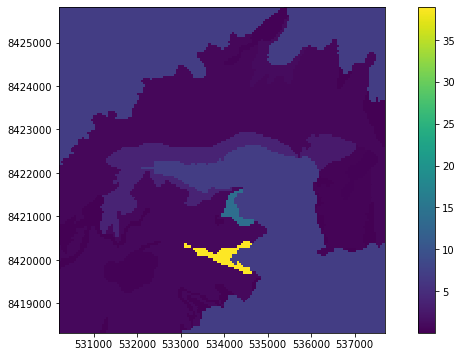

In [81]:
# set the  values this cell is set up for optimization
HK_raster = rastah_zone(os.path.join("..",  'Data/Raw/GIS/Geo_units/v1', 'NPS_simplified_geo_v1.shp'))

## Initial starting point before 3-4 rounds of calibration  was calgood = [ 5, 5, 5, 5, 5, 5, 0.2, .2, .2, .4, 0.5]
calgood =  [2.6, 39, 0.001, 14, 3.7, 1.2, 0.001, 0.37, 0.9, 0.7, 0.3]

#calgood = [ 5, 5, 5, 5, 5, 5, 0.2, .2, .2, .4, 0.5]

Alluvium_Aua      = calgood[0]
Alluvium_Fagaalu  = calgood[1]
Alluvium_minor    = calgood[2]
Alluvium_Utulei   = calgood[3]
Alluvium_Vaipito  = calgood[4]
Alluvium_Vatia    = calgood[5]
Dikes             = calgood[6]
Pago_inner_E      = calgood[7]
Pago_inner_W      = calgood[8]
Pago_outer        = calgood[9]
Trachyte          = calgood[10]


map_dic = {-12:Alluvium_Aua, 
           -14:Alluvium_Fagaalu, 
           -15:Alluvium_minor,
           -13:Alluvium_Utulei,
           -11:Alluvium_Vaipito,
           -10:Alluvium_Vatia,
           -50:Dikes,
           -30:Pago_inner_E,
           -40:Pago_inner_W,
           -20:Pago_outer,
           -60:Trachyte}

for i in map_dic:
    HK_raster = np.where(HK_raster== i, map_dic[i], HK_raster)
    
HK_raster = np.where(HK_raster== 0, 7, HK_raster)   # this is for the areas not covered by HK zones, Should not actually maatter at all!

#HK_raster = np.where(HK_raster== -90, 1, HK_raster) # this is for the areas that get messed up somehow
#HK_raster = np.where(HK_raster== -70, 1, HK_raster) # this is for the areas that get messed up somehow

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(HK_raster, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

'''Define the layers to be confined and define the horizontal and vertical 
hydraulic conductivity of the aquifer for the LPF package.'''

# lpf data
laytyp = 0
vka = 10


In [82]:
modelname = 'modelface'

ml = flopy.modflow.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace, verbose=False)

discret = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                                   delr=delr, delc=delc, top=top, botm=botm,
                                   nper=nper, perlen=perlen, nstp=nstp)
bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=start_heads)
lpf = flopy.modflow.ModflowLpf(ml, laytyp=laytyp, hk=HK_raster, vka=vka)
#### ghb = flopy.modflow.ModflowGhb(ml, stress_period_data=ghb_data)
rch = flopy.modflow.ModflowRch(ml, rech=rch_data)

oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd)
pcg = flopy.modflow.ModflowPcg(ml, hclose=1.0e-6, rclose=3.0e-3, mxiter=100, iter1=50)


# water level observations
obs_data= []
for i in range(0,nobs):
    obs = flopy.modflow.HeadObservation(ml, obsname=obsnames[i], layer=layervals[i], row=rowvals[i], column=colvals[i], time_series_data=[[0,obsvals[i]]])
    obs_data.append(obs)
hob = flopy.modflow.ModflowHob(ml, iuhobsv = 7, hobdry=-999, obs_data = obs_data)

# Run model 

if needed: #### Model checker
https://notebook.community/brclark-usgs/flopy/examples/Notebooks/flopy3_ModelCheckerExample
- ml.check()

In [83]:
ml.write_input()
ml.run_model(silent=False)

FloPy is using the following  executable to run the model: .\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: modelface.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/09/07  6:54:30

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2021/09/07  6:54:30
 Elapsed run time:  0.162 Seconds

  Normal termination of simulation


(True, [])

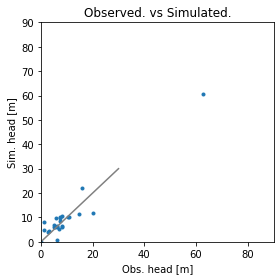

Mean Error: 0.45
Mean Absolute Error: 2.48
RMS Error: 3.28


In [84]:
# plot observations 
observations = np.loadtxt(os.path.join(workspace, '{}.hob.out'.format(modelname)), skiprows=1, usecols=[0,1])      # this block extracts observation data at each well field and determines what the maximum residual at any of the given points is
comp_obs = np.ravel(np.split(observations, 2, 1)[0]) # the computed hed values at the obspts
obs_obs = np.ravel(np.split(observations, 2, 1)[1]) # the observed hed values at the obspts

# note positive residuals means model is calculating too high negative is model calculates too low 
residuals = []
for idx, i in enumerate(observations):   
    r = observations[idx][0]-observations[idx][1]
    residuals.append(r)

Howd_we_do = pd.DataFrame({"Obs_hed_m":obs_obs,"Comp_hed_m":comp_obs,"Residual_m":residuals})

fig = plt.figure(figsize=(4,4))
plt.title('Observed. vs Simulated.')
plt.plot(Howd_we_do["Obs_hed_m"], Howd_we_do["Comp_hed_m"], '.')
#plt.axis('equal')
#plt.axis('square')
plt.xlabel("Obs. head [m]")
plt.ylabel('Sim. head [m]')
plt.ylim(0,90)
plt.xlim(0,90)

plt.plot([0,20,30],[0,20,30], color= "grey")
plt.tight_layout()
plt.savefig(os.path.join(figurespace, "calibration_result.pdf"))

plt.show()

me = np.mean(Howd_we_do.Residual_m)
mea = np.mean(np.abs(Howd_we_do.Residual_m))
rmse = np.sqrt(np.mean(Howd_we_do.Residual_m**2))
print ('Mean Error: {:.2f}\nMean Absolute Error: {:.2f}\nRMS Error: {:.2f}'.format(me, mea, rmse))

## Post process, map and extract results to heads raster file

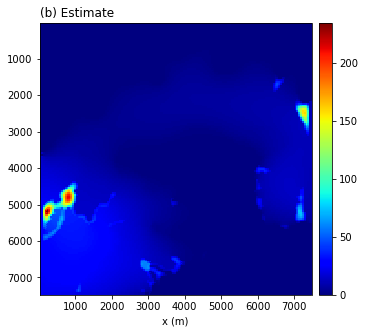

wrote Flo_py_wrkspace2\heads.asc


In [85]:
# develop geometry to plot heads as colormap
N = np.array([ncol, nrow, nlay])
dx = np.array([delc, delr, abs(botm)])
Lx = delc*ncol
Ly = delr*nrow
x = np.linspace(0. + dx[0] / 2., Lx - dx[0] / 2., N[0])
y = np.linspace(0. + dx[1] / 2., Ly - dx[1] / 2., N[1])
XX, YY = np.meshgrid(x, y)

# Extract heads data
hds = bf.HeadFile(os.path.join(workspace, '{}.hds'.format(modelname)))
times = hds.get_times() # simulation time, steady state
head = hds.get_data(totim=times[-1])
minv = 0
maxv = head.max()

# Plot em
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
im1 = axes.pcolormesh(XX, YY, head[0], vmin=minv, vmax=maxv, cmap=plt.get_cmap('jet'))
axes.set_title('(b) Estimate', loc='left')
axes.set_xlabel('x (m)')
axes.set_aspect('equal')
axes.axis([XX.min(), XX.max(), YY.max(), YY.min()])
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axes)
cbar_ax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1, cax=cbar_ax)
plt.show()

# Write the heads layer(s) to a raster file
# export head rasters 
output_raster = os.path.join(workspace, 'heads.asc')   # if there are multiple layers exports based on each layer
grid = ml.modelgrid
flopy.export.utils.export_array(grid, output_raster, head[0])

# Project the output .asc into WGS84 space with manual  ASC header modification 
new_first = ('ncols {}\n'                        # these are the parameters for the .asc file
             'nrows {}\n'
             'xllcorner {}\n'
             'yllcorner {}\n'
             'cellsize {}\n'
             'NODATA_value -999.0'.format(ncol,nrow, xll, yll, np.mean([delc, delr]) ))

with open(os.path.join('.', output_raster), 'r') as fin:   # open file 
    data = fin.read().splitlines(True)
with open(os.path.join('.', output_raster), 'w') as fout:     # delete first line
    fout.writelines(data[6:])
    
with open(os.path.join('.', output_raster), 'r+') as file:                # add in new first line and save file  
    file_data = file.read()
    file. seek(0, 0)
    file. write(new_first + '\n' + file_data)

## Run a basic zonal optimzation calibration

In [35]:
def plot_calibrateo(Howd_we_do):
    
    #Plot the OBS plot if want
    fig = plt.figure(figsize=(4,4))
    plt.title('Observed. vs Simulated.')
    plt.plot(Howd_we_do["Obs_hed_m"], Howd_we_do["Comp_hed_m"], '.')
    #plt.axis('equal')
    #plt.axis('square')
    plt.xlabel("Obs. head [m]")
    plt.ylabel('Sim. head [m]')
    plt.ylim(0,90)
    plt.xlim(0,90)
    plt.plot([0,30,65],[0,30,65], color= "grey")
    plt.tight_layout()
    plt.savefig("cal.pdf")
    plt.show()




def calibrateo(params):
    
    Alluvium_Aua, Alluvium_Fagaalu, Alluvium_minor, Alluvium_Utulei, Alluvium_Vaipito, Alluvium_Vatia, Dikes, Pago_inner_E, Pago_inner_W, Pago_outer, Trachyte= params   
    
    # set the  values this cell is set up for optimization
    HK_raster = rastah_zone(os.path.join("..",  'Data/Raw/GIS/Geo_units/v1', 'NPS_simplified_geo_v1.shp'))

    map_dic = {-12:Alluvium_Aua, 
               -14:Alluvium_Fagaalu, 
               -15:Alluvium_minor,
               -13:Alluvium_Utulei,
               -11:Alluvium_Vaipito,
               -10:Alluvium_Vatia,
               -50:Dikes,
               -30:Pago_inner_E,
               -40:Pago_inner_W,
               -20:Pago_outer,
               -60:Trachyte}

    for i in map_dic:
        HK_raster = np.where(HK_raster== i, map_dic[i], HK_raster)

    HK_raster = np.where(HK_raster== 0, 7, HK_raster)   # this is for the areas not covered by HK zones, Should not actually maatter at all!
    
    
    
    ############    Now generate the run the new model         
    modelname = 'model_pago_OPT'  
        
    ml = flopy.modflow.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace, verbose=False)
    
    discret = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                                       delr=delr, delc=delc, top=top, botm=botm,
                                       nper=nper, perlen=perlen, nstp=nstp)
    
    bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=start_heads)
    lpf = flopy.modflow.ModflowLpf(ml, laytyp=laytyp, hk=HK_raster, vka=vka)
    rch = flopy.modflow.ModflowRch(ml, rech=rch_data)
    oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd)
    pcg = flopy.modflow.ModflowPcg(ml, hclose=1.0e-6, rclose=3.0e-3, mxiter=100, iter1=50)


    # water level observations
    obs_data= []
    for i in range(0,nobs):
        obs = flopy.modflow.HeadObservation(ml, obsname=obsnames[i], layer=layervals[i], row=rowvals[i], column=colvals[i], time_series_data=[[0,obsvals[i]]])
        obs_data.append(obs)
    hob = flopy.modflow.ModflowHob(ml, iuhobsv = 7, hobdry=-999, obs_data = obs_data)        
    
    
    # Run da model 
    ml.write_input()
    ml.run_model(silent=True)


    # post process observations 
    observations = np.loadtxt(os.path.join(workspace, '{}.hob.out'.format(modelname)), skiprows=1, usecols=[0,1])      # this block extracts observation data at each well field and determines what the maximum residual at any of the given points is
    comp_obs = np.ravel(np.split(observations, 2, 1)[0]) # the computed hed values at the obspts
    obs_obs = np.ravel(np.split(observations, 2, 1)[1]) # the observed hed values at the obspts

    # note positive residuals means model is calculating too high negative is model calculates too low 
    residuals = []
    for idx, i in enumerate(observations):   
        r = observations[idx][0]-observations[idx][1]
        residuals.append(r)

    Howd_we_do = pd.DataFrame({"Obs_hed_m":obs_obs,"Comp_hed_m":comp_obs,"Residual_m":residuals})
    # error metrics
    me = np.mean(Howd_we_do.Residual_m)
    mea = np.mean(np.abs(Howd_we_do.Residual_m))
    rmse = np.sqrt(np.mean(Howd_we_do.Residual_m**2))
    
    
    # Plot if want
    plot_calibrateo(Howd_we_do)

    print("Error is - {}".format(rmse))
    print("Params are - {}".format(params))
    return rmse






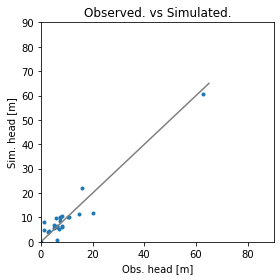

Error is - 3.267696584620217
Params are - [2.6, 39, 0.001, 14, 3.7, 1.2, 0.001, 0.37, 0.9, 0.7, 0.003]


3.267696584620217

In [36]:
# Run once 
# params = [4.6, 13.0, 0.1, 5.0, 2.6, 0.4, 0.3, 0.1, 0.5, 0.6, 0.3]
params = [2.6, 39, 0.001, 14, 3.7, 1.2, 0.001, 0.37, 0.9, 0.7, 0.003]
calibrateo(params)

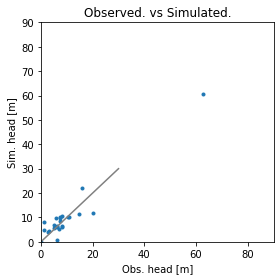

Error is - 3.267696584620217
Params are - [2.6e+00 3.9e+01 1.0e-03 1.4e+01 3.7e+00 1.2e+00 1.0e-03 3.7e-01 9.0e-01
 7.0e-01 3.0e-03]


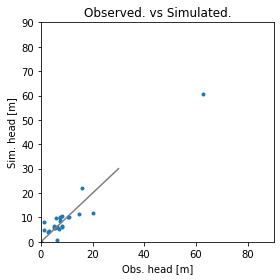

Error is - 3.262683643583739
Params are - [2.73e+00 3.90e+01 1.00e-03 1.40e+01 3.70e+00 1.20e+00 1.00e-03 3.70e-01
 9.00e-01 7.00e-01 3.00e-03]


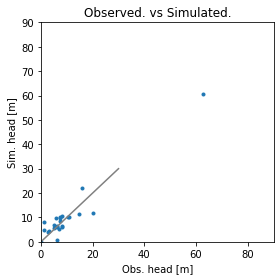

Error is - 3.2683229449851576
Params are - [2.600e+00 4.095e+01 1.000e-03 1.400e+01 3.700e+00 1.200e+00 1.000e-03
 3.700e-01 9.000e-01 7.000e-01 3.000e-03]


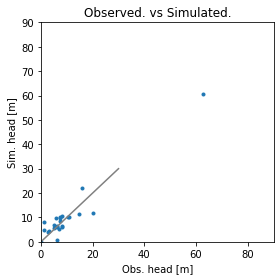

Error is - 3.268365549032399
Params are - [2.60e+00 3.90e+01 1.05e-03 1.40e+01 3.70e+00 1.20e+00 1.00e-03 3.70e-01
 9.00e-01 7.00e-01 3.00e-03]


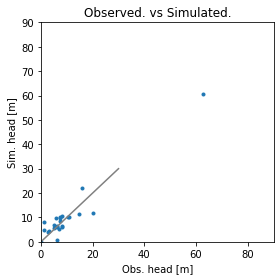

Error is - 3.2677160948277817
Params are - [2.60e+00 3.90e+01 1.00e-03 1.47e+01 3.70e+00 1.20e+00 1.00e-03 3.70e-01
 9.00e-01 7.00e-01 3.00e-03]


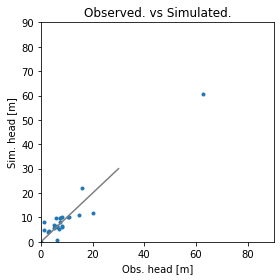

Error is - 3.2797590709280184
Params are - [2.600e+00 3.900e+01 1.000e-03 1.400e+01 3.885e+00 1.200e+00 1.000e-03
 3.700e-01 9.000e-01 7.000e-01 3.000e-03]


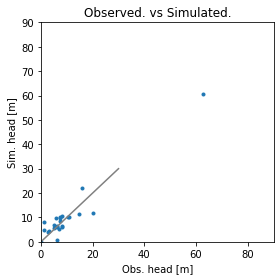

Error is - 3.2705119828526734
Params are - [2.60e+00 3.90e+01 1.00e-03 1.40e+01 3.70e+00 1.26e+00 1.00e-03 3.70e-01
 9.00e-01 7.00e-01 3.00e-03]


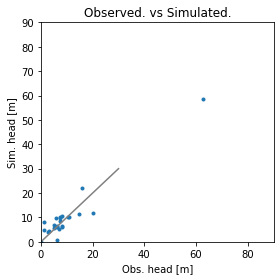

Error is - 3.337764040994554
Params are - [2.60e+00 3.90e+01 1.00e-03 1.40e+01 3.70e+00 1.20e+00 1.05e-03 3.70e-01
 9.00e-01 7.00e-01 3.00e-03]


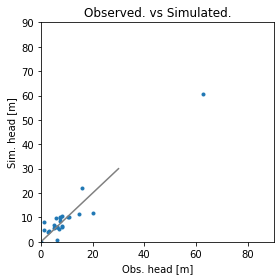

Error is - 3.2670295287911495
Params are - [2.600e+00 3.900e+01 1.000e-03 1.400e+01 3.700e+00 1.200e+00 1.000e-03
 3.885e-01 9.000e-01 7.000e-01 3.000e-03]


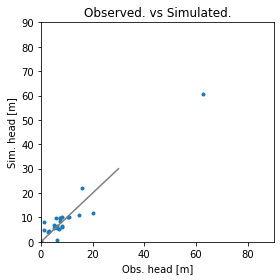

Error is - 3.2739093399675125
Params are - [2.60e+00 3.90e+01 1.00e-03 1.40e+01 3.70e+00 1.20e+00 1.00e-03 3.70e-01
 9.45e-01 7.00e-01 3.00e-03]


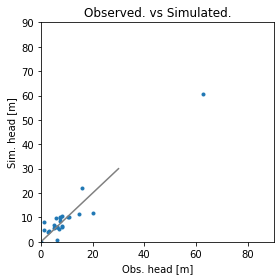

Error is - 3.2718238312902646
Params are - [2.60e+00 3.90e+01 1.00e-03 1.40e+01 3.70e+00 1.20e+00 1.00e-03 3.70e-01
 9.00e-01 7.35e-01 3.00e-03]


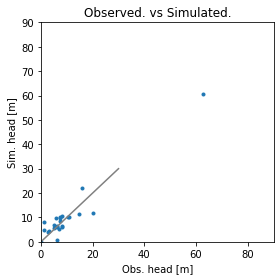

Error is - 3.2677261041239483
Params are - [2.60e+00 3.90e+01 1.00e-03 1.40e+01 3.70e+00 1.20e+00 1.00e-03 3.70e-01
 9.00e-01 7.00e-01 3.15e-03]


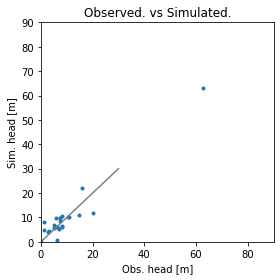

Error is - 3.2518071879621173
Params are - [2.62363636e+00 3.93545455e+01 1.00909091e-03 1.41272727e+01
 3.73363636e+00 1.21090909e+00 9.50000000e-04 3.73363636e-01
 9.08181818e-01 7.06363636e-01 3.02727273e-03]


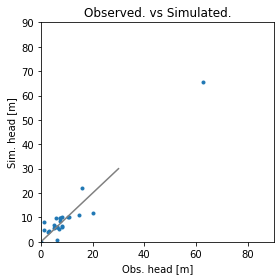

Error is - 3.305654792879492
Params are - [2.63545455e+00 3.95318182e+01 1.01363636e-03 1.41909091e+01
 3.75045455e+00 1.21636364e+00 9.00000000e-04 3.75045455e-01
 9.12272727e-01 7.09545455e-01 3.04090909e-03]


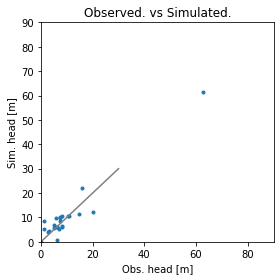

Error is - 3.256045004581555
Params are - [2.62793388e+00 3.94190083e+01 1.01074380e-03 1.41504132e+01
 3.52111570e+00 1.21289256e+00 9.90909091e-04 3.73975207e-01
 9.09669421e-01 7.07520661e-01 3.03223140e-03]


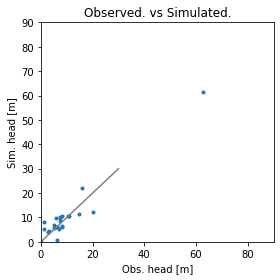

Error is - 3.2557994982026046
Params are - [2.63301277e+00 3.94951916e+01 1.01269722e-03 1.41777611e+01
 3.67359128e+00 1.21523666e+00 9.89256198e-04 3.74697971e-01
 8.58245680e-01 7.08888054e-01 3.03809166e-03]


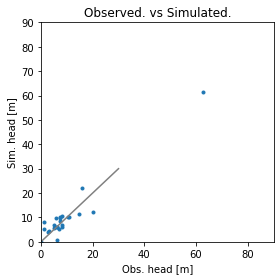

Error is - 3.253023891014889
Params are - [2.63901509e+00 3.95852264e+01 1.01500581e-03 1.42100813e+01
 3.66878970e+00 1.21800697e+00 9.87302780e-04 3.75552148e-01
 8.95653985e-01 6.69140428e-01 3.04501742e-03]


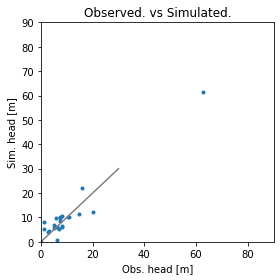

Error is - 3.2504189020257432
Params are - [2.64610875e+00 3.96916312e+01 1.01773413e-03 1.42482779e+01
 3.66311510e+00 1.15037187e+00 9.84994194e-04 3.76561630e-01
 8.94863801e-01 6.98529596e-01 3.05320240e-03]


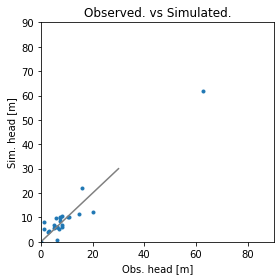

Error is - 3.2429868736901164
Params are - [2.66916312e+00 4.00374468e+01 1.02660120e-03 1.43724168e+01
 3.64467265e+00 1.09555780e+00 9.77491292e-04 3.79842444e-01
 8.92295701e-01 6.97794394e-01 3.07980360e-03]


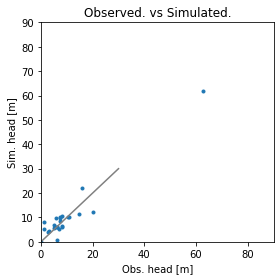

Error is - 3.249213337481053
Params are - [2.65868386e+00 3.98802579e+01 9.63479807e-04 1.43159900e+01
 3.65305558e+00 1.19138238e+00 9.80901702e-04 3.78351165e-01
 8.93463019e-01 6.98128577e-01 3.06771215e-03]


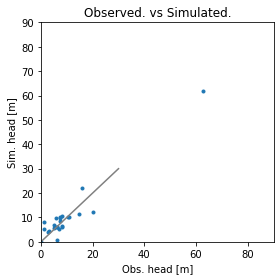

Error is - 3.246894745423135
Params are - [2.66935365e+00 3.77357594e+01 1.00683977e-03 1.43734428e+01
 3.64452023e+00 1.18981554e+00 9.77429284e-04 3.79869558e-01
 8.92274477e-01 6.97788318e-01 3.08002345e-03]


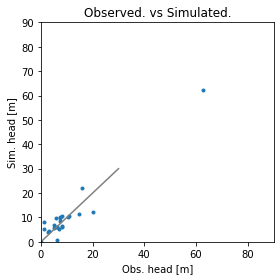

Error is - 3.2454088113288577
Params are - [2.68196341e+00 3.94558974e+01 1.00808337e-03 1.44413414e+01
 3.63443300e+00 1.18796382e+00 9.73325518e-04 3.81664024e-01
 8.90869837e-01 6.97386194e-01 2.91730044e-03]


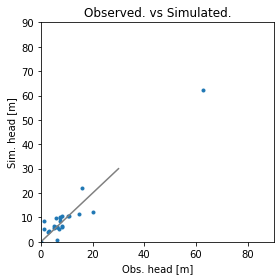

Error is - 3.243987665344706
Params are - [2.69686585e+00 3.95387879e+01 1.00955307e-03 1.36943126e+01
 3.62251173e+00 1.18577542e+00 9.68475612e-04 3.83784755e-01
 8.89209807e-01 6.96910957e-01 3.05226415e-03]


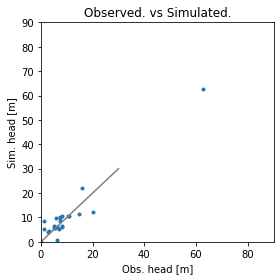

Error is - 3.243443147550463
Params are - [2.71447782e+00 3.96367493e+01 1.01128999e-03 1.43387331e+01
 3.60842295e+00 1.18318914e+00 9.62743905e-04 3.86291074e-01
 8.87247954e-01 6.96349313e-01 3.06176673e-03]


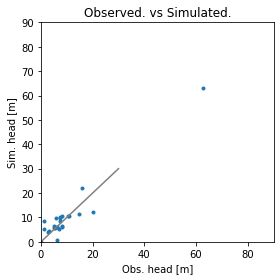

Error is - 3.244986065942425
Params are - [2.73529197e+00 3.97525219e+01 1.01334272e-03 1.44003209e+01
 3.59177258e+00 1.18013262e+00 9.55970069e-04 3.67389452e-01
 8.84929400e-01 6.95685551e-01 3.07299704e-03]


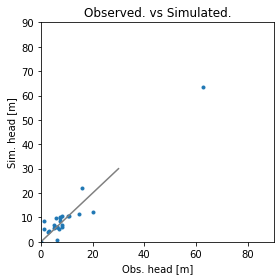

Error is - 3.2537450922919766
Params are - [2.60625415e+00 3.98893441e+01 1.01576867e-03 1.44731065e+01
 3.57209487e+00 1.17652036e+00 9.47964627e-04 3.85414806e-01
 8.82189291e-01 6.94901106e-01 3.08626923e-03]


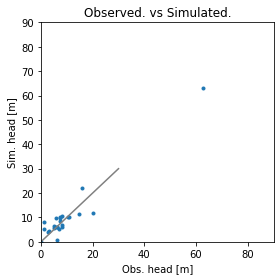

Error is - 3.244678714869421
Params are - [2.70437849e+00 3.95558514e+01 1.00593848e-03 1.43813648e+01
 3.76024811e+00 1.15701468e+00 9.49247452e-04 3.83519527e-01
 8.67523482e-01 6.85085981e-01 3.06386288e-03]


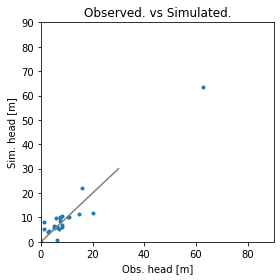

Error is - 3.246537675710352
Params are - [2.71227519e+00 3.94906971e+01 1.00275619e-03 1.43910358e+01
 3.62352831e+00 1.14408476e+00 9.43626027e-04 3.84400681e-01
 9.20634097e-01 6.79390938e-01 3.06268831e-03]


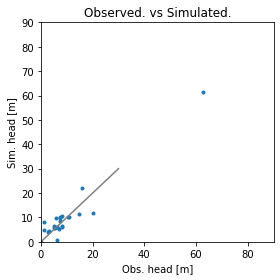

Error is - 3.249197400528902
Params are - [2.75831037e+00 3.90240634e+01 9.97318845e-04 1.40807684e+01
 3.73437626e+00 1.17690367e+00 9.84128762e-04 3.73499460e-01
 9.03680451e-01 6.90557855e-01 3.01022330e-03]


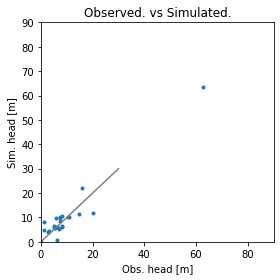

Error is - 3.2469291145152703
Params are - [2.74723947e+00 3.92261514e+01 9.94865894e-04 1.43202823e+01
 3.64960626e+00 1.12794375e+00 9.44213515e-04 3.82988902e-01
 8.91675114e-01 7.20212611e-01 3.04514890e-03]


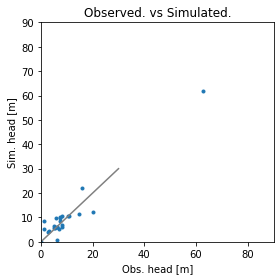

Error is - 3.2394155009544723
Params are - [2.78509149e+00 3.94334880e+01 9.98194424e-04 1.44381834e+01
 3.56948140e+00 1.11995701e+00 9.80464207e-04 3.86927462e-01
 8.76146062e-01 6.85507398e-01 3.06614381e-03]


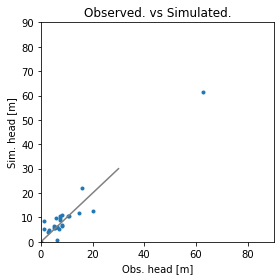

Error is - 3.2418472582933213
Params are - [2.86581905e+00 3.94729592e+01 9.92746181e-04 1.45936388e+01
 3.48740391e+00 1.07448097e+00 9.95696310e-04 3.93709375e-01
 8.60128184e-01 6.75079279e-01 3.08557935e-03]


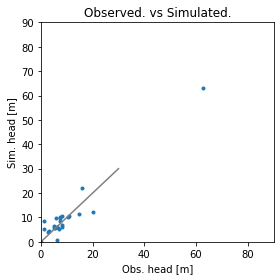

Error is - 3.2416647262962464
Params are - [2.77302720e+00 3.88265446e+01 1.05011727e-03 1.42716831e+01
 3.63486687e+00 1.12649729e+00 9.49482960e-04 3.83499261e-01
 8.87716323e-01 6.91447698e-01 3.02541924e-03]


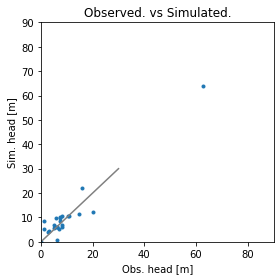

Error is - 3.256987991543883
Params are - [2.67607648e+00 3.96468266e+01 1.02587795e-03 1.45416165e+01
 3.53545358e+00 1.13181120e+00 9.39956664e-04 3.90169111e-01
 8.74596323e-01 6.99180209e-01 3.08567099e-03]


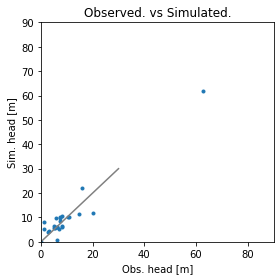

Error is - 3.242799615587141
Params are - [2.73775190e+00 3.91797542e+01 1.00445862e-03 1.41959804e+01
 3.68464559e+00 1.16563056e+00 9.73085737e-04 3.77666873e-01
 8.96409419e-01 6.92713444e-01 3.02908522e-03]


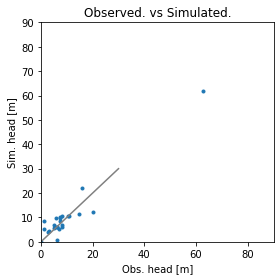

Error is - 3.2470927957637965
Params are - [2.68542237e+00 3.94363028e+01 1.03007503e-03 1.42795023e+01
 3.62659436e+00 1.18762328e+00 9.85121405e-04 3.79712027e-01
 8.87462443e-01 6.64525604e-01 3.04782471e-03]


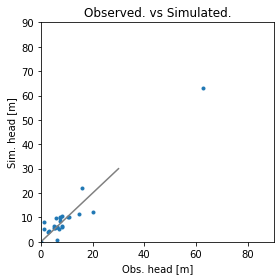

Error is - 3.2428228657299827
Params are - [2.73178519e+00 3.92786892e+01 1.00366818e-03 1.43100873e+01
 3.64385329e+00 1.14286363e+00 9.54440488e-04 3.82169684e-01
 8.90621946e-01 7.06290860e-01 3.04581786e-03]


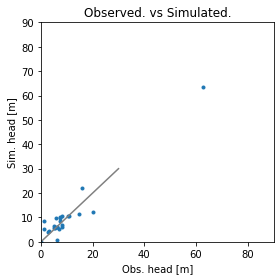

Error is - 3.242763154592777
Params are - [2.77465937e+00 4.12072275e+01 1.01752450e-03 1.42148227e+01
 3.63155913e+00 1.11721477e+00 9.47725855e-04 3.83249576e-01
 8.86562619e-01 6.88495814e-01 3.00673097e-03]


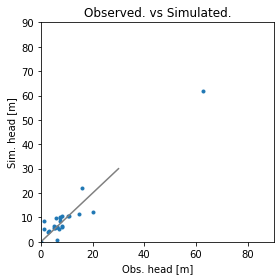

Error is - 3.24539802898586
Params are - [2.74308041e+00 3.97643862e+01 1.02429323e-03 1.41651908e+01
 3.65401120e+00 1.15806010e+00 9.82274535e-04 3.78509161e-01
 8.52008185e-01 7.08548626e-01 3.01389204e-03]


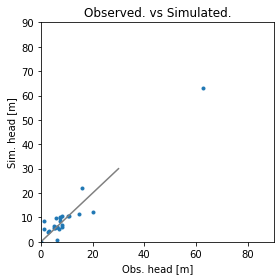

Error is - 3.239401979226196
Params are - [2.78450437e+00 3.98552748e+01 1.02191330e-03 1.40646760e+01
 3.64666618e+00 1.10874400e+00 9.54202139e-04 3.80672207e-01
 8.74706690e-01 6.92582903e-01 3.17684202e-03]


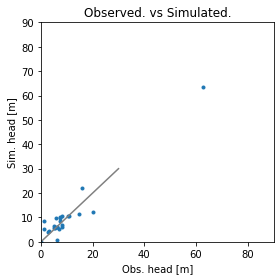

Error is - 3.2410655776325843
Params are - [2.83577486e+00 4.00549634e+01 1.02882827e-03 1.38763433e+01
 3.65278276e+00 1.06913410e+00 9.44640450e-04 3.80176299e-01
 8.66625117e-01 6.90181257e-01 3.30661282e-03]


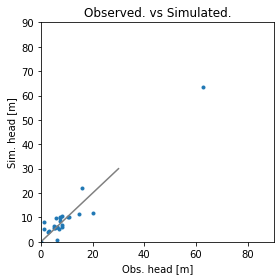

Error is - 3.2475074175391816
Params are - [2.73091900e+00 3.95633112e+01 1.00527073e-03 1.43225512e+01
 3.62575252e+00 1.12968115e+00 9.40149049e-04 3.84220351e-01
 9.17695343e-01 6.78517612e-01 3.10987769e-03]


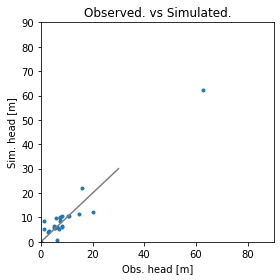

Error is - 3.241700010722729
Params are - [2.74004006e+00 3.97141174e+01 1.01953760e-03 1.42045309e+01
 3.64694653e+00 1.15096537e+00 9.71743164e-04 3.79936958e-01
 8.68429974e-01 7.01040873e-01 3.03788845e-03]


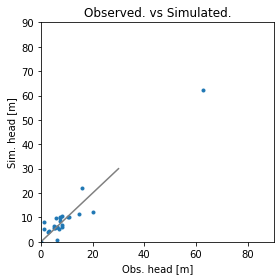

Error is - 3.2381572875770783
Params are - [2.73957073e+00 3.95681929e+01 1.01734758e-03 1.40518229e+01
 3.69802277e+00 1.10230551e+00 9.69321351e-04 3.97621425e-01
 8.81774232e-01 6.92354382e-01 3.04438931e-03]


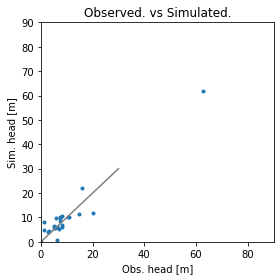

Error is - 3.2382401261636633
Params are - [2.74171011e+00 3.94760283e+01 1.01935002e-03 1.38775740e+01
 3.75114786e+00 1.06339195e+00 9.75996992e-04 4.12737412e-01
 8.80196648e-01 6.90688797e-01 3.03008544e-03]


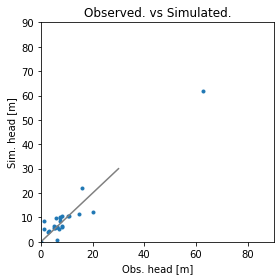

Error is - 3.2407246663879596
Params are - [2.77688280e+00 3.97671073e+01 1.02682621e-03 1.40108623e+01
 3.51823354e+00 1.11547633e+00 9.79693768e-04 3.84055331e-01
 9.01771195e-01 7.04275480e-01 3.04998282e-03]


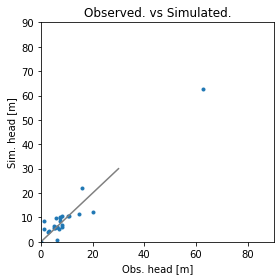

Error is - 3.235217957762266
Params are - [2.79894398e+00 3.98256834e+01 1.02635218e-03 1.47554690e+01
 3.63701025e+00 1.07393392e+00 9.62505273e-04 3.83839298e-01
 8.82368759e-01 6.93789508e-01 3.06116676e-03]


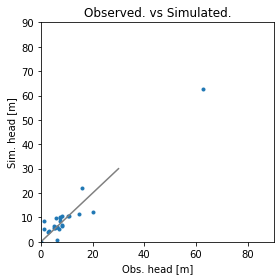

Error is - 3.2313852346356846
Params are - [2.84998305e+00 3.99691312e+01 1.03475174e-03 1.52860473e+01
 3.64425951e+00 1.01801317e+00 9.59520103e-04 3.83866570e-01
 8.78948235e-01 6.92228784e-01 3.06561806e-03]


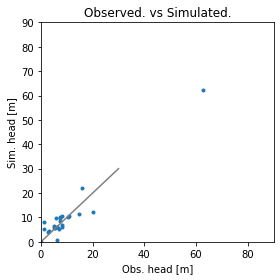

Error is - 3.2335088475152443
Params are - [2.80596932e+00 3.97881551e+01 1.02888103e-03 1.42832875e+01
 3.65761476e+00 1.04648822e+00 9.67650834e-04 3.80892160e-01
 8.82821573e-01 6.93601965e-01 3.05236443e-03]


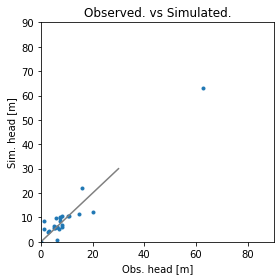

Error is - 3.239381271829543
Params are - [2.87615787e+00 3.93421317e+01 1.01398434e-03 1.42333985e+01
 3.62371818e+00 1.12519781e+00 9.51114273e-04 3.87531648e-01
 8.76051256e-01 6.91394624e-01 3.02933861e-03]


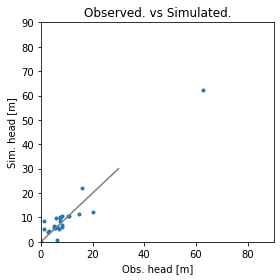

Error is - 3.233875665364017
Params are - [2.83978538e+00 4.01124243e+01 1.03879303e-03 1.42817846e+01
 3.62087661e+00 1.07468001e+00 9.73560311e-04 3.86179311e-01
 8.75075796e-01 6.80189752e-01 3.06032813e-03]


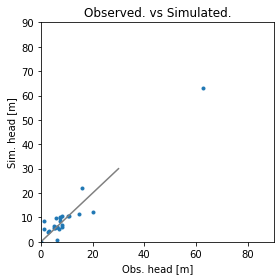

Error is - 3.2360997015920585
Params are - [2.85237022e+00 4.03809358e+01 1.04424520e-03 1.44114922e+01
 3.56848995e+00 1.03537662e+00 9.55001347e-04 3.92229838e-01
 8.65409482e-01 6.91490133e-01 3.08274130e-03]


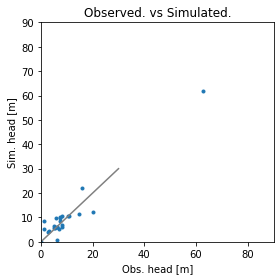

Error is - 3.2365945196720776
Params are - [2.82959200e+00 3.82032276e+01 1.03603763e-03 1.44284080e+01
 3.61010929e+00 1.06891274e+00 9.81684046e-04 3.88279910e-01
 8.71410257e-01 6.96252185e-01 3.11891561e-03]


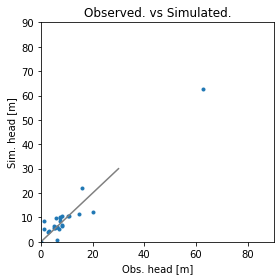

Error is - 3.230481732559093
Params are - [2.88049347e+00 3.94216304e+01 1.03702454e-03 1.44794047e+01
 3.58802421e+00 1.02024349e+00 9.59474170e-04 3.93109428e-01
 8.90084771e-01 6.82836455e-01 3.10249033e-03]


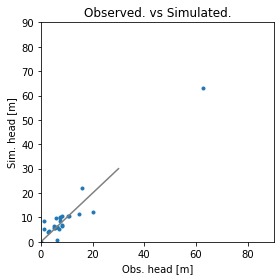

Error is - 3.2273965207604545
Params are - [2.95072018e+00 3.92753869e+01 1.04576800e-03 1.46168416e+01
 3.55856305e+00 9.54882554e-01 9.53339674e-04 3.99695663e-01
 9.00912170e-01 6.73734247e-01 3.13479127e-03]


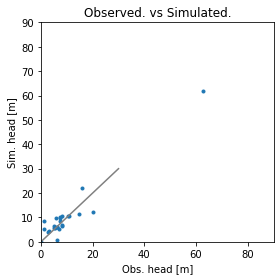

Error is - 3.2325159706742532
Params are - [2.87981415e+00 4.03908109e+01 1.00565409e-03 1.44750086e+01
 3.58623044e+00 1.01350889e+00 9.82435595e-04 3.92491926e-01
 8.73197668e-01 6.89209003e-01 3.13484538e-03]


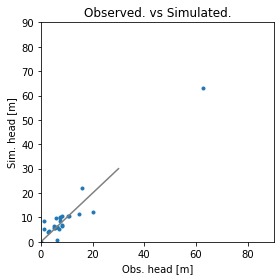

Error is - 3.230524282475761
Params are - [2.89467334e+00 3.95636489e+01 1.02509568e-03 1.48202196e+01
 3.71522685e+00 1.00599032e+00 9.52723301e-04 3.93469782e-01
 8.53947608e-01 6.73641861e-01 3.12571135e-03]


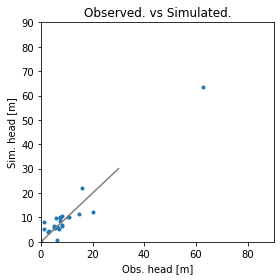

Error is - 3.2316266401214446
Params are - [2.90638862e+00 3.99209338e+01 1.05861860e-03 1.44623596e+01
 3.69047816e+00 9.80788414e-01 9.46909061e-04 3.91787163e-01
 8.75536660e-01 6.90252573e-01 3.12038083e-03]


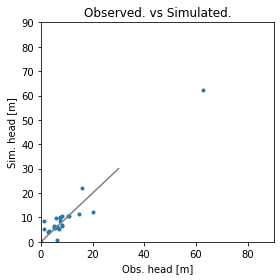

Error is - 3.2259620739878923
Params are - [2.92913651e+00 3.95110851e+01 1.04157341e-03 1.49081731e+01
 3.62125920e+00 9.68736772e-01 9.71845115e-04 4.00063319e-01
 8.77126935e-01 6.82753371e-01 2.99941694e-03]


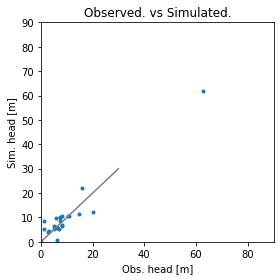

Error is - 3.2226240849975896
Params are - [3.00145258e+00 3.93389902e+01 1.05140347e-03 1.53299217e+01
 3.60855571e+00 8.98733156e-01 9.80666603e-04 4.09758876e-01
 8.78337057e-01 6.77838605e-01 2.91070439e-03]


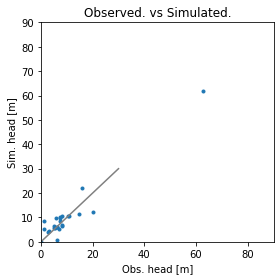

Error is - 3.226716977361455
Params are - [2.86026387e+00 4.00236569e+01 1.05630585e-03 1.49388185e+01
 3.64145039e+00 9.11107577e-01 9.80306132e-04 3.97245193e-01
 8.76197969e-01 6.81476920e-01 3.12535049e-03]


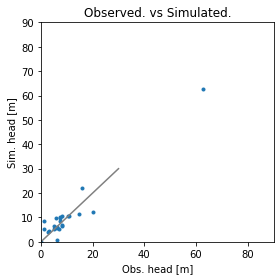

Error is - 3.2227181565006164
Params are - [3.01879521e+00 3.98804074e+01 1.06002593e-03 1.52816660e+01
 3.55685991e+00 8.99236617e-01 9.64096287e-04 3.87087010e-01
 8.69461127e-01 6.78539441e-01 3.12502001e-03]


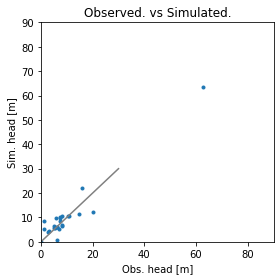

Error is - 3.226303580733913
Params are - [2.96317454e+00 4.15503145e+01 1.04569739e-03 1.50602187e+01
 3.63509168e+00 9.01779175e-01 9.48535817e-04 3.96211633e-01
 8.79470714e-01 6.71421140e-01 3.05160360e-03]


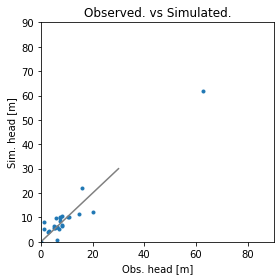

Error is - 3.2225959896796774
Params are - [2.96054255e+00 3.95852206e+01 1.03775385e-03 1.51950848e+01
 3.68882043e+00 9.11024849e-01 9.74042965e-04 3.92985669e-01
 8.88028077e-01 6.72534283e-01 3.08211651e-03]


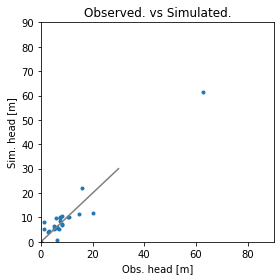

Error is - 3.223736112178592
Params are - [3.01462871e+00 3.91873631e+01 1.03450818e-03 1.55868812e+01
 3.74898566e+00 8.48848960e-01 9.83563774e-04 3.93363584e-01
 8.99337374e-01 6.63056358e-01 3.08180411e-03]


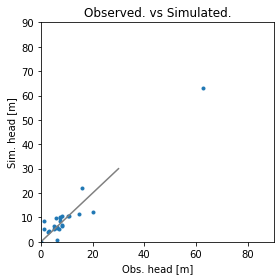

Error is - 3.219171548014148
Params are - [2.99508324e+00 3.97578768e+01 1.04301709e-03 1.54908470e+01
 3.64878718e+00 8.41965974e-01 9.55571757e-04 4.00273715e-01
 8.80716724e-01 6.82442761e-01 3.10849120e-03]


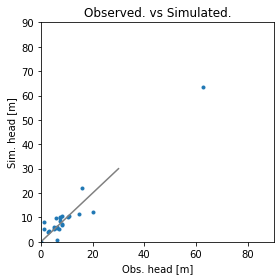

Error is - 3.215133995172177
Params are - [3.07273217e+00 3.95806031e+01 1.04512912e-03 1.60953782e+01
 3.66274247e+00 7.25608954e-01 9.46577480e-04 4.07320917e-01
 8.83537188e-01 6.83569265e-01 3.13257273e-03]


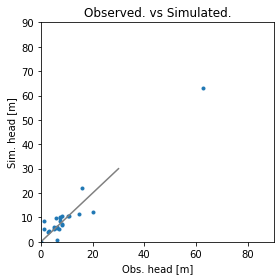

Error is - 3.216528666976879
Params are - [3.07740163e+00 4.00444094e+01 1.05588328e-03 1.58188151e+01
 3.61298135e+00 8.11816087e-01 9.57649715e-04 4.10366094e-01
 8.73101059e-01 6.67206420e-01 3.13103823e-03]


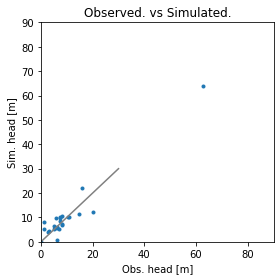

Error is - 3.224169741842504
Params are - [3.03948180e+00 3.93787715e+01 1.08824281e-03 1.58714225e+01
 3.68922946e+00 8.08124001e-01 9.38358430e-04 4.02016178e-01
 8.82707399e-01 6.67598913e-01 3.04786507e-03]


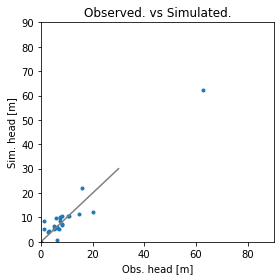

Error is - 3.215494065607729
Params are - [3.03710609e+00 3.97500736e+01 1.04066451e-03 1.61402648e+01
 3.58475471e+00 8.09450942e-01 9.72330304e-04 4.04580761e-01
 8.81672177e-01 6.62436496e-01 3.04914494e-03]


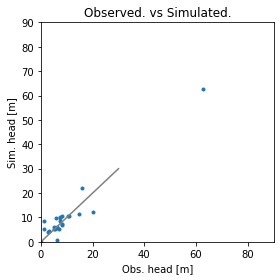

Error is - 3.210321579664573
Params are - [3.12753404e+00 3.96620475e+01 1.06560642e-03 1.54718894e+01
 3.62015431e+00 7.34305777e-01 9.62048389e-04 4.16267571e-01
 8.78755864e-01 6.55043505e-01 3.10091259e-03]


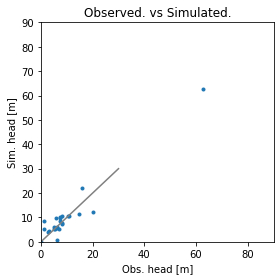

Error is - 3.20377296060549
Params are - [3.26630953e+00 3.95085057e+01 1.08103376e-03 1.55648104e+01
 3.60810171e+00 5.92452078e-01 9.63312532e-04 4.32468071e-01
 8.78659678e-01 6.36450866e-01 3.11855986e-03]


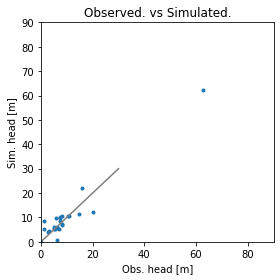

Error is - 3.207394361630252
Params are - [3.15041396e+00 4.00575038e+01 1.08543304e-03 1.60730972e+01
 3.52970967e+00 6.71139861e-01 9.70770505e-04 4.13754957e-01
 9.08249594e-01 6.66868429e-01 3.03951903e-03]


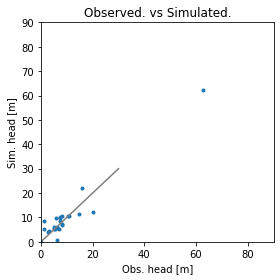

Error is - 3.207343446243066
Params are - [3.13067508e+00 4.04879689e+01 1.07197255e-03 1.65412490e+01
 3.68112740e+00 6.70658045e-01 9.73323375e-04 4.10085312e-01
 8.62619110e-01 6.65527713e-01 3.01311688e-03]


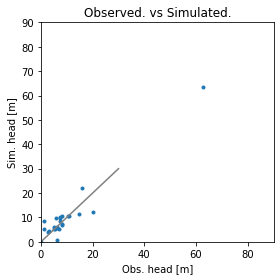

Error is - 3.2135313927468236
Params are - [3.27029707e+00 3.98241192e+01 1.06428319e-03 1.65106230e+01
 3.60545407e+00 6.70714925e-01 9.45087325e-04 4.14870349e-01
 8.84864428e-01 6.54885184e-01 3.00215156e-03]


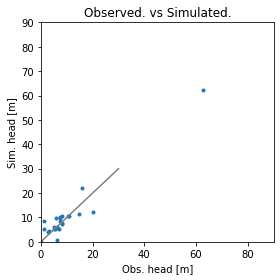

Error is - 3.2050438229446234
Params are - [3.22322686e+00 3.79836079e+01 1.07827088e-03 1.66529327e+01
 3.60642412e+00 6.38031646e-01 9.76230641e-04 4.19296401e-01
 8.82572358e-01 6.61934427e-01 3.06690717e-03]


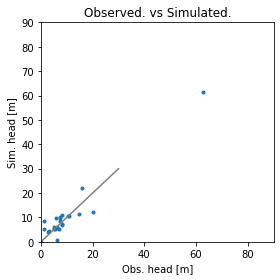

Error is - 3.215573149993645
Params are - [3.18032779e+00 3.99014849e+01 1.03391239e-03 1.59838216e+01
 3.53723082e+00 7.00760937e-01 9.93293885e-04 4.16633716e-01
 8.79311120e-01 6.64726747e-01 3.07410790e-03]


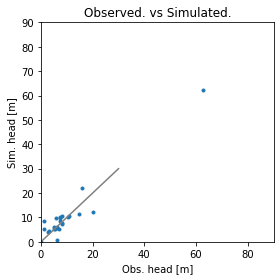

Error is - 3.2016969546190994
Params are - [3.23038393e+00 3.94036812e+01 1.05738135e-03 1.67012429e+01
 3.66603144e+00 5.73561834e-01 9.72864682e-04 4.36935013e-01
 8.94348300e-01 6.51274820e-01 2.98769621e-03]


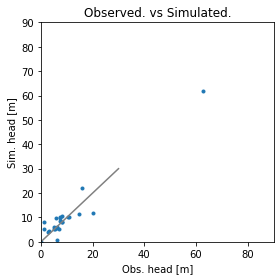

Error is - 3.2003457932578168
Params are - [3.33617829e+00 3.91653180e+01 1.05605906e-03 1.74110313e+01
 3.72061721e+00 4.10724443e-01 9.77248880e-04 4.61859014e-01
 9.06791886e-01 6.37642509e-01 2.91903431e-03]


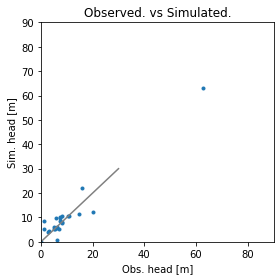

Error is - 3.2004083521924356
Params are - [3.30858579e+00 3.99135216e+01 1.06685029e-03 1.70313708e+01
 3.63471046e+00 4.85336438e-01 9.55672962e-04 4.23735899e-01
 8.90645975e-01 6.44667275e-01 3.20352636e-03]


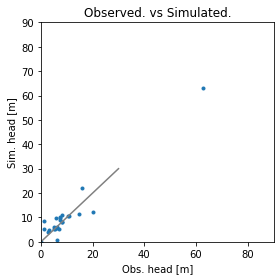

Error is - 3.2012437903868
Params are - [3.41277641e+00 3.97269823e+01 1.08579016e-03 1.75000777e+01
 3.54460757e+00 3.95646853e-01 9.58956599e-04 4.46100057e-01
 8.81430936e-01 6.44904868e-01 3.05418876e-03]


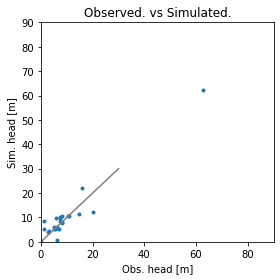

Error is - 3.197983024946221
Params are - [3.35689455e+00 3.92100795e+01 1.07309835e-03 1.71820316e+01
 3.60801505e+00 4.19188481e-01 9.75587465e-04 4.35216716e-01
 8.97872478e-01 6.46177903e-01 2.99129440e-03]


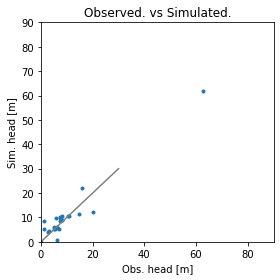

Error is - 3.211175401811557
Params are - [3.49664101e+00 3.87929145e+01 1.08170588e-03 1.78636398e+01
 3.60553191e+00 2.22874678e-01 9.84556340e-04 4.47642027e-01
 9.10258187e-01 6.35663645e-01 2.92142249e-03]


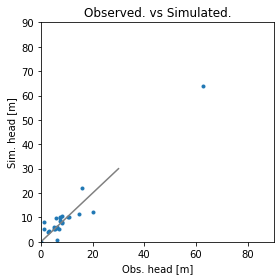

Error is - 3.208645495769838
Params are - [3.28607145e+00 3.92272940e+01 1.10219396e-03 1.72348814e+01
 3.69663545e+00 4.79048639e-01 9.36723946e-04 4.32327821e-01
 8.95037209e-01 6.45285059e-01 3.03316774e-03]


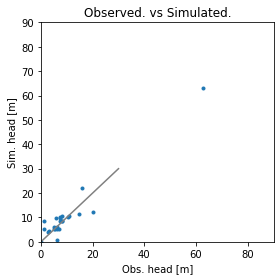

Error is - 3.200010874984276
Params are - [3.47455957e+00 3.92836544e+01 1.10662901e-03 1.72774595e+01
 3.66945351e+00 3.10285487e-01 9.51213644e-04 4.49425696e-01
 8.95106157e-01 6.44456867e-01 3.05522575e-03]


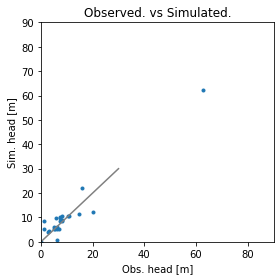

Error is - 3.205858852671778
Params are - [3.51199303e+00 3.93991342e+01 1.11334620e-03 1.75372699e+01
 3.59268593e+00 3.18614118e-01 9.77809406e-04 4.54340955e-01
 8.95344595e-01 6.16212754e-01 2.95773487e-03]


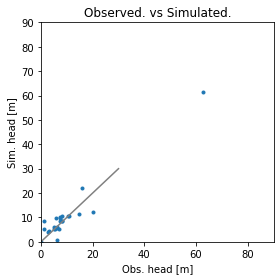

Error is - 3.2046993067344802
Params are - [3.35837284e+00 3.90783481e+01 1.10311268e-03 1.73086882e+01
 3.64765286e+00 3.09489818e-01 9.85249030e-04 4.53967997e-01
 8.95922841e-01 6.37865483e-01 3.08008029e-03]


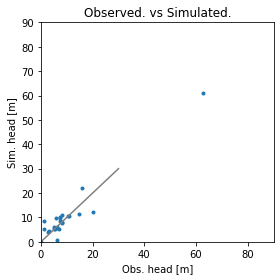

Error is - 3.212259077077096
Params are - [3.35574417e+00 3.96480923e+01 1.06536895e-03 1.65978492e+01
 3.54756555e+00 4.70327228e-01 1.00243515e-03 4.40445102e-01
 8.85911084e-01 6.46116594e-01 3.05759366e-03]


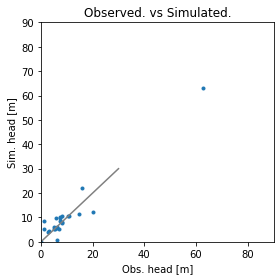

Error is - 3.2000439321544802
Params are - [3.30348963e+00 3.93324935e+01 1.09298770e-03 1.70756233e+01
 3.65936797e+00 4.76868286e-01 9.53151748e-04 4.34357141e-01
 8.92755677e-01 6.45492943e-01 3.03927422e-03]


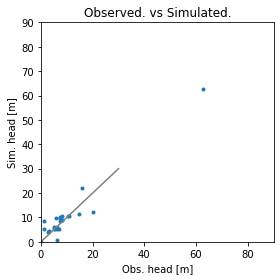

Error is - 3.208323143116079
Params are - [3.51923360e+00 3.86860625e+01 1.08350343e-03 1.79419108e+01
 3.73806556e+00 2.42913901e-01 9.65185182e-04 4.62763817e-01
 8.69881622e-01 6.20646772e-01 3.05119786e-03]


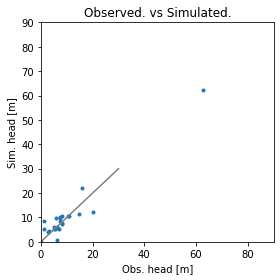

Error is - 3.20133780789263
Params are - [3.24261887e+00 3.97146434e+01 1.08495064e-03 1.65403006e+01
 3.58179865e+00 5.64083371e-01 9.69374175e-04 4.26007172e-01
 8.98657601e-01 6.55313015e-01 3.04243874e-03]


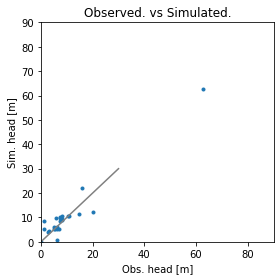

Error is - 3.212786614047284
Params are - [3.55932590e+00 3.81149927e+01 1.09932359e-03 1.74735867e+01
 3.56858806e+00 2.24018504e-01 9.61914276e-04 4.69328346e-01
 9.22064560e-01 6.20130271e-01 3.08293125e-03]


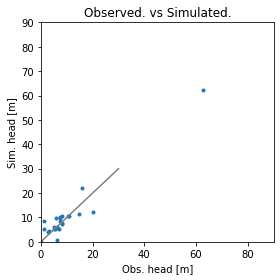

Error is - 3.200953366585005
Params are - [3.23783778e+00 3.98947248e+01 1.07881031e-03 1.67743334e+01
 3.65299257e+00 5.58998160e-01 9.70471100e-04 4.24896070e-01
 8.77480472e-01 6.54178352e-01 3.03057048e-03]


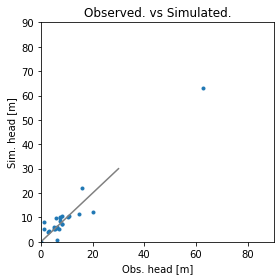

Error is - 3.204830645602381
Params are - [3.12816154e+00 3.92939348e+01 1.05167068e-03 1.63388500e+01
 3.66799437e+00 6.19768620e-01 9.56094007e-04 4.19719088e-01
 8.86091052e-01 6.76348066e-01 3.15155610e-03]


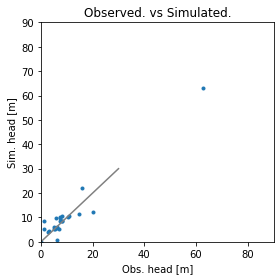

Error is - 3.2032127941284765
Params are - [3.39964311e+00 4.09477023e+01 1.08190960e-03 1.71660813e+01
 3.66545078e+00 2.97030542e-01 9.54011566e-04 4.54840493e-01
 8.99503052e-01 6.33247055e-01 3.05777451e-03]


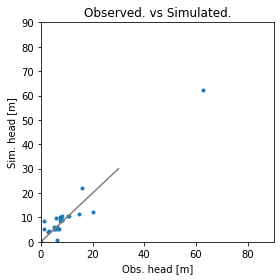

Error is - 3.2121287134906904
Params are - [3.54406871e+00 3.99380605e+01 1.11400778e-03 1.76305696e+01
 3.60341806e+00 2.56613917e-01 9.73769574e-04 4.60803517e-01
 8.98422904e-01 6.10996868e-01 2.95607439e-03]


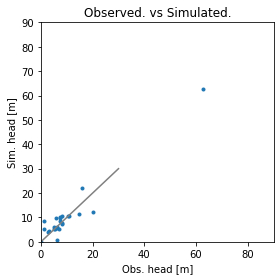

Error is - 3.1995296429716085
Params are - [3.23213833e+00 3.94549662e+01 1.06725496e-03 1.66617799e+01
 3.65185029e+00 5.28979945e-01 9.60512899e-04 4.29990195e-01
 8.89174015e-01 6.60010267e-01 3.10268567e-03]


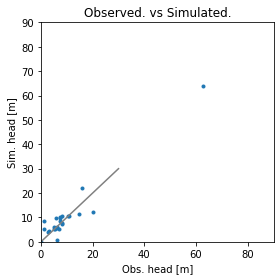

Error is - 3.2134228238716074
Params are - [3.29090568e+00 4.02221231e+01 1.05604620e-03 1.65431118e+01
 3.62452274e+00 6.06800015e-01 9.40117073e-04 4.22195008e-01
 8.87364056e-01 6.53505775e-01 3.03166027e-03]


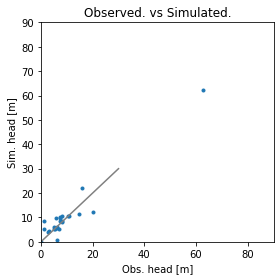

Error is - 3.1981561390532653
Params are - [3.34150605e+00 3.93642919e+01 1.09134606e-03 1.71172941e+01
 3.64187033e+00 3.83817368e-01 9.73966041e-04 4.46024750e-01
 8.93783144e-01 6.41775556e-01 3.06797528e-03]


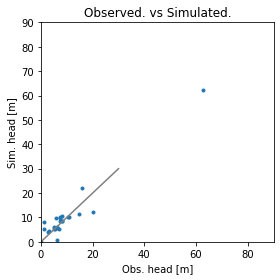

Error is - 3.1967369577249287
Params are - [3.39664108e+00 3.97657449e+01 1.08000008e-03 1.85692593e+01
 3.67021363e+00 2.85904172e-01 9.63990574e-04 4.46159784e-01
 9.07376939e-01 6.55888518e-01 2.98398350e-03]


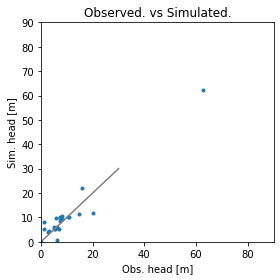

Error is - 3.2128334260111546
Params are - [3.46180686e+00 3.98943644e+01 1.07948323e-03 2.00714837e+01
 3.70126960e+00 1.32630219e-01 9.64329594e-04 4.53005641e-01
 9.21735569e-01 6.65607344e-01 2.91669532e-03]


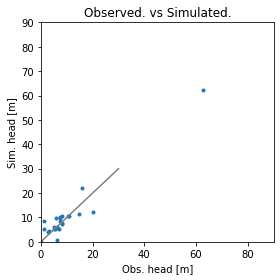

Error is - 3.2018374338001587
Params are - [3.26276169e+00 3.81116469e+01 1.07877706e-03 1.72231117e+01
 3.61373054e+00 5.79302731e-01 9.75105904e-04 4.22209051e-01
 8.87965181e-01 6.63208959e-01 3.03135230e-03]


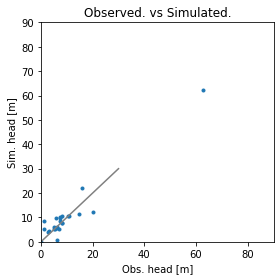

Error is - 3.1984270152357883
Params are - [3.29698204e+00 3.88206607e+01 1.07956019e-03 1.72088541e+01
 3.62666060e+00 5.08734684e-01 9.69832319e-04 4.30366912e-01
 8.90849649e-01 6.55718483e-01 3.03795785e-03]


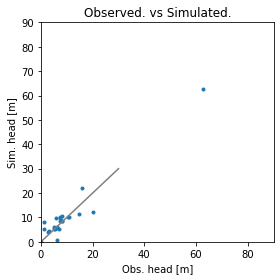

Error is - 3.1987319837275936
Params are - [3.42967013e+00 3.91821635e+01 1.07475593e-03 1.79704476e+01
 3.70553939e+00 3.02186504e-01 9.59826595e-04 4.51835052e-01
 8.87391004e-01 6.41216720e-01 3.04587337e-03]


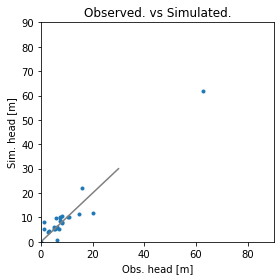

Error is - 3.199396318979433
Params are - [3.26258419e+00 3.90707666e+01 1.07191019e-03 1.70961922e+01
 3.77199080e+00 4.53630232e-01 9.70402351e-04 4.32784894e-01
 9.05701317e-01 6.50954294e-01 3.03261146e-03]


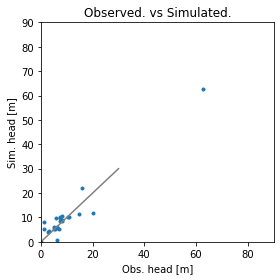

Error is - 3.200561269528123
Params are - [3.44202215e+00 3.87532135e+01 1.07763548e-03 1.78804564e+01
 3.68524184e+00 2.71121120e-01 9.58875350e-04 4.55423212e-01
 9.14782844e-01 6.41094618e-01 3.05660083e-03]


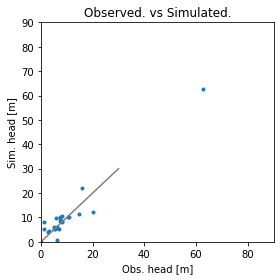

Error is - 3.196857385082636
Params are - [3.39097606e+00 3.90385913e+01 1.07792919e-03 1.76039256e+01
 3.67717952e+00 3.43090380e-01 9.61774288e-04 4.47791426e-01
 9.05457251e-01 6.44365551e-01 3.05009324e-03]


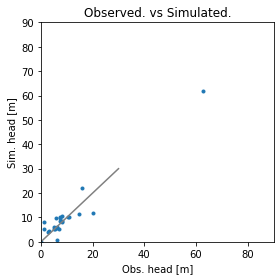

Error is - 3.198329630617616
Params are - [3.38625420e+00 3.85753385e+01 1.09160984e-03 1.77275199e+01
 3.71124559e+00 3.18919922e-01 9.74782820e-04 4.60957115e-01
 9.04310301e-01 6.50550837e-01 2.85574802e-03]


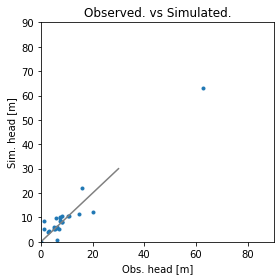

Error is - 3.1977947797717783
Params are - [3.36776641e+00 3.92162731e+01 1.10886485e-03 1.74054027e+01
 3.62363492e+00 3.76840187e-01 9.52758528e-04 4.22670019e-01
 8.87713192e-01 6.59922571e-01 3.12873346e-03]


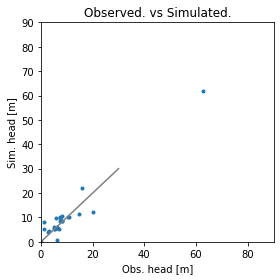

Error is - 3.1985352104320626
Params are - [3.41214176e+00 3.90279666e+01 1.07482296e-03 1.78007706e+01
 3.67838723e+00 2.92509416e-01 9.76784166e-04 4.48046960e-01
 9.00832586e-01 6.54695705e-01 3.02475887e-03]


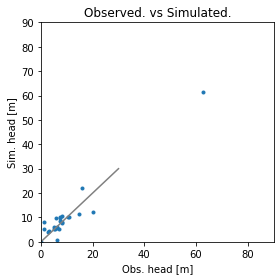

Error is - 3.2017315209011357
Params are - [3.22972312e+00 3.90303170e+01 1.05539874e-03 1.76940819e+01
 3.66992601e+00 4.55860202e-01 9.83371455e-04 4.32727727e-01
 8.99523275e-01 6.57593388e-01 3.00326791e-03]


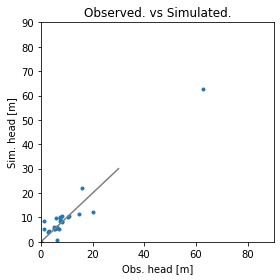

Error is - 3.196519828711521
Params are - [3.41335046e+00 3.92203201e+01 1.09382144e-03 1.73816151e+01
 3.66957163e+00 3.46679166e-01 9.59253097e-04 4.45251203e-01
 8.96210437e-01 6.47740998e-01 3.04223629e-03]


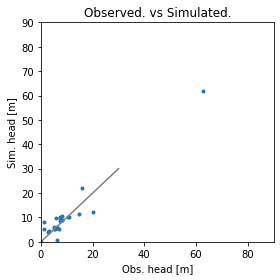

Error is - 3.2088808492566527
Params are - [3.50509202e+00 3.88163423e+01 1.09960306e-03 1.84406406e+01
 3.69075129e+00 2.04020148e-01 9.73843145e-04 4.54937956e-01
 9.06734767e-01 6.39809213e-01 2.94481719e-03]


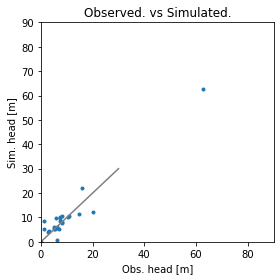

Error is - 3.196466615098279
Params are - [3.30037675e+00 3.92953102e+01 1.07534198e-03 1.71064951e+01
 3.66157554e+00 4.47739996e-01 9.63845461e-04 4.36227135e-01
 8.93564203e-01 6.54960003e-01 3.06321855e-03]


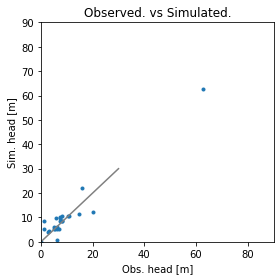

Error is - 3.200683210494482
Params are - [3.48151754e+00 3.92413679e+01 1.09557179e-03 1.80081015e+01
 3.55053528e+00 2.78298909e-01 9.62761531e-04 4.52769120e-01
 8.88000716e-01 6.49593496e-01 3.02045633e-03]


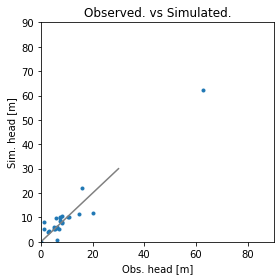

Error is - 3.196676645642248
Params are - [3.31731753e+00 3.91134170e+01 1.07782559e-03 1.73241696e+01
 3.71662692e+00 4.09797401e-01 9.68492146e-04 4.37780950e-01
 9.01276167e-01 6.50614095e-01 3.02957268e-03]


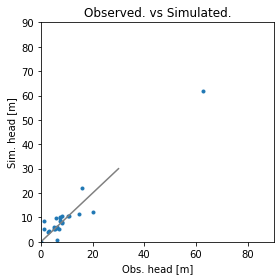

Error is - 3.1975585618011295
Params are - [3.29400385e+00 3.91174718e+01 1.09328416e-03 1.70163411e+01
 3.61900261e+00 4.49308254e-01 9.74912842e-04 4.31163670e-01
 9.08835605e-01 6.61039684e-01 3.00423066e-03]


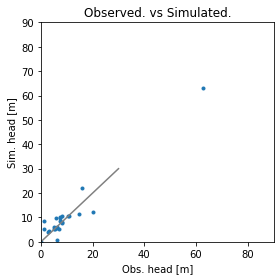

Error is - 3.199091512638893
Params are - [3.29005260e+00 3.92879423e+01 1.09657372e-03 1.70433945e+01
 3.63535756e+00 4.87494222e-01 9.57615031e-04 4.31882072e-01
 8.96849117e-01 6.48714149e-01 3.02161275e-03]


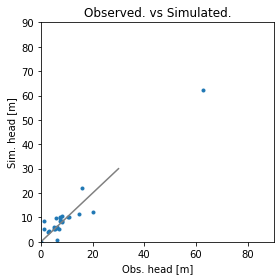

Error is - 3.196273061127237
Params are - [3.38161947e+00 3.90929605e+01 1.08026065e-03 1.76114266e+01
 3.66762981e+00 3.41255618e-01 9.71991882e-04 4.44005738e-01
 8.99836719e-01 6.53200316e-01 3.02397234e-03]


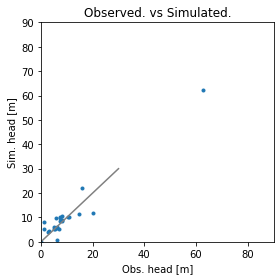

Error is - 3.2016271399154186
Params are - [3.42060094e+00 3.95447572e+01 1.09196384e-03 1.77085060e+01
 3.69453314e+00 2.40818215e-01 9.64959525e-04 4.52041908e-01
 9.08466067e-01 6.47233523e-01 3.00587095e-03]


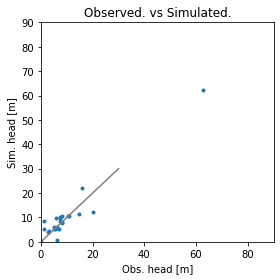

Error is - 3.196433806449192
Params are - [3.32788677e+00 3.90016849e+01 1.08266111e-03 1.73337671e+01
 3.64362873e+00 4.41755567e-01 9.68614121e-04 4.35785661e-01
 8.95253753e-01 6.53597243e-01 3.02993613e-03]


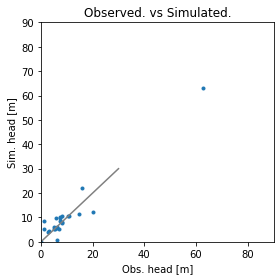

Error is - 3.1986724473617407
Params are - [3.32071652e+00 3.98675970e+01 1.07828715e-03 1.71182488e+01
 3.59765417e+00 4.52966731e-01 9.58887442e-04 4.16875076e-01
 8.93358769e-01 6.52955061e-01 3.21975135e-03]


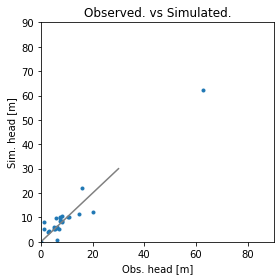

Error is - 3.196317515695708
Params are - [3.36986978e+00 3.88984031e+01 1.08827917e-03 1.75752021e+01
 3.68284774e+00 3.52431624e-01 9.70808976e-04 4.49936606e-01
 9.01572418e-01 6.51151893e-01 2.94674885e-03]


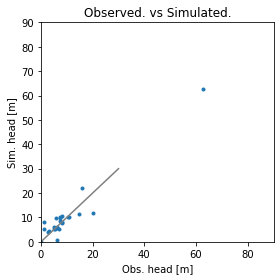

Error is - 3.1944998521926675
Params are - [3.37062171e+00 3.89939365e+01 1.07799332e-03 1.78117306e+01
 3.67447987e+00 3.82362786e-01 9.59130210e-04 4.32518688e-01
 9.05302158e-01 6.63435130e-01 2.98548292e-03]


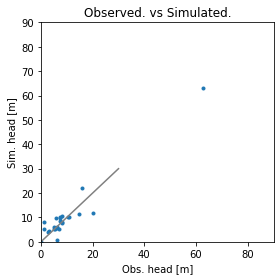

Error is - 3.1949304370446945
Params are - [3.38517954e+00 3.88087589e+01 1.07131694e-03 1.81589489e+01
 3.69078465e+00 3.81635496e-01 9.51712294e-04 4.25765658e-01
 9.11061664e-01 6.74264917e-01 2.94423673e-03]


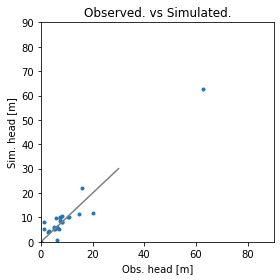

Error is - 3.195276832540876
Params are - [3.35772906e+00 3.91088502e+01 1.09713102e-03 1.78614839e+01
 3.72041966e+00 3.40296092e-01 9.54516557e-04 4.42836172e-01
 9.02563675e-01 6.62170460e-01 3.06110716e-03]


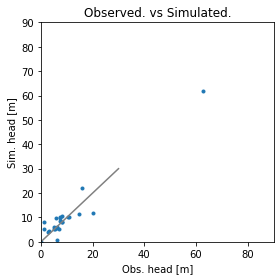

Error is - 3.199987174498757
Params are - [3.34503223e+00 3.90831252e+01 1.05923109e-03 1.77210366e+01
 3.72239702e+00 3.76000005e-01 9.77665136e-04 4.59049442e-01
 9.15423048e-01 6.48834500e-01 2.91137241e-03]


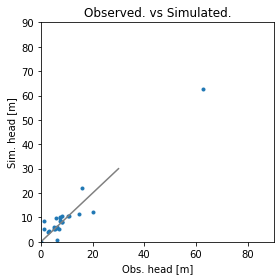

Error is - 3.195604117633838
Params are - [3.36208286e+00 3.91829861e+01 1.09645641e-03 1.74843112e+01
 3.64832544e+00 3.76630141e-01 9.58985180e-04 4.31764875e-01
 8.94640656e-01 6.57150553e-01 3.07439320e-03]


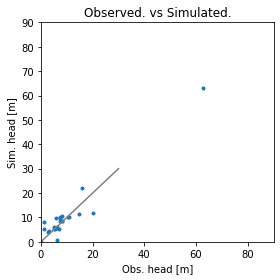

Error is - 3.199302889605924
Params are - [3.43117280e+00 3.91938382e+01 1.07538855e-03 1.81951836e+01
 3.73236076e+00 2.90317735e-01 9.52614883e-04 4.50665101e-01
 8.91719737e-01 6.47010273e-01 3.04863204e-03]


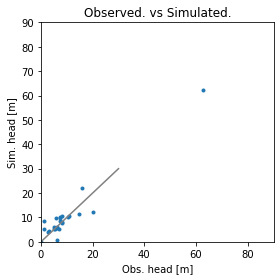

Error is - 3.195734895043259
Params are - [3.32829608e+00 3.91365634e+01 1.08881026e-03 1.73110517e+01
 3.64734214e+00 4.09560625e-01 9.69338353e-04 4.36039028e-01
 9.04556638e-01 6.57532331e-01 3.01533100e-03]


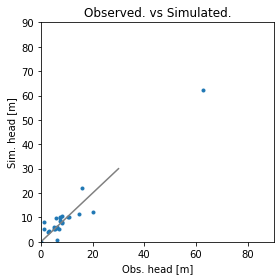

Error is - 3.19475016043108
Params are - [3.32280422e+00 3.92905317e+01 1.09272191e-03 1.75543493e+01
 3.66875887e+00 4.08621109e-01 9.67128722e-04 4.31900544e-01
 8.94934342e-01 6.66078365e-01 2.99644905e-03]


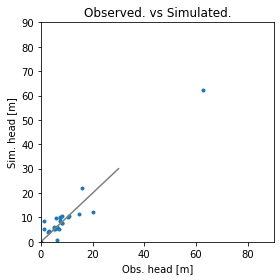

Error is - 3.197132713097154
Params are - [3.30371432e+00 3.84769758e+01 1.09296408e-03 1.64044865e+01
 3.67546025e+00 4.88119487e-01 9.65483009e-04 4.30939598e-01
 8.90752364e-01 6.56408098e-01 3.06482526e-03]


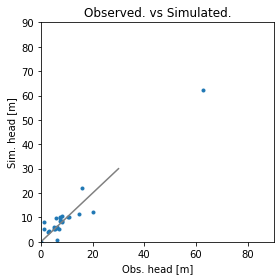

Error is - 3.195300459396626
Params are - [3.37340939e+00 3.94435526e+01 1.08324108e-03 1.80280661e+01
 3.67152529e+00 3.36458001e-01 9.64363682e-04 4.42354738e-01
 9.03220795e-01 6.56018413e-01 3.00419394e-03]


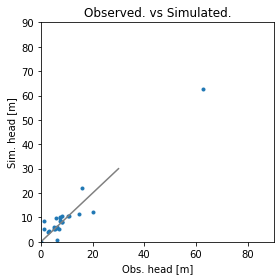

Error is - 3.1947760398789904
Params are - [3.39323640e+00 3.91893284e+01 1.09612320e-03 1.77775575e+01
 3.62084667e+00 3.50891821e-01 9.60230807e-04 4.40150029e-01
 8.97206704e-01 6.62665124e-01 3.01462177e-03]


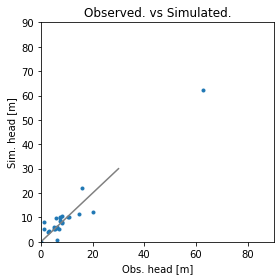

Error is - 3.1952046996265198
Params are - [3.29354636e+00 3.90767904e+01 1.08054585e-03 1.77921015e+01
 3.65904287e+00 4.14775994e-01 9.69647622e-04 4.31752290e-01
 9.02453575e-01 6.68251699e-01 2.99693733e-03]


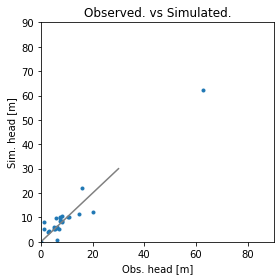

Error is - 3.194538396159008
Params are - [3.40527817e+00 3.89620694e+01 1.09997147e-03 1.81918772e+01
 3.66657848e+00 3.07721709e-01 9.66110196e-04 4.39962750e-01
 9.06716058e-01 6.63449366e-01 2.96390394e-03]


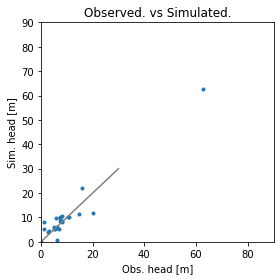

Error is - 3.194627636687487
Params are - [3.39183933e+00 3.92484919e+01 1.09579968e-03 1.81206252e+01
 3.68869797e+00 2.89336346e-01 9.60886277e-04 4.41163695e-01
 9.07110563e-01 6.66603421e-01 2.98518051e-03]


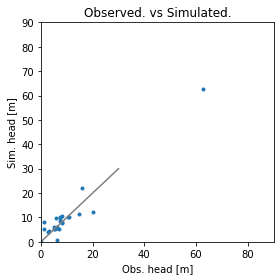

Error is - 3.1941734215262962
Params are - [3.35385078e+00 3.94154262e+01 1.09154898e-03 1.79783580e+01
 3.65054264e+00 3.67188420e-01 9.56887295e-04 4.25417676e-01
 9.01798833e-01 6.71858140e-01 3.07535536e-03]


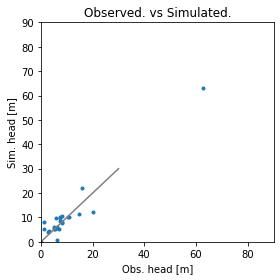

Error is - 3.19572712556461
Params are - [3.34584127e+00 3.96739377e+01 1.09318389e-03 1.81799360e+01
 3.63439009e+00 3.74566817e-01 9.49926454e-04 4.13158211e-01
 9.01912040e-01 6.82211263e-01 3.13965862e-03]


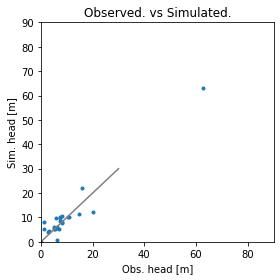

Error is - 3.195086891528503
Params are - [3.33705223e+00 3.92794989e+01 1.10161993e-03 1.80088484e+01
 3.66265380e+00 3.83079481e-01 9.52958100e-04 4.27968895e-01
 9.03891281e-01 6.73202048e-01 3.00747424e-03]


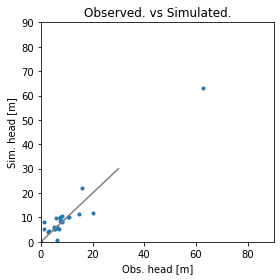

Error is - 3.194741598742143
Params are - [3.39196765e+00 3.92618843e+01 1.09539935e-03 1.84360953e+01
 3.68572541e+00 3.09959721e-01 9.52633402e-04 4.34468309e-01
 8.99050388e-01 6.71719073e-01 3.01468707e-03]


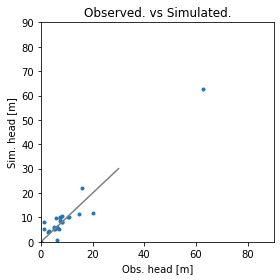

Error is - 3.1931017842571503
Params are - [3.36361446e+00 3.92298067e+01 1.08756100e-03 1.84358876e+01
 3.69154211e+00 3.30768309e-01 9.61831705e-04 4.39233996e-01
 9.09768138e-01 6.74749672e-01 2.94476922e-03]


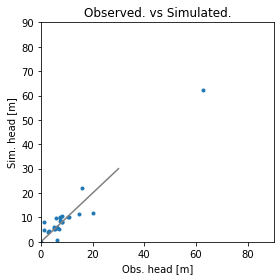

Error is - 3.1928847027017992
Params are - [3.36438026e+00 3.92532170e+01 1.08311330e-03 1.89116757e+01
 3.71315044e+00 3.07837393e-01 9.63254968e-04 4.42968556e-01
 9.17331879e-01 6.83549232e-01 2.87995722e-03]


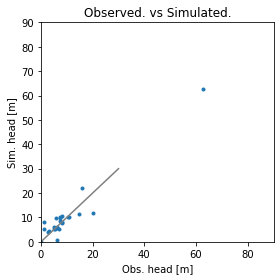

Error is - 3.1931052527561636
Params are - [3.35064628e+00 3.89346337e+01 1.10075310e-03 1.80527889e+01
 3.67591047e+00 3.65736703e-01 9.56251618e-04 4.28755736e-01
 9.03753651e-01 6.80887416e-01 2.99237998e-03]


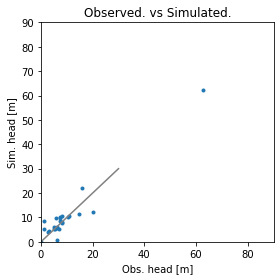

Error is - 3.192869549971815
Params are - [3.36503883e+00 3.92376604e+01 1.08752172e-03 1.82541539e+01
 3.61892352e+00 3.66524178e-01 9.66414209e-04 4.25714223e-01
 9.04627130e-01 6.78138451e-01 2.92297091e-03]


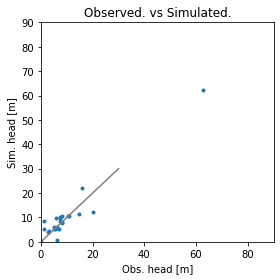

Error is - 3.1932689690903806
Params are - [3.36869371e+00 3.93020655e+01 1.08271707e-03 1.84504889e+01
 3.56817545e+00 3.79638221e-01 9.72363035e-04 4.17153248e-01
 9.05658858e-01 6.86122446e-01 2.85390279e-03]


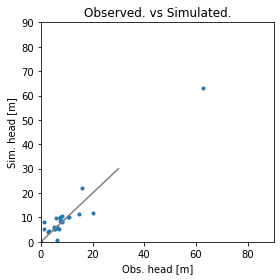

Error is - 3.1953243274863072
Params are - [3.44222016e+00 3.92989693e+01 1.10537523e-03 1.84075458e+01
 3.67300588e+00 2.83271218e-01 9.50695252e-04 4.35700274e-01
 9.05132423e-01 6.73854803e-01 2.97369230e-03]


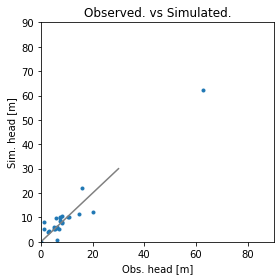

Error is - 3.193885760315244
Params are - [3.33071481e+00 3.91323351e+01 1.08675320e-03 1.79459626e+01
 3.66253362e+00 3.81899800e-01 9.64909529e-04 4.32739286e-01
 9.03123287e-01 6.69652475e-01 2.99112607e-03]


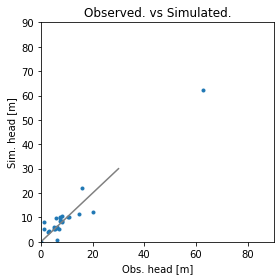

Error is - 3.194113938847902
Params are - [3.39756203e+00 3.90695038e+01 1.08159811e-03 1.81793651e+01
 3.66937310e+00 3.14753244e-01 9.69557761e-04 4.40351013e-01
 9.03555082e-01 6.68259078e-01 2.96018300e-03]


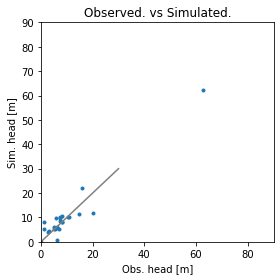

Error is - 3.1933346045913966
Params are - [3.34216434e+00 3.91378880e+01 1.08445392e-03 1.84837120e+01
 3.72000322e+00 3.40370253e-01 9.63980863e-04 4.28206421e-01
 9.11393908e-01 6.79813084e-01 2.94313751e-03]


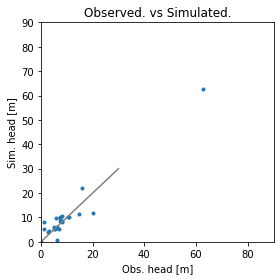

Error is - 3.193572228020334
Params are - [3.41611654e+00 3.90089313e+01 1.08635194e-03 1.88758951e+01
 3.68140818e+00 2.70231719e-01 9.56510610e-04 4.35784247e-01
 9.16658919e-01 6.78897065e-01 2.95161722e-03]


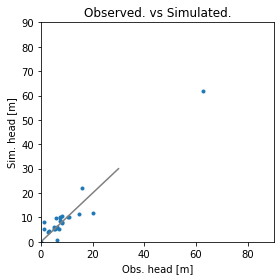

Error is - 3.1944742700204345
Params are - [3.35134382e+00 3.89915872e+01 1.08202951e-03 1.80741127e+01
 3.66365668e+00 3.61669834e-01 9.71710878e-04 4.33455744e-01
 9.15744425e-01 6.74561447e-01 2.92191196e-03]


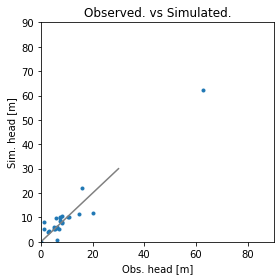

Error is - 3.193315979937592
Params are - [3.34410932e+00 3.89582697e+01 1.07912551e-03 1.83811260e+01
 3.65613116e+00 3.95444752e-01 9.65426112e-04 4.25358912e-01
 9.09254043e-01 6.81124012e-01 2.93991514e-03]


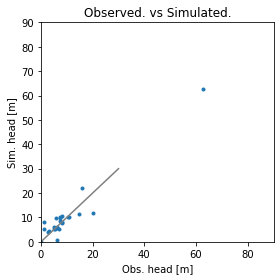

Error is - 3.1931805786380743
Params are - [3.31954886e+00 3.92440013e+01 1.07116355e-03 1.83442830e+01
 3.67635114e+00 3.93009033e-01 9.60077813e-04 4.23904614e-01
 9.10110000e-01 6.87491640e-01 2.95683012e-03]


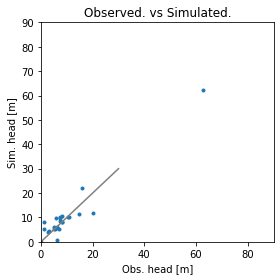

Error is - 3.191817811324388
Params are - [3.34491935e+00 3.92576005e+01 1.09189993e-03 1.88212572e+01
 3.66878997e+00 3.20303637e-01 9.67230091e-04 4.29782480e-01
 9.12398053e-01 6.91879786e-01 2.93004154e-03]


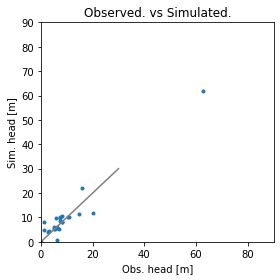

Error is - 3.191626506035098
Params are - [3.33206817e+00 3.93894325e+01 1.09885324e-03 1.93260205e+01
 3.66594502e+00 2.89274063e-01 9.71280032e-04 4.28414376e-01
 9.15946000e-01 7.06102114e-01 2.90232085e-03]


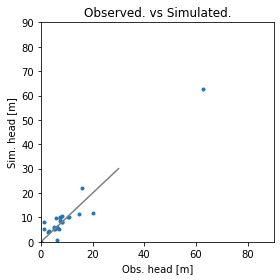

Error is - 3.1925445879434746
Params are - [3.36069258e+00 3.93322853e+01 1.09092259e-03 1.87864947e+01
 3.68002923e+00 3.27833722e-01 9.54571088e-04 4.27928812e-01
 9.01992436e-01 6.86488136e-01 2.99005048e-03]


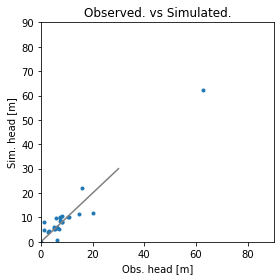

Error is - 3.1926438045035965
Params are - [3.35942959e+00 3.88933299e+01 1.08128923e-03 1.90291834e+01
 3.69850447e+00 3.15159737e-01 9.68973542e-04 4.36423451e-01
 9.15973228e-01 6.91851442e-01 2.82109710e-03]


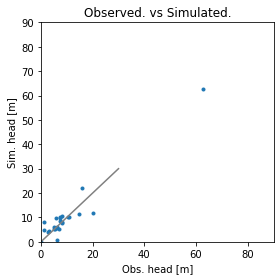

Error is - 3.1924732877672315
Params are - [3.30878517e+00 3.92072206e+01 1.09118394e-03 1.89826887e+01
 3.68497063e+00 3.67668821e-01 9.56196855e-04 4.20776012e-01
 9.16474824e-01 6.99740025e-01 2.91098111e-03]


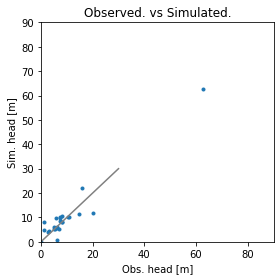

Error is - 3.1906638243396905
Params are - [3.37164518e+00 3.91580048e+01 1.08683445e-03 1.94045869e+01
 3.69588956e+00 2.97934813e-01 9.59260964e-04 4.26212598e-01
 9.19334171e-01 7.03817091e-01 2.86546623e-03]


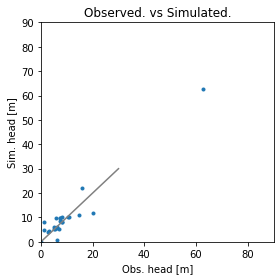

Error is - 3.1898776557055015
Params are - [3.39211037e+00 3.91708397e+01 1.08687508e-03 2.01338990e+01
 3.71256752e+00 2.55952320e-01 9.56436681e-04 4.22949253e-01
 9.27439614e-01 7.20899399e-01 2.80263630e-03]


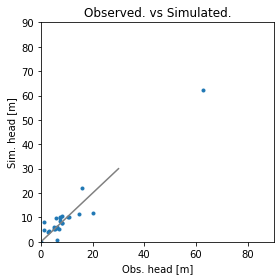

Error is - 3.1938554460498803
Params are - [3.28187869e+00 3.93108466e+01 1.08733083e-03 1.87033823e+01
 3.68268034e+00 4.07006640e-01 9.67646442e-04 4.20834001e-01
 9.07758665e-01 7.02209290e-01 2.87788764e-03]


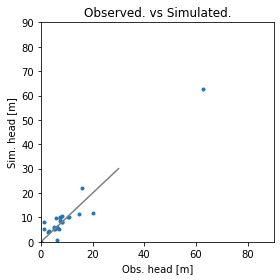

Error is - 3.192078849707857
Params are - [3.38255708e+00 3.90844101e+01 1.08659666e-03 1.88327669e+01
 3.68172622e+00 3.04425449e-01 9.59294568e-04 4.32046686e-01
 9.14433856e-01 6.84725121e-01 2.93318483e-03]


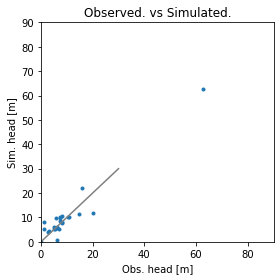

Error is - 3.190477915065454
Params are - [3.36317502e+00 3.91721666e+01 1.08961843e-03 1.91590300e+01
 3.63712584e+00 3.30332687e-01 9.59324134e-04 4.29110058e-01
 9.13576394e-01 7.02186369e-01 2.88455777e-03]


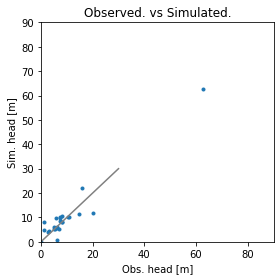

Error is - 3.1906793484635725
Params are - [3.36469654e+00 3.93906753e+01 1.09685464e-03 1.94030530e+01
 3.69754238e+00 2.63419631e-01 9.56769435e-04 4.32639593e-01
 9.16502141e-01 7.04704960e-01 2.87771516e-03]


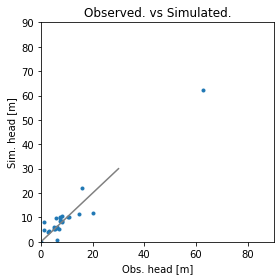

Error is - 3.190899529586389
Params are - [3.39746566e+00 3.91316116e+01 1.10948771e-03 1.96323997e+01
 3.68117536e+00 2.42293640e-01 9.61516210e-04 4.35682069e-01
 9.16808392e-01 7.01467027e-01 2.84641565e-03]


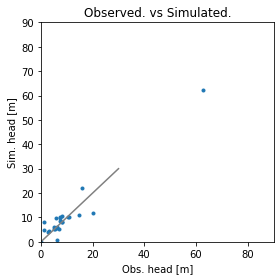

Error is - 3.19083028385388
Params are - [3.37488086e+00 3.94767934e+01 1.08148627e-03 2.02110957e+01
 3.68257328e+00 2.47121777e-01 9.66299604e-04 4.32090280e-01
 9.25538329e-01 7.11812998e-01 2.78432681e-03]


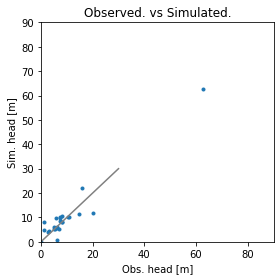

Error is - 3.1889794708601324
Params are - [3.36305608e+00 3.91988603e+01 1.09883025e-03 1.95884671e+01
 3.63977383e+00 2.93981884e-01 9.59849825e-04 4.15899591e-01
 9.13452183e-01 7.14290049e-01 2.87936222e-03]


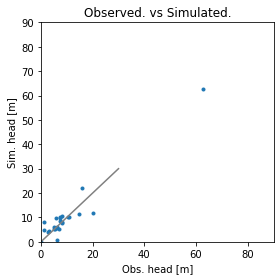

Error is - 3.187715627957206
Params are - [3.36239399e+00 3.91716820e+01 1.10668872e-03 1.99268628e+01
 3.60308553e+00 2.87054129e-01 9.58147253e-04 4.02365109e-01
 9.11512335e-01 7.29660457e-01 2.87906472e-03]


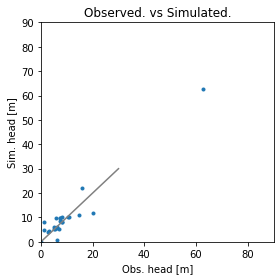

Error is - 3.1899599906192995
Params are - [3.36191663e+00 3.92024208e+01 1.09790673e-03 2.05501178e+01
 3.73112111e+00 2.20846000e-01 9.55187501e-04 4.28908631e-01
 9.27408787e-01 7.29068467e-01 2.82836559e-03]


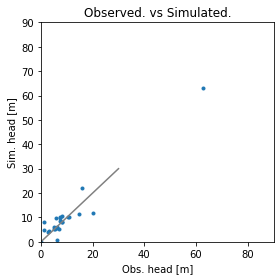

Error is - 3.189905031636908
Params are - [3.36797806e+00 3.96029498e+01 1.10716059e-03 2.00516219e+01
 3.65747046e+00 2.55062489e-01 9.50121614e-04 4.16833072e-01
 9.18141883e-01 7.22122207e-01 2.93156095e-03]


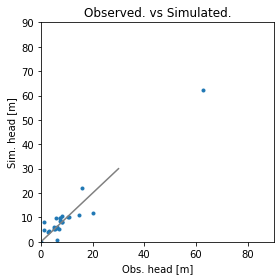

Error is - 3.18889825217699
Params are - [3.36803970e+00 3.92132060e+01 1.10047959e-03 2.05243337e+01
 3.67184411e+00 2.29157370e-01 9.63715074e-04 4.23310304e-01
 9.35058938e-01 7.33964436e-01 2.75197311e-03]


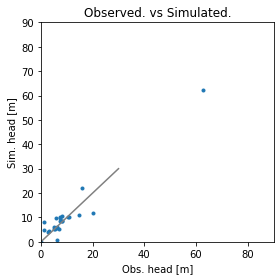

Error is - 3.1907270382124437
Params are - [3.43072066e+00 3.93393589e+01 1.10190836e-03 2.06084388e+01
 3.66451607e+00 1.64138371e-01 9.63456255e-04 4.30923885e-01
 9.23955479e-01 7.26935167e-01 2.80213193e-03]


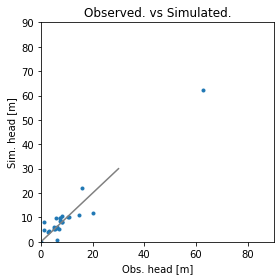

Error is - 3.1868098796693616
Params are - [3.36570577e+00 3.95085238e+01 1.10927959e-03 2.10812100e+01
 3.66463136e+00 2.01875001e-01 9.61115213e-04 4.19449065e-01
 9.27727652e-01 7.49624624e-01 2.75610042e-03]


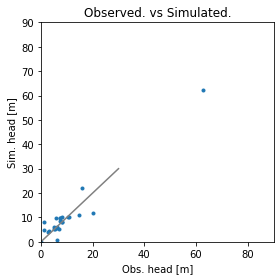

Error is - 3.185135207923778
Params are - [3.35728012e+00 3.97205807e+01 1.12062105e-03 2.22054315e+01
 3.65608394e+00 1.50599777e-01 9.62025536e-04 4.13150255e-01
 9.34374550e-01 7.82074376e-01 2.66755822e-03]


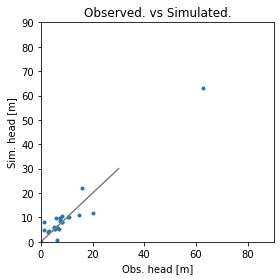

Error is - 3.189316768386082
Params are - [3.42077867e+00 3.92637102e+01 1.10098079e-03 2.11114856e+01
 3.67861963e+00 1.91812881e-01 9.47447113e-04 4.20306080e-01
 9.29566153e-01 7.42060770e-01 2.74428028e-03]


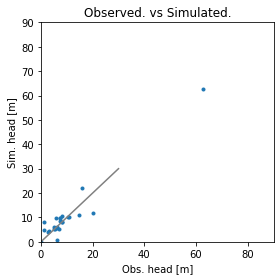

Error is - 3.1868286609817984
Params are - [3.35961991e+00 3.95455490e+01 1.08879961e-03 2.10740312e+01
 3.66292462e+00 2.29614983e-01 9.54652917e-04 4.10242753e-01
 9.31023354e-01 7.54076538e-01 2.78161541e-03]


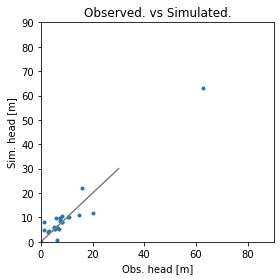

Error is - 3.187737248972616
Params are - [3.37942998e+00 3.92128683e+01 1.11813075e-03 2.06522325e+01
 3.65795421e+00 2.21603793e-01 9.47751944e-04 4.09862264e-01
 9.23290694e-01 7.51414847e-01 2.84321127e-03]


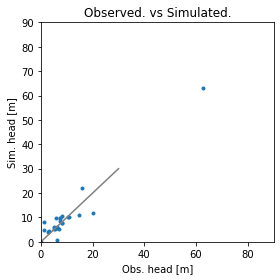

Error is - 3.1911691407646696
Params are - [3.31426461e+00 3.93273044e+01 1.10065819e-03 2.02628519e+01
 3.67481836e+00 3.15035458e-01 9.47739963e-04 4.07199274e-01
 9.24752674e-01 7.40743529e-01 2.83287512e-03]


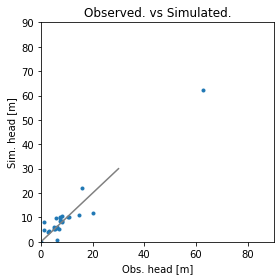

Error is - 3.1883817717878764
Params are - [3.40160665e+00 3.93363453e+01 1.10159582e-03 2.05220421e+01
 3.66709164e+00 2.01862643e-01 9.59527182e-04 4.24992732e-01
 9.24154778e-01 7.30387257e-01 2.80981773e-03]


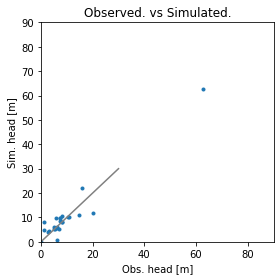

Error is - 3.1850852908296865
Params are - [3.38699966e+00 3.92661099e+01 1.10657394e-03 2.16716903e+01
 3.63625555e+00 2.04562019e-01 9.54928192e-04 4.04093228e-01
 9.33597400e-01 7.67643245e-01 2.74494691e-03]


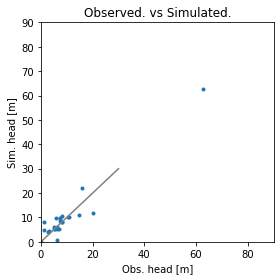

Error is - 3.182774556588393
Params are - [3.39815123e+00 3.92038272e+01 1.11143358e-03 2.28060089e+01
 3.60561213e+00 1.75133212e-01 9.54007570e-04 3.89820045e-01
 9.42145030e-01 7.99112387e-01 2.67856278e-03]


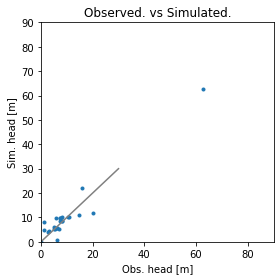

Error is - 3.1873351759899244
Params are - [3.39488048e+00 3.94903750e+01 1.11777653e-03 2.25788004e+01
 3.69094232e+00 1.09430876e-01 9.51406845e-04 4.00479124e-01
 9.41717446e-01 7.87784748e-01 2.70065066e-03]


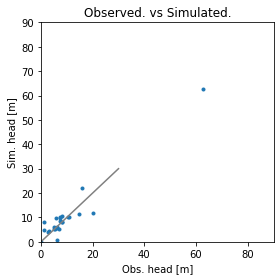

Error is - 3.1839745958520016
Params are - [3.40213230e+00 3.95124761e+01 1.11310093e-03 2.15565639e+01
 3.58964181e+00 1.98660268e-01 9.54856086e-04 3.95511549e-01
 9.30486626e-01 7.71578337e-01 2.73362194e-03]


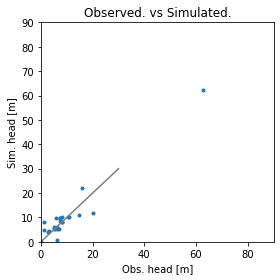

Error is - 3.184603204672926
Params are - [3.40228074e+00 3.90954974e+01 1.10492713e-03 2.23286857e+01
 3.65095999e+00 1.54188830e-01 9.60782786e-04 4.03710467e-01
 9.41998029e-01 7.87516620e-01 2.59443767e-03]


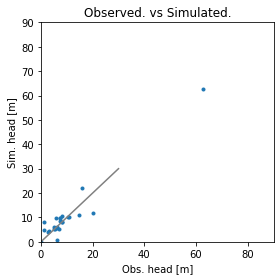

Error is - 3.181635856245473
Params are - [3.37999759e+00 3.95139089e+01 1.12849484e-03 2.26454606e+01
 3.58466155e+00 1.34796546e-01 9.55257920e-04 3.94096325e-01
 9.35347283e-01 8.00851650e-01 2.68550802e-03]


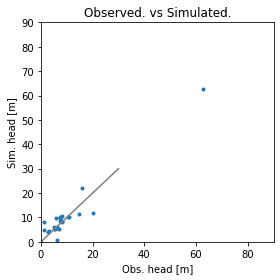

Error is - 3.1784027256223615
Params are - [3.37394120e+00 3.96854435e+01 1.14930472e-03 2.39012415e+01
 3.52070857e+00 7.42186584e-02 9.54668539e-04 3.79669861e-01
 9.39301118e-01 8.40827776e-01 2.62694389e-03]


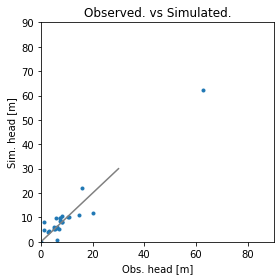

Error is - 3.182788733783524
Params are - [3.34281339e+00 3.94977172e+01 1.12317529e-03 2.21751024e+01
 3.58989834e+00 1.77555217e-01 9.65560475e-04 3.89351095e-01
 9.34990737e-01 7.97647917e-01 2.72253016e-03]


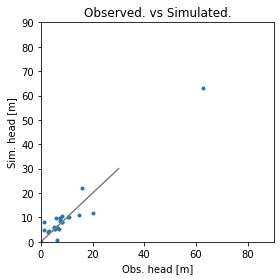

Error is - 3.1809628357563358
Params are - [3.39096575e+00 3.95999507e+01 1.12780298e-03 2.30623941e+01
 3.58177464e+00 1.30828519e-01 9.49628041e-04 3.80172470e-01
 9.29485553e-01 8.17323066e-01 2.70948406e-03]


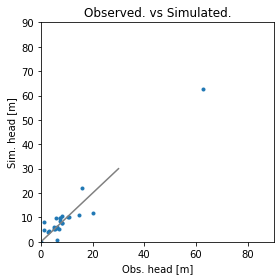

Error is - 3.180003626665954
Params are - [3.35546410e+00 3.95247396e+01 1.13145169e-03 2.35265679e+01
 3.57101492e+00 1.45207951e-01 9.52016089e-04 3.70340903e-01
 9.41358944e-01 8.36706755e-01 2.63339696e-03]


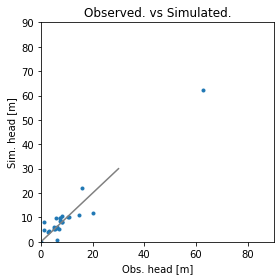

Error is - 3.180207435591776
Params are - [3.37328333e+00 3.97049205e+01 1.11733874e-03 2.39189839e+01
 3.56434521e+00 1.11576647e-01 9.64566626e-04 3.78285669e-01
 9.45508165e-01 8.31186786e-01 2.56185536e-03]


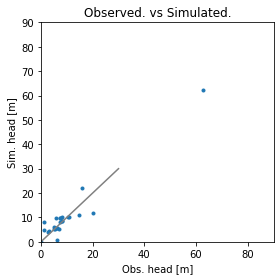

Error is - 3.1837590271993306
Params are - [3.39229920e+00 3.98430592e+01 1.13071714e-03 2.53701938e+01
 3.61217020e+00 1.42213143e-02 9.55338476e-04 3.81404744e-01
 9.63467583e-01 8.71400507e-01 2.46832748e-03]


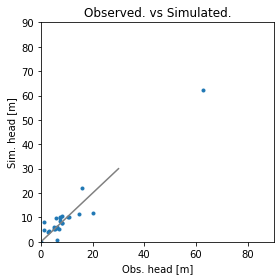

Error is - 3.179466562017011
Params are - [3.35934338e+00 3.95884906e+01 1.12198217e-03 2.32257823e+01
 3.50999120e+00 1.74533738e-01 9.62793726e-04 3.79822660e-01
 9.37217044e-01 8.28479082e-01 2.60450096e-03]


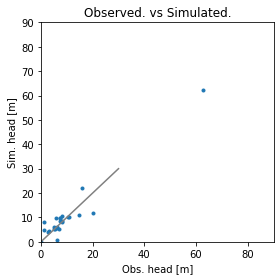

Error is - 3.176124497046167
Params are - [3.39455368e+00 3.95411242e+01 1.15699228e-03 2.51217790e+01
 3.51020283e+00 4.43348587e-02 9.61027801e-04 3.64528105e-01
 9.49037260e-01 8.75715028e-01 2.49133358e-03]


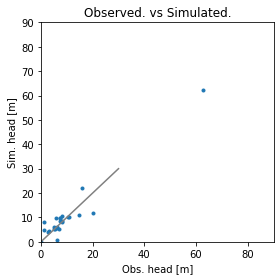

Error is - 3.176124497046167
Params are - [ 3.41202057e+00  3.95389118e+01  1.19108862e-03  2.71456529e+01
  3.43384193e+00 -4.83052035e-02  9.64215243e-04  3.41670781e-01
  9.58044214e-01  9.36534272e-01  2.34619267e-03]


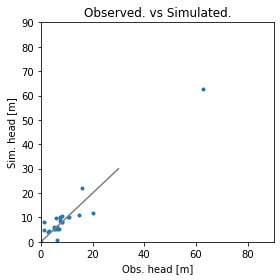

Error is - 3.1762334846361813
Params are - [3.40367048e+00 3.93334640e+01 1.13178379e-03 2.45206236e+01
 3.49051967e+00 1.04029171e-01 9.53473776e-04 3.52780212e-01
 9.48352012e-01 8.64742763e-01 2.57334994e-03]


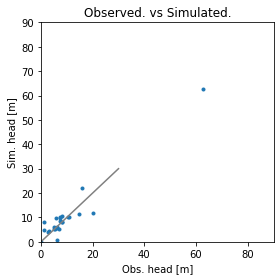

Error is - 3.17512610712929
Params are - [3.35892254e+00 4.00018140e+01 1.15236074e-03 2.47959036e+01
 3.46647265e+00 9.13201798e-02 9.53387615e-04 3.52959953e-01
 9.41883802e-01 8.73341635e-01 2.64263635e-03]


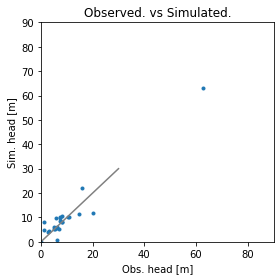

Error is - 3.1725306689090598
Params are - [3.33724344e+00 4.04549723e+01 1.17607755e-03 2.60295126e+01
 3.37422899e+00 5.98858546e-02 9.49690030e-04 3.27584696e-01
 9.41826688e-01 9.16254142e-01 2.66673568e-03]


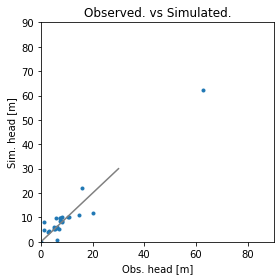

Error is - 3.1733204832086503
Params are - [3.34727300e+00 3.97561982e+01 1.15563724e-03 2.63812888e+01
 3.48862486e+00 2.16170302e-02 9.58375032e-04 3.48808535e-01
 9.55457035e-01 9.15584610e-01 2.49129094e-03]


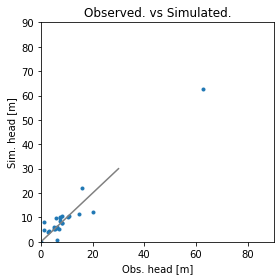

Error is - 3.1805645583564384
Params are - [3.34891952e+00 3.94098222e+01 1.14255195e-03 2.27514944e+01
 3.44363368e+00 2.07400660e-01 9.58444743e-04 3.56988756e-01
 9.21019614e-01 8.23795913e-01 2.76076058e-03]


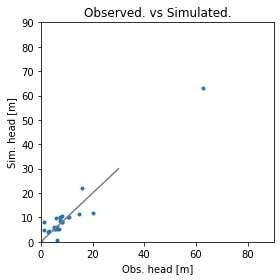

Error is - 3.1742858033723707
Params are - [3.39951554e+00 3.97391834e+01 1.15361684e-03 2.60513844e+01
 3.43931196e+00 4.94932009e-02 9.46928975e-04 3.43158343e-01
 9.46956256e-01 9.02302684e-01 2.51350889e-03]


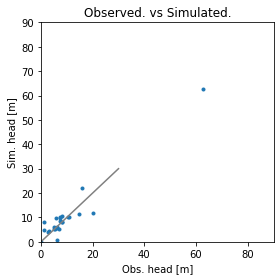

Error is - 3.170244353010731
Params are - [3.34442576e+00 4.01304109e+01 1.17302823e-03 2.60105460e+01
 3.39336178e+00 2.90715671e-02 9.57194863e-04 3.34205448e-01
 9.40676732e-01 9.19600087e-01 2.52746646e-03]


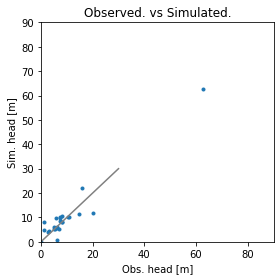

Error is - 3.170244353010731
Params are - [ 3.31756303e+00  4.05937027e+01  1.20382556e-03  2.76128146e+01
  3.28723661e+00 -4.39592556e-02  9.58788510e-04  3.06398149e-01
  9.39942582e-01  9.79843936e-01  2.45191831e-03]


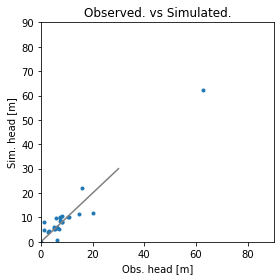

Error is - 3.1706503515044444
Params are - [3.34314942e+00 3.98307347e+01 1.16488161e-03 2.62901885e+01
 3.38294239e+00 5.48749969e-02 9.62950177e-04 3.35495382e-01
 9.55370969e-01 9.19985229e-01 2.46345107e-03]


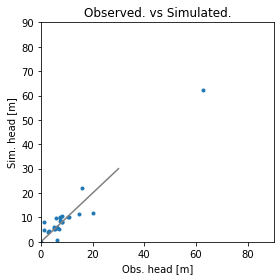

Error is - 3.1706503515044444
Params are - [ 3.38414654e+00  4.00973927e+01  1.15419257e-03  2.72444872e+01
  3.51004857e+00 -4.94290826e-02  9.54952645e-04  3.54771210e-01
  9.70082608e-01  9.31001349e-01  2.35811828e-03]


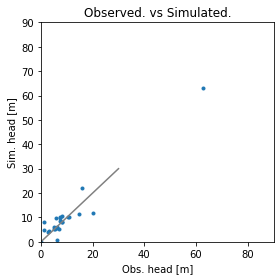

Error is - 3.170929160620833
Params are - [3.36175786e+00 3.98736529e+01 1.18610647e-03 2.66816346e+01
 3.37946492e+00 1.71211613e-02 9.47082765e-04 3.29198941e-01
 9.50062138e-01 9.41758579e-01 2.51998039e-03]


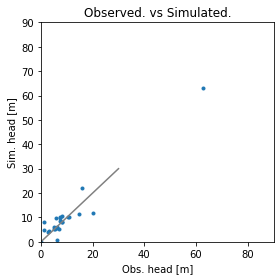

Error is - 3.170929160620833
Params are - [ 3.38072141e+00  4.01172726e+01  1.18193076e-03  2.76476991e+01
  3.33796794e+00 -3.97986496e-02  9.58736335e-04  3.29663350e-01
  9.55793757e-01  9.55338941e-01  2.42781760e-03]


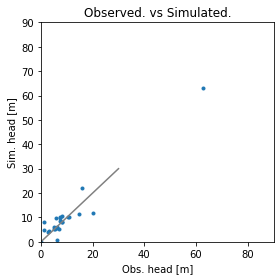

Error is - 3.170929160620833
Params are - [ 3.38072904e+00  4.01496638e+01  1.20230002e-03  2.87524696e+01
  3.36771470e+00 -1.08093962e-01  9.47220990e-04  3.11061719e-01
  9.63313242e-01  9.86632042e-01  2.42458935e-03]


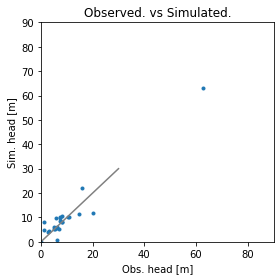

Error is - 3.170929160620833
Params are - [ 3.36736537e+00  4.01371147e+01  1.18461299e-03  2.89590519e+01
  3.32918027e+00 -4.09266317e-02  9.53992077e-04  2.98740310e-01
  9.65595009e-01  1.00079322e+00  2.36535470e-03]


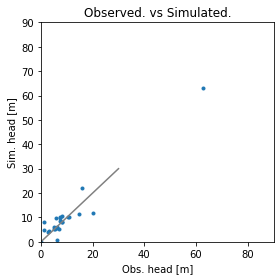

Error is - 3.170929160620833
Params are - [ 3.33103517e+00  4.06352124e+01  1.21173922e-03  2.91466567e+01
  3.33003473e+00 -9.70927452e-02  9.55281077e-04  3.15804523e-01
  9.59679205e-01  1.00161467e+00  2.38113133e-03]


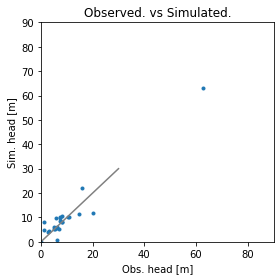

Error is - 3.170929160620833
Params are - [ 3.32860314e+00  4.06264774e+01  1.19648472e-03  2.92772973e+01
  3.27759374e+00 -6.31125424e-02  9.46682193e-04  2.95197797e-01
  9.60928856e-01  1.01353325e+00  2.44311091e-03]


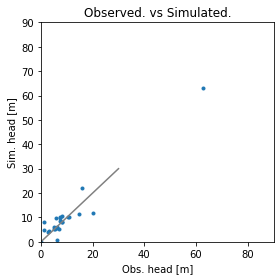

Error is - 3.170929160620833
Params are - [ 3.31074812e+00  4.05897444e+01  1.20765432e-03  2.89342215e+01
  3.31908129e+00 -8.87446561e-02  9.60736149e-04  3.07847459e-01
  9.65550333e-01  1.00716934e+00  2.40813597e-03]


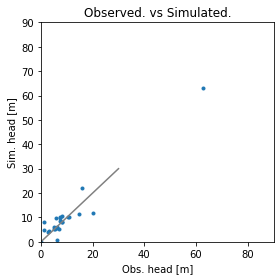

Error is - 3.170929160620833
Params are - [ 3.35634978e+00  4.07242833e+01  1.21509157e-03  2.90684867e+01
  3.23894229e+00 -8.09342465e-02  9.49719387e-04  2.94749799e-01
  9.58884699e-01  1.01053918e+00  2.41523483e-03]


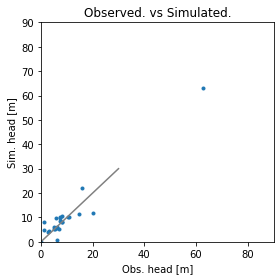

Error is - 3.170929160620833
Params are - [ 3.36985322e+00  4.00744750e+01  1.20174472e-03  2.99728036e+01
  3.32874058e+00 -1.44806726e-01  9.58409725e-04  3.10003656e-01
  9.75616502e-01  1.02701238e+00  2.19406266e-03]


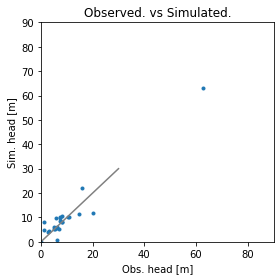

Error is - 3.170929160620833
Params are - [ 3.36170077e+00  4.01695993e+01  1.19532793e-03  2.89869808e+01
  3.34011268e+00 -9.36335806e-02  9.56229802e-04  3.14398916e-01
  9.67169049e-01  9.99322823e-01  2.31223092e-03]


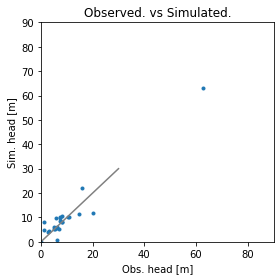

Error is - 3.1695208935780714
Params are - [3.34539588e+00 4.03598479e+01 1.18249434e-03 2.70153354e+01
 3.36285689e+00 8.71270956e-03 9.51869954e-04 3.23189436e-01
 9.50274142e-01 9.43943702e-01 2.54856743e-03]


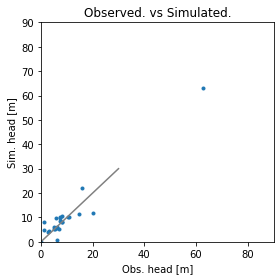

Error is - 3.1725306689090598
Params are - [3.33724344e+00 4.04549723e+01 1.17607755e-03 2.60295126e+01
 3.37422899e+00 5.98858546e-02 9.49690030e-04 3.27584696e-01
 9.41826688e-01 9.16254142e-01 2.66673568e-03]


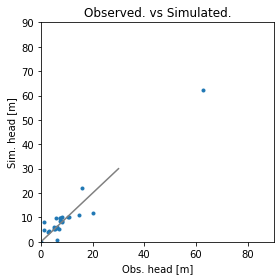

Error is - 3.173337237144029
Params are - [3.34875526e+00 3.97389029e+01 1.15680393e-03 2.65605293e+01
 3.48655720e+00 1.23128220e-02 9.58771382e-04 3.48009396e-01
 9.56992936e-01 9.20619076e-01 2.46980580e-03]


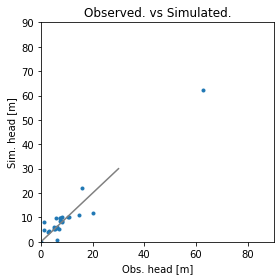

Error is - 3.173337237144029
Params are - [ 3.35445115e+00  4.04779382e+01  1.20051966e-03  2.84414973e+01
  3.30084602e+00 -5.76224794e-02  9.51982385e-04  3.08064698e-01
  9.58411758e-01  9.88059155e-01  2.42887758e-03]


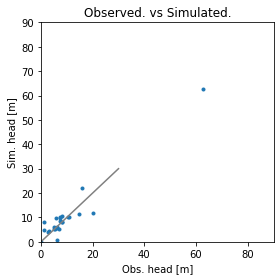

Error is - 3.169777998538883
Params are - [3.34491082e+00 4.02451294e+01 1.17776129e-03 2.65129407e+01
 3.37810933e+00 1.88921383e-02 9.54532409e-04 3.28697442e-01
 9.45475437e-01 9.31771894e-01 2.53801695e-03]


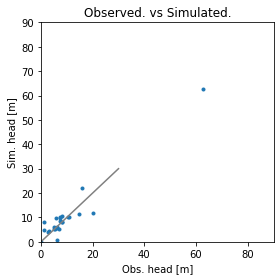

Error is - 3.1694542133679997
Params are - [3.34427265e+00 4.00952913e+01 1.17368797e-03 2.66527619e+01
 3.37289964e+00 3.17938532e-02 9.57410066e-04 3.29342409e-01
 9.52822555e-01 9.31964466e-01 2.50600925e-03]


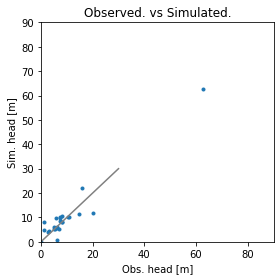

Error is - 3.1694542133679997
Params are - [ 3.36477121e+00  4.02286203e+01  1.16834345e-03  2.71299113e+01
  3.43645273e+00 -2.03581865e-02  9.53411299e-04  3.38980323e-01
  9.60178375e-01  9.37472526e-01  2.45334286e-03]


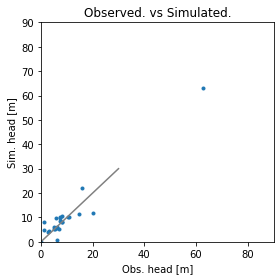

Error is - 3.1701349654639737
Params are - [3.35357687e+00 4.01167504e+01 1.18430041e-03 2.68484850e+01
 3.37116091e+00 1.29169354e-02 9.49476360e-04 3.26194189e-01
 9.50168140e-01 9.42851141e-01 2.53427391e-03]


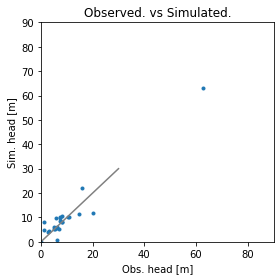

Error is - 3.1701349654639737
Params are - [ 3.36305865e+00  4.02385603e+01  1.18221255e-03  2.73315173e+01
  3.35041241e+00 -1.55429700e-02  9.55303144e-04  3.26426393e-01
  9.53033950e-01  9.49641321e-01  2.48819252e-03]


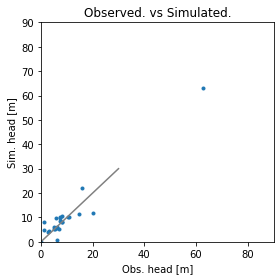

Error is - 3.1701349654639737
Params are - [ 3.36306246e+00  4.02547559e+01  1.19239718e-03  2.78839025e+01
  3.36528580e+00 -4.96906262e-02  9.49545472e-04  3.17125578e-01
  9.56793692e-01  9.65287872e-01  2.48657839e-03]


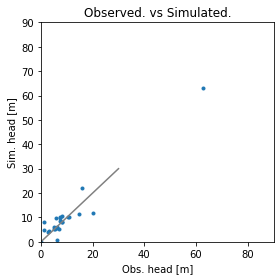

Error is - 3.1701349654639737
Params are - [ 3.35638063e+00  4.02484813e+01  1.18355366e-03  2.79871936e+01
  3.34601858e+00 -1.61069611e-02  9.52931016e-04  3.10964873e-01
  9.57934575e-01  9.72368459e-01  2.45696106e-03]


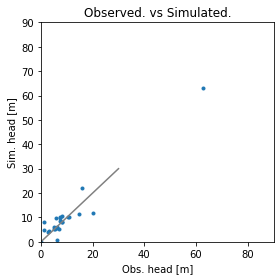

Error is - 3.1701349654639737
Params are - [ 3.33821552e+00  4.04975302e+01  1.19711678e-03  2.80809960e+01
  3.34644581e+00 -4.41900178e-02  9.53575515e-04  3.19496979e-01
  9.54976673e-01  9.72779189e-01  2.46484938e-03]


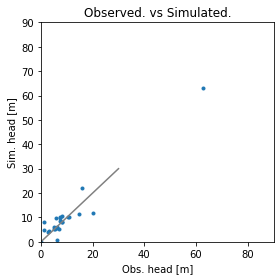

Error is - 3.1701349654639737
Params are - [ 3.33699951e+00  4.04931626e+01  1.18948953e-03  2.81463163e+01
  3.32022531e+00 -2.71999164e-02  9.49276073e-04  3.09193616e-01
  9.55601499e-01  9.78738479e-01  2.49583917e-03]


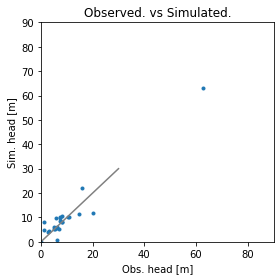

Error is - 3.1701349654639737
Params are - [ 3.32807200e+00  4.04747962e+01  1.19507433e-03  2.79747785e+01
  3.34096909e+00 -4.00159733e-02  9.56303052e-04  3.15518447e-01
  9.57912237e-01  9.75556520e-01  2.47835170e-03]


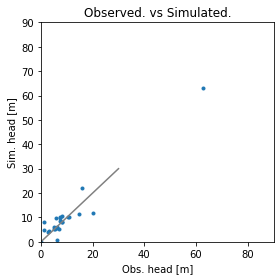

Error is - 3.1701349654639737
Params are - [ 3.35087283e+00  4.05420656e+01  1.19879295e-03  2.80419110e+01
  3.30089959e+00 -3.61107685e-02  9.50794670e-04  3.08969618e-01
  9.54579420e-01  9.77241442e-01  2.48190113e-03]


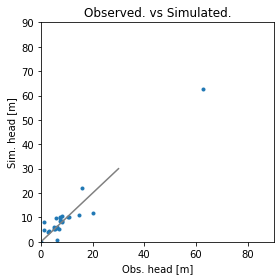

Error is - 3.170711583900406
Params are - [3.34707557e+00 4.00493754e+01 1.16964914e-03 2.67879323e+01
 3.42470704e+00 1.05127658e-02 9.55320668e-04 3.35599416e-01
 9.53633539e-01 9.32281389e-01 2.50918662e-03]


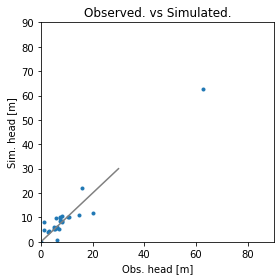

Error is - 3.170711583900406
Params are - [ 3.34992352e+00  4.04188931e+01  1.19150700e-03  2.77284164e+01
  3.33185145e+00 -2.44548849e-02  9.51926170e-04  3.15627067e-01
  9.54342950e-01  9.66001429e-01  2.48872250e-03]


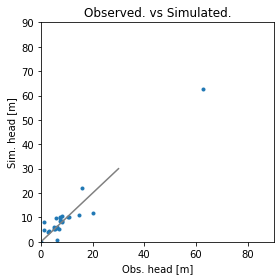

Error is - 3.170459738755273
Params are - [3.35452193e+00 4.01619558e+01 1.17101571e-03 2.68913366e+01
 3.40467618e+00 5.71783335e-03 9.55410682e-04 3.34161366e-01
 9.56500465e-01 9.34718496e-01 2.47967605e-03]


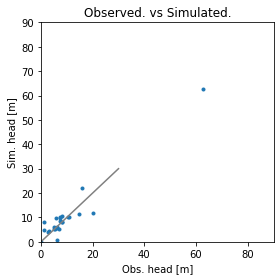

Error is - 3.1693189231550862
Params are - [3.34483427e+00 4.02275696e+01 1.17809116e-03 2.68340487e+01
 3.36787826e+00 2.02532814e-02 9.54640010e-04 3.26265923e-01
 9.51548348e-01 9.37954084e-01 2.52728834e-03]


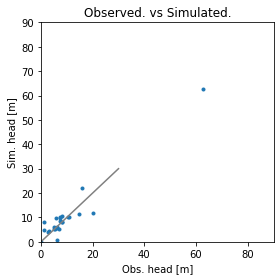

Error is - 3.1695355647585326
Params are - [3.34459173e+00 4.01702103e+01 1.17572463e-03 2.65828513e+01
 3.37550449e+00 2.53429958e-02 9.55971237e-04 3.29019926e-01
 9.49148996e-01 9.31868180e-01 2.52201310e-03]


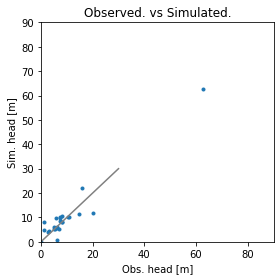

Error is - 3.169543806778582
Params are - [3.34892476e+00 4.01060209e+01 1.17899419e-03 2.67506235e+01
 3.37203027e+00 2.23553943e-02 9.53443213e-04 3.27768299e-01
 9.51495348e-01 9.37407803e-01 2.52014158e-03]


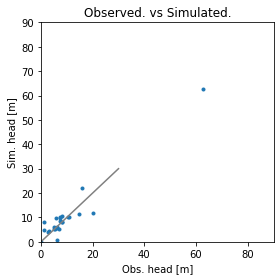

Error is - 3.1689605375259267
Params are - [3.35366565e+00 4.01669258e+01 1.17795026e-03 2.69921396e+01
 3.36165603e+00 8.12544160e-03 9.56356605e-04 3.27884401e-01
 9.52928252e-01 9.40802894e-01 2.49710088e-03]


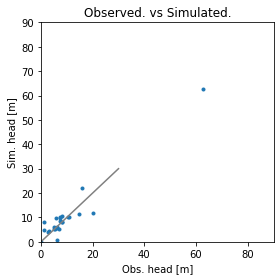

Error is - 3.1689605375259267
Params are - [ 3.35366756e+00  4.01750236e+01  1.18304258e-03  2.72683322e+01
  3.36909272e+00 -8.94838650e-03  9.53477769e-04  3.23233993e-01
  9.54808124e-01  9.48626169e-01  2.49629382e-03]


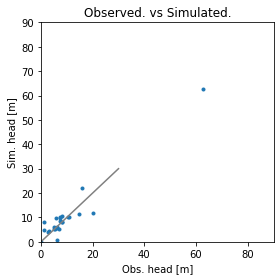

Error is - 3.1682325702419663
Params are - [3.35032664e+00 4.01718863e+01 1.17862082e-03 2.73199778e+01
 3.35945911e+00 7.84344610e-03 9.55170541e-04 3.20153641e-01
 9.55378565e-01 9.52166462e-01 2.48148516e-03]


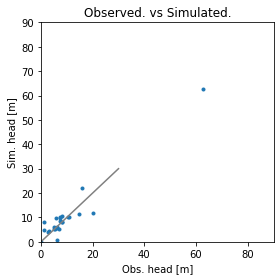

Error is - 3.1682325702419663
Params are - [ 3.34124409e+00  4.02964107e+01  1.18540238e-03  2.73668790e+01
  3.35967272e+00 -6.19808229e-03  9.55492790e-04  3.24419694e-01
  9.53899614e-01  9.52371827e-01  2.48542931e-03]


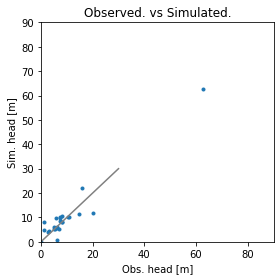

Error is - 3.1682820591952376
Params are - [3.34063608e+00 4.02942270e+01 1.18158875e-03 2.73995391e+01
 3.34656248e+00 2.29696842e-03 9.53343069e-04 3.19268013e-01
 9.54212027e-01 9.55351472e-01 2.50092421e-03]


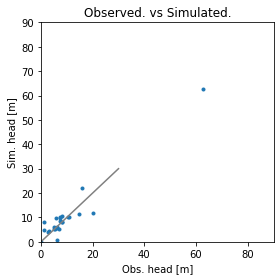

Error is - 3.1682820591952376
Params are - [ 3.33617233e+00  4.02850437e+01  1.18438115e-03  2.73137702e+01
  3.35693436e+00 -4.11106001e-03  9.56856559e-04  3.22430428e-01
  9.55367396e-01  9.53760493e-01  2.49218048e-03]


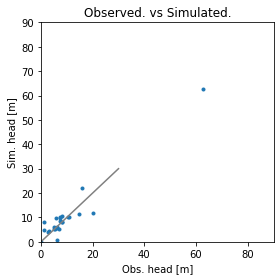

Error is - 3.1682820591952376
Params are - [ 3.34757274e+00  4.03186785e+01  1.18624046e-03  2.73473365e+01
  3.33689961e+00 -2.15845762e-03  9.54102368e-04  3.19156013e-01
  9.53700988e-01  9.54602954e-01  2.49395519e-03]


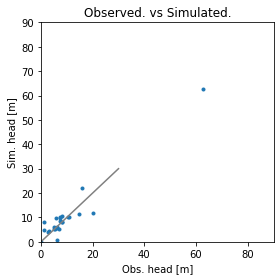

Error is - 3.167627118114048
Params are - [3.33746143e+00 4.02575511e+01 1.18966144e-03 2.72592561e+01
 3.31870376e+00 1.18449656e-02 9.54819177e-04 3.14737314e-01
 9.49919574e-01 9.55622741e-01 2.52447328e-03]


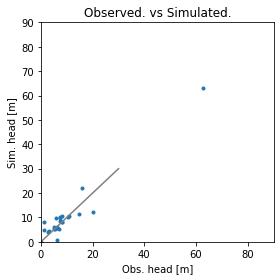

Error is - 3.167008266595606
Params are - [3.32893118e+00 4.03053487e+01 1.19898431e-03 2.74432158e+01
 3.27571755e+00 1.49085318e-02 9.54523424e-04 3.05025288e-01
 9.46629128e-01 9.66074864e-01 2.54687189e-03]


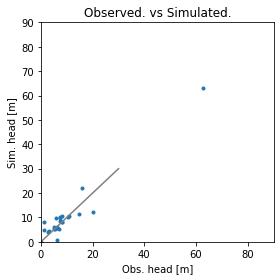

Error is - 3.167008266595606
Params are - [ 3.33942340e+00  4.03497274e+01  1.18531753e-03  2.75258951e+01
  3.33383827e+00 -6.14657035e-03  9.56983049e-04  3.16995288e-01
  9.54039924e-01  9.58145627e-01  2.48886781e-03]


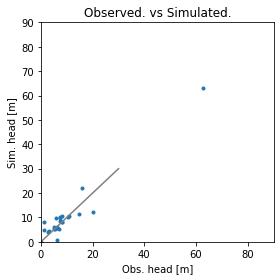

Error is - 3.167008266595606
Params are - [ 3.34281673e+00  4.03181774e+01  1.19033126e-03  2.78651298e+01
  3.32278838e+00 -1.48595475e-02  9.54638990e-04  3.13557364e-01
  9.57275535e-01  9.68462968e-01  2.48096987e-03]


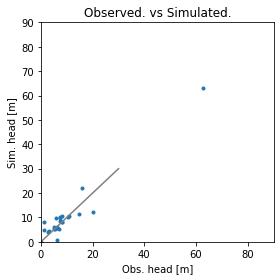

Error is - 3.167008266595606
Params are - [ 3.34287111e+00  4.04336212e+01  1.19539396e-03  2.80156496e+01
  3.31628209e+00 -2.97928414e-02  9.52696330e-04  3.10364872e-01
  9.54411609e-01  9.75002773e-01  2.49242111e-03]


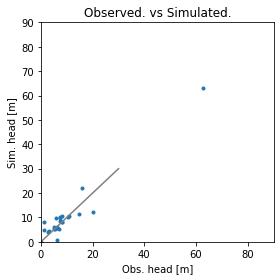

Error is - 3.167008266595606
Params are - [ 3.34195255e+00  4.03388068e+01  1.19413674e-03  2.80491995e+01
  3.31192234e+00 -2.73515646e-02  9.55112989e-04  3.10550259e-01
  9.56206409e-01  9.75749280e-01  2.46480252e-03]


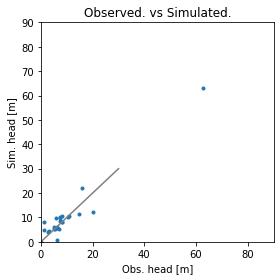

Error is - 3.167008266595606
Params are - [ 3.33098926e+00  4.04211316e+01  1.19120244e-03  2.77568918e+01
  3.30031327e+00 -1.49592912e-03  9.56572543e-04  3.11276054e-01
  9.53200867e-01  9.70008670e-01  2.49007135e-03]


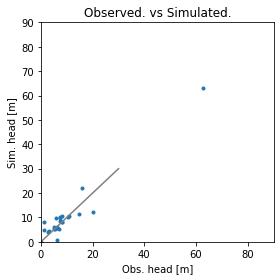

Error is - 3.167008266595606
Params are - [ 3.32686819e+00  4.04754486e+01  1.19870425e-03  2.81721303e+01
  3.29659673e+00 -2.03190973e-02  9.53732968e-04  3.03605947e-01
  9.55130305e-01  9.83142087e-01  2.48798619e-03]


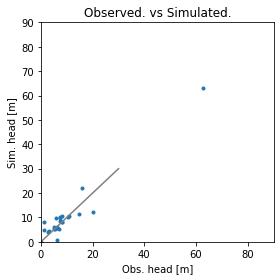

Error is - 3.167008266595606
Params are - [ 3.32919664e+00  4.03521996e+01  1.19268019e-03  2.79668959e+01
  3.31402535e+00 -1.33371326e-02  9.55920041e-04  3.09507050e-01
  9.54617445e-01  9.74530960e-01  2.49004661e-03]


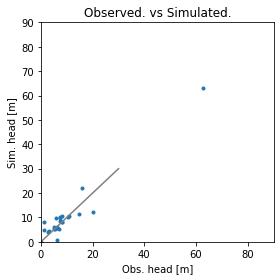

Error is - 3.167008266595606
Params are - [ 3.33932874e+00  4.03980445e+01  1.19604842e-03  2.81192123e+01
  3.28618896e+00 -1.30619980e-02  9.52995575e-04  3.03882930e-01
  9.52814682e-01  9.79149869e-01  2.49143334e-03]


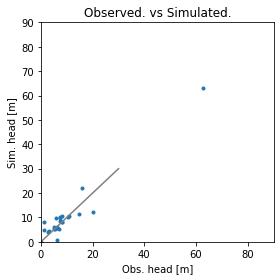

Error is - 3.167008266595606
Params are - [ 3.33462729e+00  4.04077372e+01  1.20146985e-03  2.81642930e+01
  3.28558384e+00 -2.22625658e-02  9.56445883e-04  3.04248058e-01
  9.53715988e-01  9.81885871e-01  2.48096400e-03]


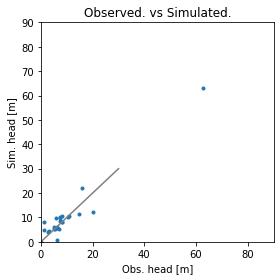

Error is - 3.167008266595606
Params are - [ 3.33281623e+00  4.04257946e+01  1.20057758e-03  2.83419375e+01
  3.25900289e+00 -1.66883302e-02  9.54469451e-04  2.95428806e-01
  9.53995014e-01  9.90231706e-01  2.49564702e-03]


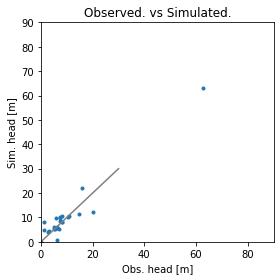

Error is - 3.167008266595606
Params are - [ 3.32054997e+00  4.05964842e+01  1.21135128e-03  2.85746496e+01
  3.24095174e+00 -3.51901816e-02  9.54664231e-04  2.95199434e-01
  9.52264509e-01  9.97358024e-01  2.50216606e-03]


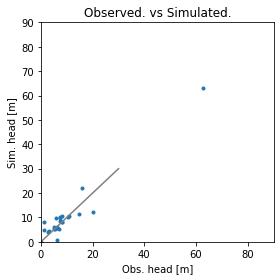

Error is - 3.167008266595606
Params are - [ 3.32799414e+00  4.04903347e+01  1.20316866e-03  2.82609816e+01
  3.27057858e+00 -2.44317747e-02  9.54790808e-04  3.01437986e-01
  9.53043023e-01  9.86060133e-01  2.49699583e-03]


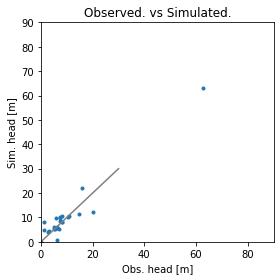

Error is - 3.167008266595606
Params are - [ 3.34288247e+00  4.02780358e+01  1.18680343e-03  2.76336457e+01
  3.32983227e+00 -2.91496082e-03  9.55043963e-04  3.13915089e-01
  9.54600051e-01  9.63464353e-01  2.48665538e-03]


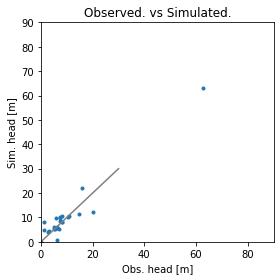

Error is - 3.167008266595606
Params are - [ 3.33171622e+00  4.04372600e+01  1.19907736e-03  2.81041477e+01
  3.28539200e+00 -1.90525712e-02  9.54854097e-04  3.04557262e-01
  9.53432280e-01  9.80411188e-01  2.49441072e-03]


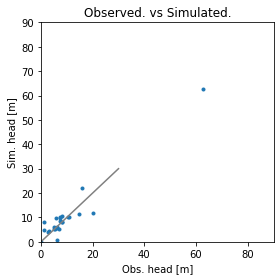

Error is - 3.1669546465772402
Params are - [3.33417729e+00 4.03275380e+01 1.19215092e-03 2.74845555e+01
 3.30477791e+00 4.38098072e-03 9.55753236e-04 3.11010288e-01
 9.50334526e-01 9.62110246e-01 2.51786985e-03]


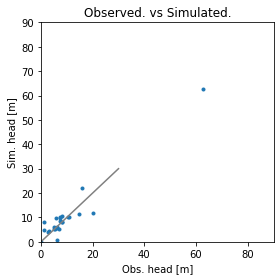

Error is - 3.16678636579706
Params are - [3.33587396e+00 4.03117630e+01 1.19465778e-03 2.76541728e+01
 3.29925296e+00 2.44921590e-05 9.54581207e-04 3.09291326e-01
 9.51952332e-01 9.67268916e-01 2.51392088e-03]


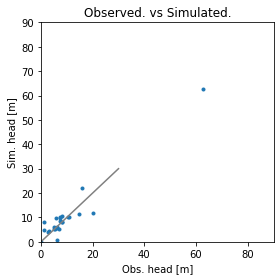

Error is - 3.16678636579706
Params are - [ 3.33590115e+00  4.03694849e+01  1.19718913e-03  2.77294327e+01
  3.29599982e+00 -7.44215482e-03  9.53609877e-04  3.07695080e-01
  9.50520369e-01  9.70538819e-01  2.51964650e-03]


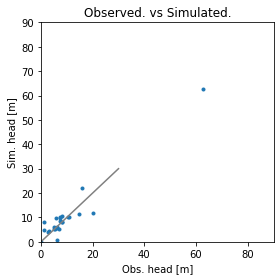

Error is - 3.16678636579706
Params are - [ 3.33544187e+00  4.03220777e+01  1.19656052e-03  2.77462076e+01
  3.29381994e+00 -6.22151642e-03  9.54818206e-04  3.07787773e-01
  9.51417768e-01  9.70912072e-01  2.50583720e-03]


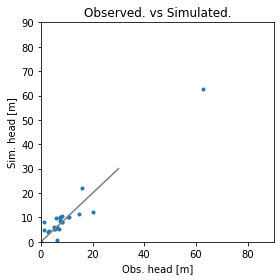

Error is - 3.166520607260909
Params are - [3.32996022e+00 4.03632401e+01 1.19509337e-03 2.76000538e+01
 3.28801541e+00 6.70630134e-03 9.55547983e-04 3.08150671e-01
 9.49914998e-01 9.68041767e-01 2.51847162e-03]


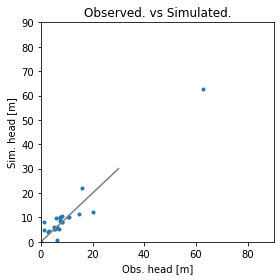

Error is - 3.166520607260909
Params are - [ 3.32789969e+00  4.03903986e+01  1.19884428e-03  2.78076730e+01
  3.28615714e+00 -2.70528278e-03  9.54128196e-04  3.04315617e-01
  9.50879716e-01  9.74608475e-01  2.51742904e-03]


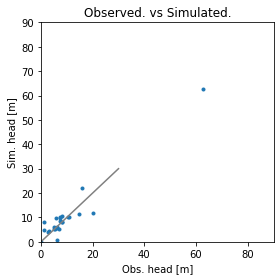

Error is - 3.1663989215696997
Params are - [3.32906391e+00 4.03287741e+01 1.19583225e-03 2.77050558e+01
 3.29487145e+00 7.85699581e-04 9.55221733e-04 3.07266169e-01
 9.50623287e-01 9.70302912e-01 2.51845925e-03]


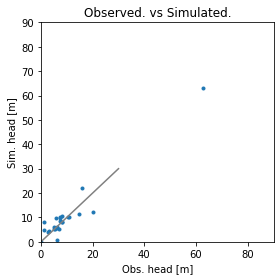

Error is - 3.1665535430330087
Params are - [3.33412996e+00 4.03516966e+01 1.19751636e-03 2.77812140e+01
 3.28095325e+00 9.23266903e-04 9.53759499e-04 3.04454109e-01
 9.49721905e-01 9.72612367e-01 2.51915262e-03]


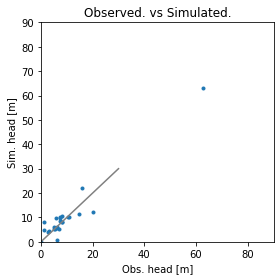

Error is - 3.1665535430330087
Params are - [ 3.33177924e+00  4.03565429e+01  1.20022708e-03  2.78037544e+01
  3.28065070e+00 -3.67701698e-03  9.55484653e-04  3.04636673e-01
  9.50172558e-01  9.73980368e-01  2.51391794e-03]


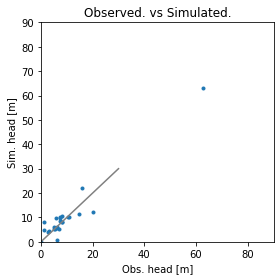

Error is - 3.1665535430330087
Params are - [ 3.33087371e+00  4.03655716e+01  1.19978094e-03  2.78925767e+01
  3.26736022e+00 -8.89899215e-04  9.54496438e-04  3.00227047e-01
  9.50312071e-01  9.78153285e-01  2.52125945e-03]


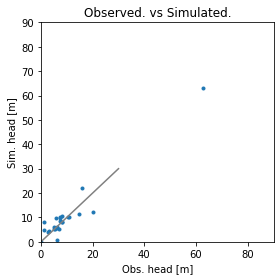

Error is - 3.1665535430330087
Params are - [ 3.32846266e+00  4.03978417e+01  1.20107648e-03  2.78520987e+01
  3.27314807e+00 -4.76162143e-03  9.54657116e-04  3.03231637e-01
  9.49836075e-01  9.76067499e-01  2.52193386e-03]


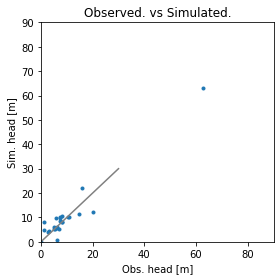

Error is - 3.1665535430330087
Params are - [ 3.33535312e+00  4.04010021e+01  1.19536644e-03  2.80216560e+01
  3.29973825e+00 -1.72497592e-02  9.54941693e-04  3.07350419e-01
  9.54404618e-01  9.76579086e-01  2.48729142e-03]


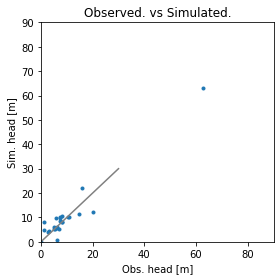

Error is - 3.1665535430330087
Params are - [ 3.33032079e+00  4.03921699e+01  1.20278447e-03  2.80779710e+01
  3.26976158e+00 -1.06550700e-02  9.53564328e-04  3.00699988e-01
  9.51439237e-01  9.83174403e-01  2.51073375e-03]


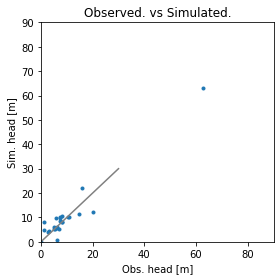

Error is - 3.1665535430330087
Params are - [ 3.32812511e+00  4.04103742e+01  1.19950649e-03  2.78766395e+01
  3.27634530e+00 -8.58673480e-04  9.54271380e-04  3.02633815e-01
  9.50359898e-01  9.76602091e-01  2.52365667e-03]


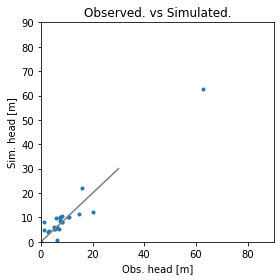

Error is - 3.1657635512411915
Params are - [3.32625201e+00 4.03704014e+01 1.19929922e-03 2.79201792e+01
 3.27059188e+00 1.55896152e-03 9.55599982e-04 3.01806278e-01
 9.51228121e-01 9.78077757e-01 2.51057650e-03]


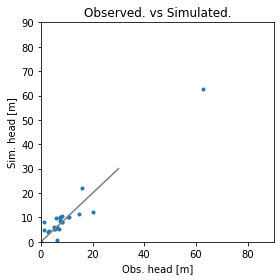

Error is - 3.16541436113674
Params are - [3.32142745e+00 4.03708597e+01 1.20035426e-03 2.80155525e+01
 3.25788791e+00 6.05951969e-03 9.56595035e-04 2.98861878e-01
 9.51581998e-01 9.81847226e-01 2.50604151e-03]


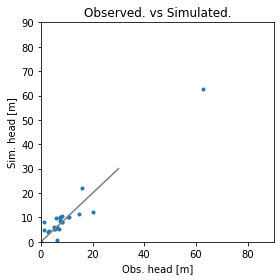

Error is - 3.16541436113674
Params are - [ 3.32365256e+00  4.04388682e+01  1.20286630e-03  2.80611446e+01
  3.25981781e+00 -4.81040772e-03  9.54994803e-04  2.98313769e-01
  9.49728825e-01  9.83998262e-01  2.51486951e-03]


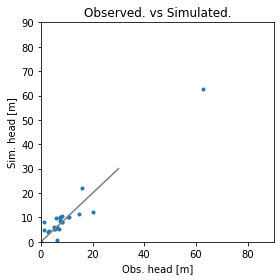

Error is - 3.16541436113674
Params are - [ 3.33058821e+00  4.03454377e+01  1.19862846e-03  2.78722243e+01
  3.27972048e+00 -4.64573922e-03  9.55436162e-04  3.04185817e-01
  9.51206518e-01  9.76009846e-01  2.50353605e-03]


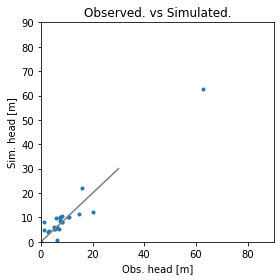

Error is - 3.1663441904107392
Params are - [3.32844116e+00 4.03551453e+01 1.19459484e-03 2.76334842e+01
 3.28811490e+00 6.24326287e-03 9.56483547e-04 3.06753431e-01
 9.50084867e-01 9.68134887e-01 2.51515030e-03]


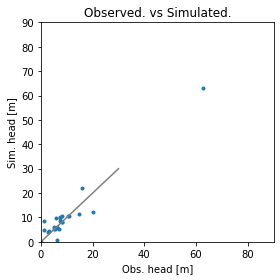

Error is - 3.166505311412545
Params are - [3.32215211e+00 4.03379754e+01 1.20187258e-03 2.76192225e+01
 3.25602491e+00 1.71094107e-02 9.55386519e-04 2.99994457e-01
 9.46334076e-01 9.73194895e-01 2.54365788e-03]


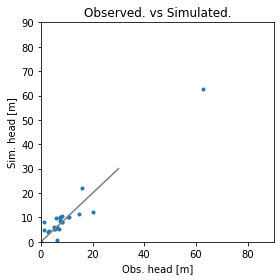

Error is - 3.166126789237988
Params are - [3.32789520e+00 4.03302511e+01 1.19630728e-03 2.77464387e+01
 3.27950179e+00 8.59782419e-03 9.55803714e-04 3.03524661e-01
 9.50265891e-01 9.73184190e-01 2.51296526e-03]


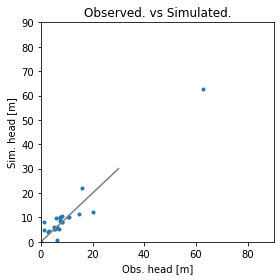

Error is - 3.1662357221683433
Params are - [3.32494260e+00 4.03560992e+01 1.19697125e-03 2.76793902e+01
 3.28749719e+00 6.45114259e-03 9.56202079e-04 3.07128817e-01
 9.49781499e-01 9.70194932e-01 2.51213163e-03]


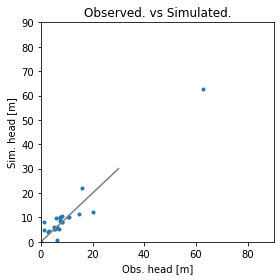

Error is - 3.166263684001313
Params are - [3.32279405e+00 4.03650473e+01 1.19593315e-03 2.77456008e+01
 3.27545153e+00 1.10797439e-02 9.55344305e-04 3.03172308e-01
 9.49849911e-01 9.73679588e-01 2.51914835e-03]


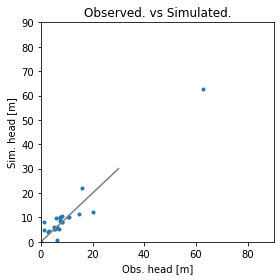

Error is - 3.165737484703484
Params are - [3.31838225e+00 4.03723210e+01 1.19835601e-03 2.77616661e+01
 3.27414866e+00 8.32609221e-03 9.57357605e-04 3.03121817e-01
 9.50323838e-01 9.75241630e-01 2.51391291e-03]


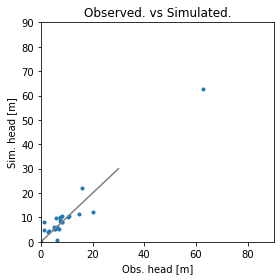

Error is - 3.1659102000731645
Params are - [3.32288208e+00 4.03303321e+01 1.19693932e-03 2.77268422e+01
 3.26676141e+00 1.39603464e-02 9.57576074e-04 3.03043254e-01
 9.49064957e-01 9.73360640e-01 2.51499719e-03]


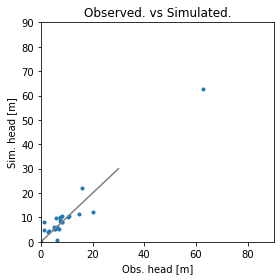

Error is - 3.165463005053826
Params are - [3.31953461e+00 4.03515074e+01 1.20102584e-03 2.79575138e+01
 3.26103878e+00 5.86767962e-03 9.56525031e-04 2.98279580e-01
 9.49875124e-01 9.80894416e-01 2.51332289e-03]


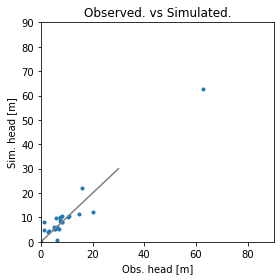

Error is - 3.165463005053826
Params are - [ 3.32686681e+00  4.03792324e+01  1.19409269e-03  2.79998526e+01
  3.29394089e+00 -6.57938084e-03  9.56893498e-04  3.06123998e-01
  9.54099872e-01  9.77141201e-01  2.48262118e-03]


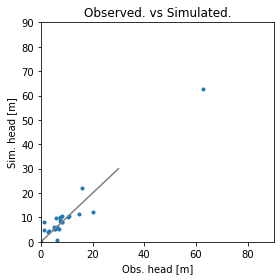

Error is - 3.165372265470271
Params are - [3.31955554e+00 4.03976079e+01 1.19981674e-03 2.79676187e+01
 3.25492516e+00 8.40522474e-03 9.57362241e-04 2.98644618e-01
 9.50442768e-01 9.81276510e-01 2.50130380e-03]


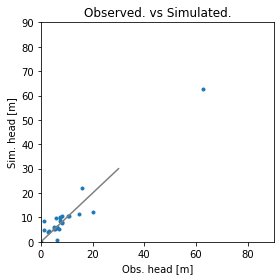

Error is - 3.1650662412669557
Params are - [3.31480136e+00 4.04320248e+01 1.20180898e-03 2.80989002e+01
 3.23495202e+00 1.22149873e-02 9.58432495e-04 2.94333843e-01
 9.50352509e-01 9.86763308e-01 2.49272608e-03]


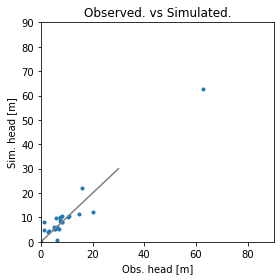

Error is - 3.1650854485899416
Params are - [3.31769833e+00 4.03852149e+01 1.20236580e-03 2.81238114e+01
 3.25201573e+00 4.03342953e-03 9.56454780e-04 2.96899250e-01
 9.51029850e-01 9.86831520e-01 2.50053562e-03]


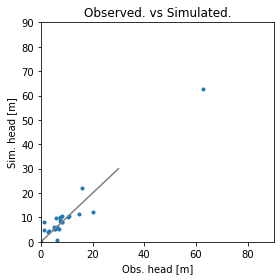

Error is - 3.1650854485899416
Params are - [ 3.32241894e+00  4.03789797e+01  1.20219707e-03  2.80804604e+01
  3.26041805e+00 -2.08419959e-03  9.57795927e-04  2.99339816e-01
  9.51479340e-01  9.83678079e-01  2.49315343e-03]


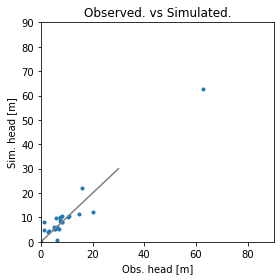

Error is - 3.164722843574287
Params are - [3.31981154e+00 4.03920879e+01 1.20210911e-03 2.82195928e+01
 3.24344891e+00 9.92521343e-04 9.57227943e-04 2.93967125e-01
 9.51856450e-01 9.89614217e-01 2.49671958e-03]


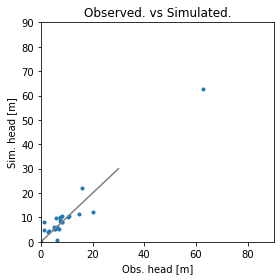

Error is - 3.164722843574287
Params are - [ 3.31724601e+00  4.04100822e+01  1.20467805e-03  2.84896941e+01
  3.22142476e+00 -1.73678928e-03  9.57740875e-04  2.87386280e-01
  9.52893926e-01  9.99323859e-01  2.48901355e-03]


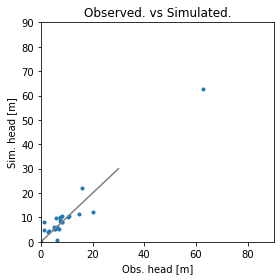

Error is - 3.164722843574287
Params are - [ 3.31538919e+00  4.04291790e+01  1.20382796e-03  2.82385723e+01
  3.24488924e+00 -2.53694259e-03  9.57885259e-04  2.95833548e-01
  9.51661251e-01  9.89612236e-01  2.49293219e-03]


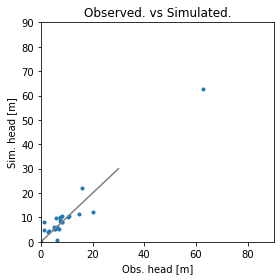

Error is - 3.164722843574287
Params are - [ 3.31903996e+00  4.04470702e+01  1.20444841e-03  2.83512107e+01
  3.25365286e+00 -1.08989719e-02  9.56169115e-04  2.95004099e-01
  9.53334238e-01  9.92390622e-01  2.48688844e-03]


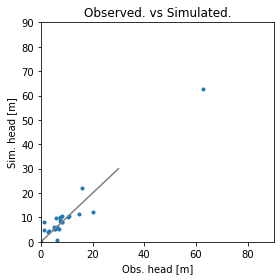

Error is - 3.164722843574287
Params are - [ 3.32365938e+00  4.04186721e+01  1.20413943e-03  2.84235768e+01
  3.24253910e+00 -8.76018392e-03  9.56171494e-04  2.93449587e-01
  9.52622703e-01  9.93627631e-01  2.48305918e-03]


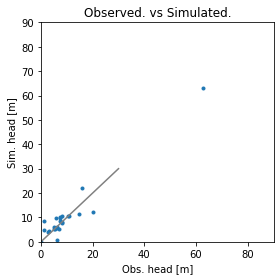

Error is - 3.1648905756708303
Params are - [3.31459165e+00 4.04189315e+01 1.21022943e-03 2.82624310e+01
 3.21340108e+00 5.74877948e-03 9.56504329e-04 2.88142968e-01
 9.48578092e-01 9.94725592e-01 2.51443054e-03]


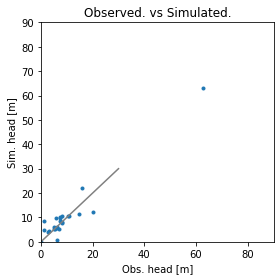

Error is - 3.1648905756708303
Params are - [ 3.32102513e+00  4.04589155e+01  1.20496965e-03  2.83602092e+01
  3.23764180e+00 -6.71989919e-03  9.56869032e-04  2.94144366e-01
  9.52567017e-01  9.93487137e-01  2.48393022e-03]


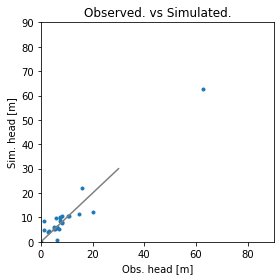

Error is - 3.1640875965924904
Params are - [3.30823279e+00 4.04856175e+01 1.20851997e-03 2.85342233e+01
 3.21130943e+00 3.41639965e-03 9.58218422e-04 2.86412410e-01
 9.51482986e-01 1.00154940e+00 2.49015237e-03]


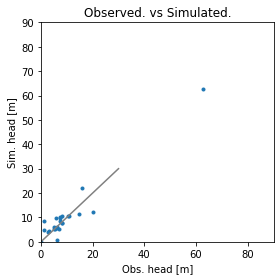

Error is - 3.163707484567764
Params are - [3.29705507e+00 4.05557073e+01 1.21346573e-03 2.88652228e+01
 3.17710390e+00 7.44746909e-03 9.59609553e-04 2.77525706e-01
 9.51621220e-01 1.01431917e+00 2.48346053e-03]


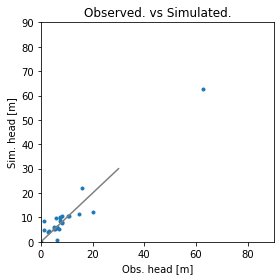

Error is - 3.164080084629499
Params are - [3.31033253e+00 4.04134305e+01 1.20620931e-03 2.84914991e+01
 3.21617320e+00 5.80977303e-03 9.59498827e-04 2.88504810e-01
 9.53304751e-01 9.99073873e-01 2.47310818e-03]


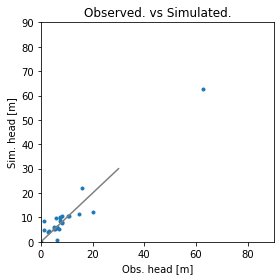

Error is - 3.164080084629499
Params are - [ 3.31054039e+00  4.04891791e+01  1.20978589e-03  2.86236269e+01
  3.21051861e+00 -5.10556286e-03  9.58426556e-04  2.86073598e-01
  9.51764806e-01  1.00435703e+00  2.47594831e-03]


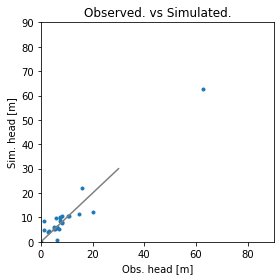

Error is - 3.1640616140560325
Params are - [3.30738916e+00 4.05010953e+01 1.20932288e-03 2.86574766e+01
 3.19891585e+00 2.48881764e-03 9.57340324e-04 2.83183620e-01
 9.51919366e-01 1.00628598e+00 2.48570818e-03]


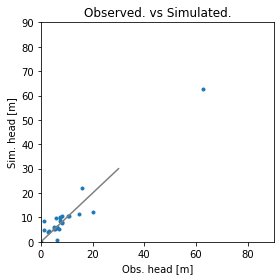

Error is - 3.1640616140560325
Params are - [ 3.31023537e+00  4.05159293e+01  1.21041907e-03  2.87111556e+01
  3.19766365e+00 -3.90965000e-03  9.58842479e-04  2.83130436e-01
  9.52530587e-01  1.00666972e+00  2.47563009e-03]


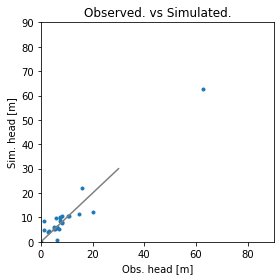

Error is - 3.1640616140560325
Params are - [ 3.31230217e+00  4.04843747e+01  1.21254136e-03  2.88473860e+01
  3.20794766e+00 -1.50229600e-02  9.56939307e-04  2.83658859e-01
  9.53603943e-01  1.01035727e+00  2.48033127e-03]


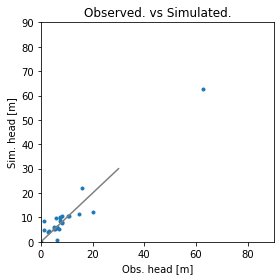

Error is - 3.163792980666408
Params are - [3.30449240e+00 4.04621131e+01 1.21075736e-03 2.86746545e+01
 3.19985894e+00 2.40227905e-03 9.58515548e-04 2.81941881e-01
 9.51577966e-01 1.00670074e+00 2.48847278e-03]


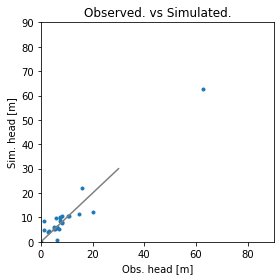

Error is - 3.163792980666408
Params are - [ 3.30908965e+00  4.05099482e+01  1.20559357e-03  2.88473825e+01
  3.22163745e+00 -1.06748542e-02  9.59245927e-04  2.86815809e-01
  9.56112322e-01  1.00763959e+00  2.45325287e-03]


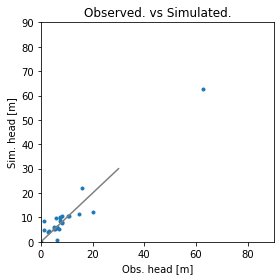

Error is - 3.163457906244558
Params are - [3.29737288e+00 4.05268033e+01 1.21194797e-03 2.87632923e+01
 3.18869913e+00 3.48598728e-03 9.60137749e-04 2.80303048e-01
 9.52702188e-01 1.01128518e+00 2.47920489e-03]


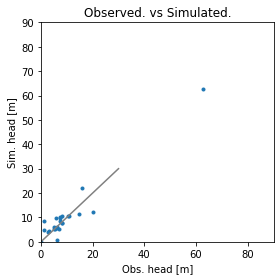

Error is - 3.1634220553434242
Params are - [3.28422963e+00 4.05808690e+01 1.21585224e-03 2.89331500e+01
 3.16177915e+00 9.60907289e-03 9.62120876e-04 2.73729779e-01
 9.52741931e-01 1.02011395e+00 2.47727775e-03]


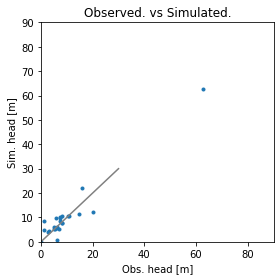

Error is - 3.163586498042701
Params are - [3.29566314e+00 4.05227323e+01 1.21371241e-03 2.89414655e+01
 3.16088106e+00 9.35351072e-03 9.61222267e-04 2.74880478e-01
 9.51882961e-01 1.01756279e+00 2.47362824e-03]


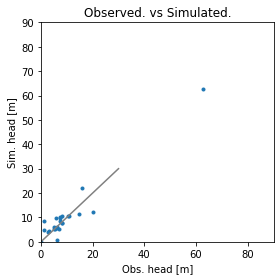

Error is - 3.163106852452844
Params are - [3.29572736e+00 4.05576331e+01 1.21613003e-03 2.91819026e+01
 3.15437047e+00 3.15338198e-03 9.60112851e-04 2.70241379e-01
 9.53596259e-01 1.02542310e+00 2.46407468e-03]


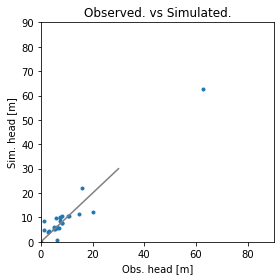

Error is - 3.163081742758473
Params are - [3.28589645e+00 4.06218601e+01 1.22228106e-03 2.96535678e+01
 3.10911108e+00 5.99854426e-03 9.61226647e-04 2.57445295e-01
 9.54563763e-01 1.04332853e+00 2.44964592e-03]


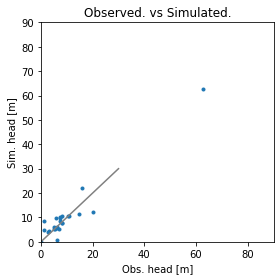

Error is - 3.1626121178580915
Params are - [3.28513863e+00 4.06365010e+01 1.22151650e-03 2.94616049e+01
 3.13138574e+00 5.34104029e-04 9.61497204e-04 2.65467469e-01
 9.53893298e-01 1.03518735e+00 2.45172844e-03]


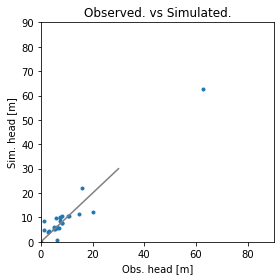

Error is - 3.162371583468811
Params are - [3.26780218e+00 4.07587076e+01 1.23122019e-03 3.00826109e+01
 3.07535416e+00 3.04895372e-04 9.63631834e-04 2.51217641e-01
 9.54911722e-01 1.05797392e+00 2.42923288e-03]


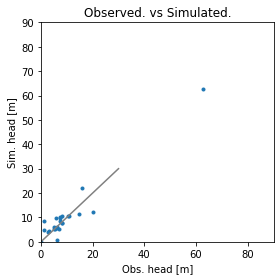

Error is - 3.1632314031186493
Params are - [3.28663920e+00 4.05884150e+01 1.21773687e-03 2.93228406e+01
 3.13974068e+00 7.61590791e-03 9.61245005e-04 2.67023550e-01
 9.54557109e-01 1.03019307e+00 2.46400600e-03]


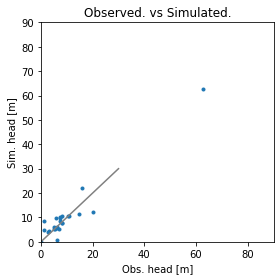

Error is - 3.1632314031186493
Params are - [ 3.28253918e+00  4.06959790e+01  1.22340937e-03  2.96061214e+01
  3.12018927e+00 -2.97103982e-03  9.60490222e-04  2.60686654e-01
  9.53244865e-01  1.04113426e+00  2.46519118e-03]


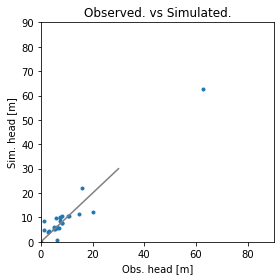

Error is - 3.164171373105709
Params are - [3.27515809e+00 4.06635082e+01 1.21905332e-03 2.93881864e+01
 3.11245874e+00 2.00529515e-02 9.63695362e-04 2.61355841e-01
 9.52880387e-01 1.03544668e+00 2.45521535e-03]


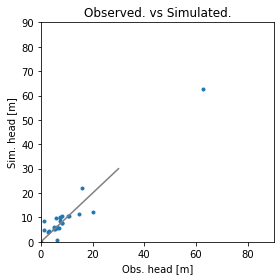

Error is - 3.164171373105709
Params are - [ 3.30301615e+00  4.05291581e+01  1.21416935e-03  2.89825861e+01
  3.18407543e+00 -6.25398216e-03  9.58628321e-04  2.78083104e-01
  9.53423054e-01  1.01662962e+00  2.47405229e-03]


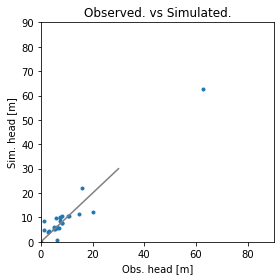

Error is - 3.162703008458139
Params are - [3.27684932e+00 4.06902839e+01 1.22675063e-03 2.98680893e+01
 3.09223262e+00 3.15171982e-03 9.62429241e-04 2.54331468e-01
 9.54737743e-01 1.05065123e+00 2.43943940e-03]


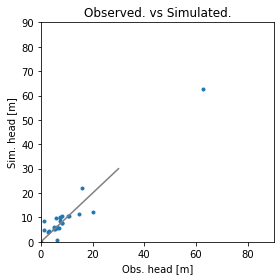

Error is - 3.162741484195262
Params are - [3.27722069e+00 4.06735613e+01 1.22447853e-03 2.97027257e+01
 3.10754742e+00 3.96040164e-03 9.62438420e-04 2.59120595e-01
 9.54734416e-01 1.04408350e+00 2.44661944e-03]


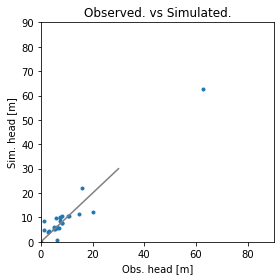

Error is - 3.162741484195262
Params are - [ 3.27517068e+00  4.07273433e+01  1.22731478e-03  2.98443662e+01
  3.09777171e+00 -1.33307223e-03  9.62061028e-04  2.55952148e-01
  9.54078294e-01  1.04955409e+00  2.44721203e-03]


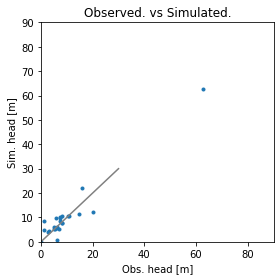

Error is - 3.1627932345326943
Params are - [3.27601590e+00 4.06697883e+01 1.22353621e-03 2.95078805e+01
 3.11856665e+00 4.95698413e-03 9.62876355e-04 2.62473710e-01
 9.53826827e-01 1.03904394e+00 2.45325531e-03]


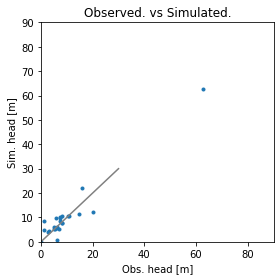

Error is - 3.1628729149565817
Params are - [3.28173266e+00 4.06407199e+01 1.22246630e-03 2.95120382e+01
 3.11811761e+00 4.82920305e-03 9.62427050e-04 2.63049059e-01
 9.53397342e-01 1.03776836e+00 2.45143056e-03]


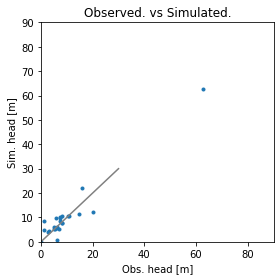

Error is - 3.162870053908266
Params are - [3.28242863e+00 4.06572075e+01 1.22234296e-03 2.94739169e+01
 3.12622903e+00 3.87618223e-03 9.61620693e-04 2.64371674e-01
 9.53266471e-01 1.03614655e+00 2.45634670e-03]


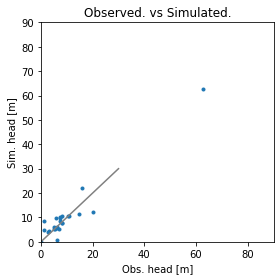

Error is - 3.1627651889326227
Params are - [3.28614729e+00 4.06104103e+01 1.22098878e-03 2.93786327e+01
 3.13760655e+00 1.35358721e-03 9.61073691e-04 2.66579761e-01
 9.53244844e-01 1.03233733e+00 2.45885283e-03]


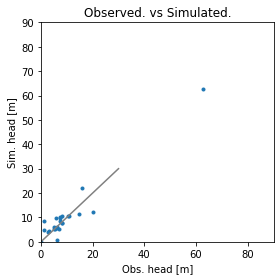

Error is - 3.1627651889326227
Params are - [ 3.28844592e+00  4.06343279e+01  1.21840688e-03  2.94649967e+01
  3.14849580e+00 -5.18497944e-03  9.61438880e-04  2.69016725e-01
  9.55512022e-01  1.03280676e+00  2.44124287e-03]


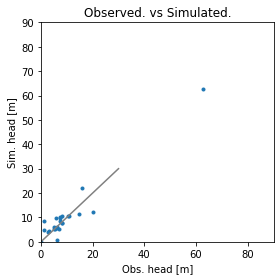

Error is - 3.1628761268751875
Params are - [3.28759567e+00 4.06299015e+01 1.22027153e-03 2.93700437e+01
 3.13713501e+00 1.39685651e-03 9.60486079e-04 2.67200631e-01
 9.53415544e-01 1.03212995e+00 2.45747053e-03]


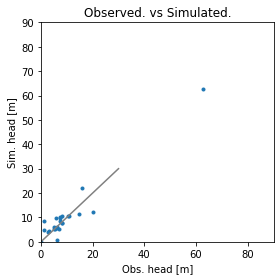

Error is - 3.1628761268751875
Params are - [ 3.28901878e+00  4.06373185e+01  1.22081963e-03  2.93968832e+01
  3.13650890e+00 -1.80237732e-03  9.61237156e-04  2.67174038e-01
  9.53721155e-01  1.03232182e+00  2.45243148e-03]


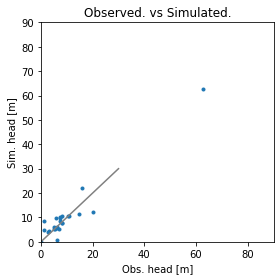

Error is - 3.1628761268751875
Params are - [ 3.29005217e+00  4.06215412e+01  1.22188078e-03  2.94649984e+01
  3.14165091e+00 -7.35903233e-03  9.60285570e-04  2.67438250e-01
  9.54257833e-01  1.03416560e+00  2.45478207e-03]


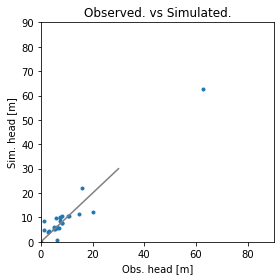

Error is - 3.163264026721525
Params are - [3.27148014e+00 4.07111079e+01 1.22513676e-03 2.97353986e+01
 3.09390645e+00 1.01789234e-02 9.63663598e-04 2.56286741e-01
 9.53896055e-01 1.04671030e+00 2.44222411e-03]


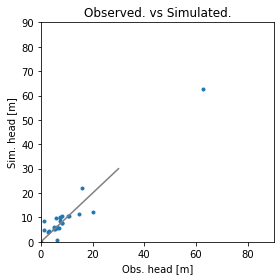

Error is - 3.163264026721525
Params are - [ 3.28540916e+00  4.06439329e+01  1.22269477e-03  2.95325985e+01
  3.12971479e+00 -2.97454339e-03  9.61130077e-04  2.64650373e-01
  9.54167388e-01  1.03730177e+00  2.45164258e-03]


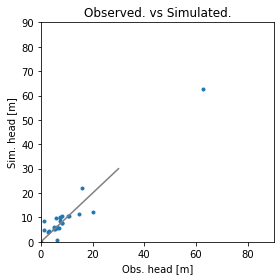

Error is - 3.1625302296285556
Params are - [3.27232575e+00 4.07244958e+01 1.22898541e-03 2.99753501e+01
 3.08379339e+00 1.72830759e-03 9.63030537e-04 2.52774555e-01
 9.54824733e-01 1.05431257e+00 2.43433614e-03]


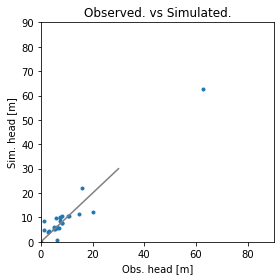

Error is - 3.1625400632539327
Params are - [3.27251144e+00 4.07161345e+01 1.22784936e-03 2.98926683e+01
 3.09145079e+00 2.13264851e-03 9.63035127e-04 2.55169118e-01
 9.54823069e-01 1.05102871e+00 2.43792616e-03]


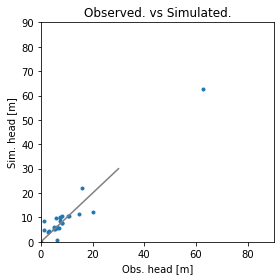

Error is - 3.1625400632539327
Params are - [ 3.27148643e+00  4.07430255e+01  1.22926749e-03  2.99634885e+01
  3.08656294e+00 -5.14088427e-04  9.62846431e-04  2.53584894e-01
  9.54495008e-01  1.05376401e+00  2.43822245e-03]


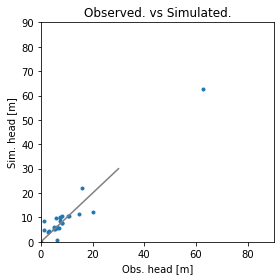

Error is - 3.1624916210729435
Params are - [3.27697473e+00 4.06845590e+01 1.22610449e-03 2.97306218e+01
 3.10648035e+00 8.29241291e-04 9.62352762e-04 2.58898701e-01
 9.54078283e-01 1.04515563e+00 2.44404285e-03]


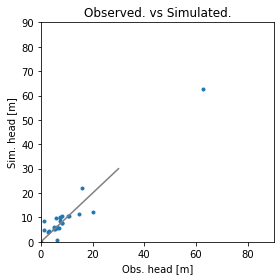

Error is - 3.1624916210729435
Params are - [ 3.27812405e+00  4.06965178e+01  1.22481354e-03  2.97738038e+01
  3.11192498e+00 -2.44004203e-03  9.62535357e-04  2.60117183e-01
  9.55211872e-01  1.04539034e+00  2.43523788e-03]


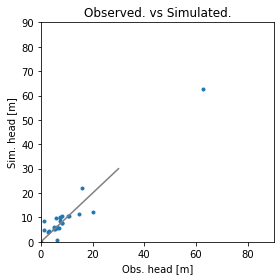

Error is - 3.1625548923344264
Params are - [3.27190904e+00 4.07142480e+01 1.22737820e-03 2.97952457e+01
 3.09696040e+00 2.63093975e-03 9.63254095e-04 2.56845675e-01
 9.54369275e-01 1.04850893e+00 2.44124410e-03]


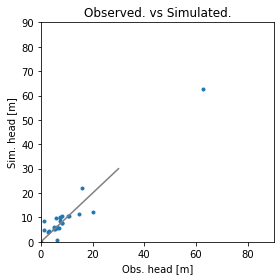

Error is - 3.162577934529583
Params are - [3.27511540e+00 4.07079576e+01 1.22678158e-03 2.97782639e+01
 3.10079159e+00 2.09053880e-03 9.62626264e-04 2.57794657e-01
 9.54089097e-01 1.04706024e+00 2.44278979e-03]


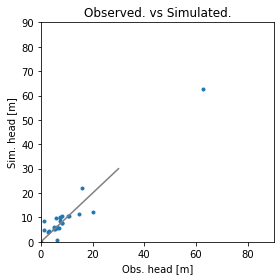

Error is - 3.162594235646161
Params are - [3.27476742e+00 4.06997138e+01 1.22684325e-03 2.97973245e+01
 3.09673588e+00 2.56704921e-03 9.63029442e-04 2.57133350e-01
 9.54154532e-01 1.04787114e+00 2.44033172e-03]


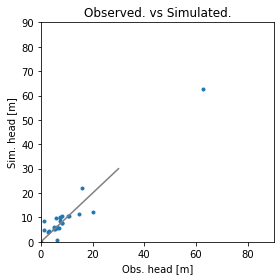

Error is - 3.162541519993266
Params are - [3.27769892e+00 4.06943046e+01 1.22574586e-03 2.97263273e+01
 3.10624458e+00 8.50875938e-04 9.62058957e-04 2.59209136e-01
 9.54163633e-01 1.04505194e+00 2.44335170e-03]


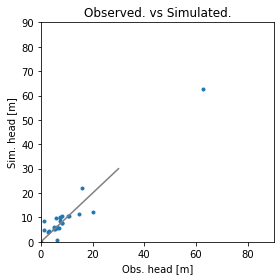

Error is - 3.162541519993266
Params are - [ 3.27841048e+00  4.06980131e+01  1.22601991e-03  2.97397471e+01
  3.10593153e+00 -7.48740972e-04  9.62434495e-04  2.59195840e-01
  9.54316439e-01  1.04514787e+00  2.44083218e-03]


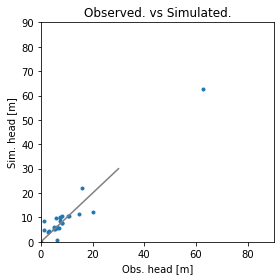

Error is - 3.162541519993266
Params are - [ 3.27892718e+00  4.06901244e+01  1.22655048e-03  2.97738047e+01
  3.10850253e+00 -3.52706848e-03  9.61958702e-04  2.59327946e-01
  9.54584778e-01  1.04606976e+00  2.44200748e-03]


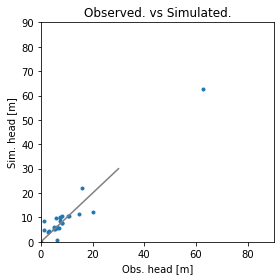

Error is - 3.162541519993266
Params are - [ 3.27455723e+00  4.07235749e+01  1.22783248e-03  2.98812086e+01
  3.09853634e+00 -1.96022969e-03  9.62382296e-04  2.56345804e-01
  9.54912361e-01  1.05021321e+00  2.43770894e-03]


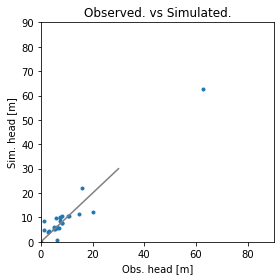

Error is - 3.162541519993266
Params are - [ 3.27410777e+00  4.07181706e+01  1.22808523e-03  2.99189864e+01
  3.09407059e+00 -2.22022265e-03  9.62741117e-04  2.55421069e-01
  9.55127480e-01  1.05159738e+00  2.43432707e-03]


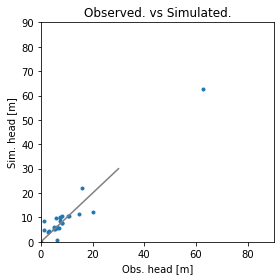

Error is - 3.162541519993266
Params are - [ 3.27771390e+00  4.07125934e+01  1.22761715e-03  2.99245030e+01
  3.09737635e+00 -3.64265312e-03  9.62020017e-04  2.56111031e-01
  9.54985158e-01  1.05071022e+00  2.43461513e-03]


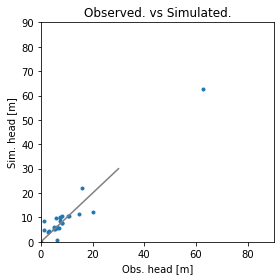

Error is - 3.162541519993266
Params are - [ 3.27626268e+00  4.07130071e+01  1.22755741e-03  2.98921886e+01
  3.09727237e+00 -2.07425490e-03  9.62328537e-04  2.56294692e-01
  9.54831187e-01  1.05015990e+00  2.43627237e-03]


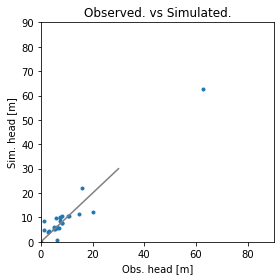

Error is - 3.1624433690464664
Params are - [3.27336026e+00 4.07138343e+01 1.22743794e-03 2.98275600e+01
 3.09706439e+00 1.06254153e-03 9.62945575e-04 2.56662014e-01
 9.54523245e-01 1.04905925e+00 2.43958685e-03]


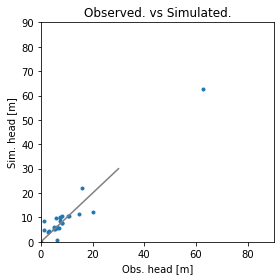

Error is - 3.162558493269615
Params are - [3.27537926e+00 4.07078823e+01 1.22679244e-03 2.97841392e+01
 3.10081050e+00 1.80537549e-03 9.62570169e-04 2.57761265e-01
 9.54117092e-01 1.04716029e+00 2.44248847e-03]


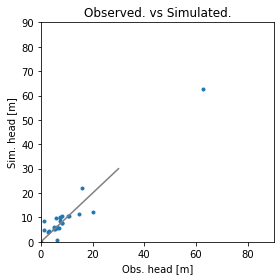

Error is - 3.162558493269615
Params are - [ 3.27442564e+00  4.07155986e+01  1.22776203e-03  2.98852746e+01
  3.09575557e+00 -1.21382311e-03  9.62698380e-04  2.56006118e-01
  9.54874883e-01  1.05048811e+00  2.43636742e-03]


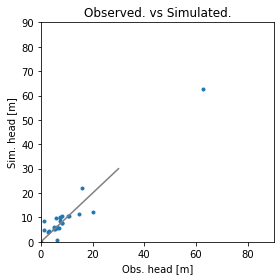

Error is - 3.162398590049538
Params are - [3.27058122e+00 4.07362710e+01 1.22932907e-03 2.99550854e+01
 3.08620928e+00 6.83718452e-04 9.63288705e-04 2.53939828e-01
 9.54717484e-01 1.05351659e+00 2.43440987e-03]


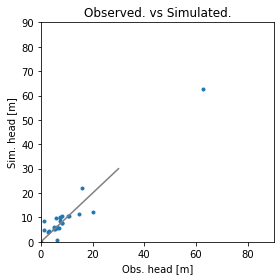

Error is - 3.1624125607906883
Params are - [3.27238846e+00 4.07216333e+01 1.22866234e-03 2.99066163e+01
 3.09091726e+00 5.67068331e-04 9.62992298e-04 2.55058171e-01
 9.54495003e-01 1.05156478e+00 2.43663787e-03]


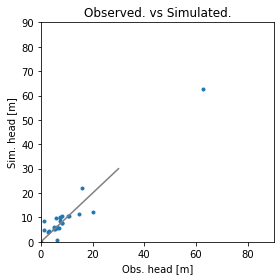

Error is - 3.1624125607906883
Params are - [ 3.27296311e+00  4.07276127e+01  1.22801687e-03  2.99282073e+01
  3.09363957e+00 -1.06757333e-03  9.63083596e-04  2.55667412e-01
  9.55061797e-01  1.05168213e+00  2.43223538e-03]


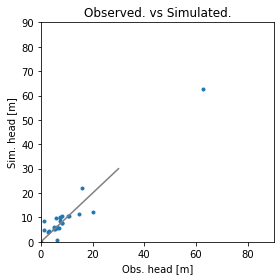

Error is - 3.1624486889908896
Params are - [3.27006396e+00 4.07416017e+01 1.23010280e-03 3.00289805e+01
 3.07957377e+00 1.01660148e-03 9.63331186e-04 2.51996098e-01
 9.54868228e-01 1.05614325e+00 2.43178451e-03]


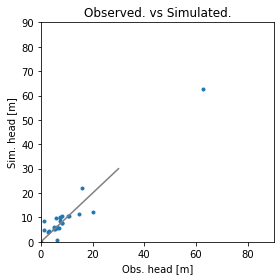

Error is - 3.1624509915037278
Params are - [3.27015681e+00 4.07374211e+01 1.22953478e-03 2.99876396e+01
 3.08340247e+00 1.21877194e-03 9.63333480e-04 2.53193380e-01
 9.54867396e-01 1.05450132e+00 2.43357952e-03]


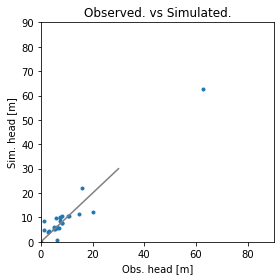

Error is - 3.1624509915037278
Params are - [ 3.26964431e+00  4.07508665e+01  1.23024384e-03  3.00230497e+01
  3.08095855e+00 -1.04596527e-04  9.63239133e-04  2.52401268e-01
  9.54703365e-01  1.05586897e+00  2.43372767e-03]


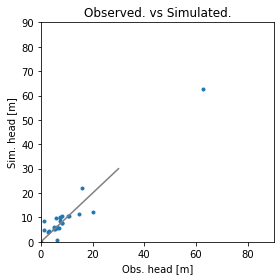

Error is - 3.1624361853036307
Params are - [3.27275055e+00 4.07265061e+01 1.22848303e-03 2.99044691e+01
 3.09079937e+00 5.77885655e-04 9.62845395e-04 2.55213388e-01
 9.54537678e-01 1.05151293e+00 2.43629229e-03]


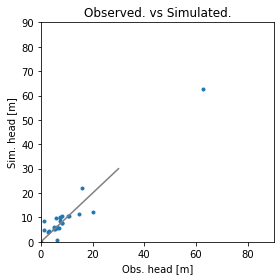

Error is - 3.1624361853036307
Params are - [ 3.27310633e+00  4.07283603e+01  1.22862005e-03  2.99111790e+01
  3.09064284e+00 -2.21922800e-04  9.63033165e-04  2.55206740e-01
  9.54614081e-01  1.05156090e+00  2.43503253e-03]


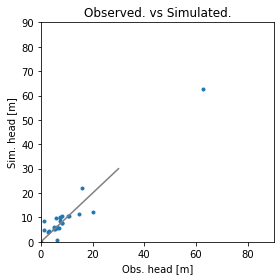

Error is - 3.1624361853036307
Params are - [ 3.27336468e+00  4.07244160e+01  1.22888534e-03  2.99282078e+01
  3.09192834e+00 -1.61108655e-03  9.62795268e-04  2.55272793e-01
  9.54748250e-01  1.05202184e+00  2.43562018e-03]


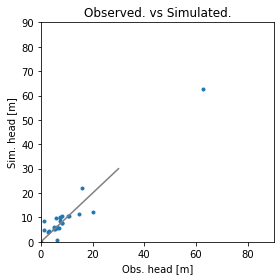

Error is - 3.1624361853036307
Params are - [ 3.27117971e+00  4.07411413e+01  1.22952634e-03  2.99819097e+01
  3.08694525e+00 -8.27667160e-04  9.63007065e-04  2.53781722e-01
  9.54912041e-01  1.05409357e+00  2.43347091e-03]


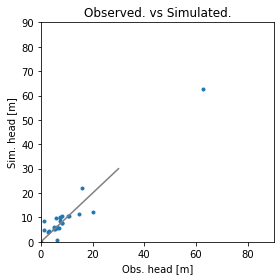

Error is - 3.1624361853036307
Params are - [ 3.27095497e+00  4.07384391e+01  1.22965271e-03  3.00007987e+01
  3.08471237e+00 -9.57663637e-04  9.63186476e-04  2.53319355e-01
  9.55019601e-01  1.05478565e+00  2.43177998e-03]


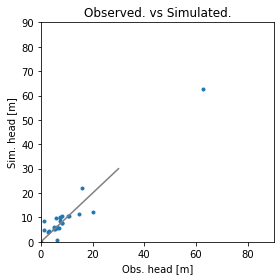

Error is - 3.162346002062064
Params are - [3.27313969e+00 4.07186080e+01 1.22830771e-03 2.99070784e+01
 3.09251867e+00 4.69652095e-05 9.63038771e-04 2.55574465e-01
 9.54888140e-01 1.05128683e+00 2.43355886e-03]


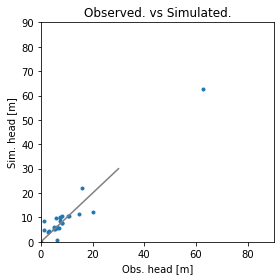

Error is - 3.162346579394676
Params are - [3.27488738e+00 4.07024788e+01 1.22733964e-03 2.98490927e+01
 3.09829873e+00 1.22746078e-04 9.62938590e-04 2.57161063e-01
 9.54980528e-01 1.04899576e+00 2.43347446e-03]


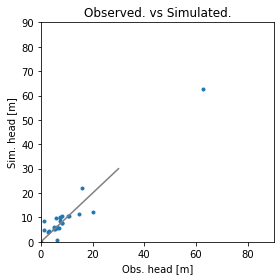

Error is - 3.162346579394676
Params are - [ 3.27316953e+00  4.07286330e+01  1.22879367e-03  2.99278410e+01
  3.09173223e+00 -1.48945903e-03  9.62890839e-04  2.55215277e-01
  9.54727882e-01  1.05207003e+00  2.43370325e-03]


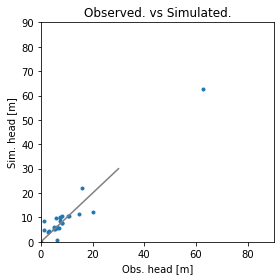

Error is - 3.162346579394676
Params are - [ 3.27382702e+00  4.07220944e+01  1.22798762e-03  2.98681111e+01
  3.09777156e+00 -1.74293594e-03  9.62813071e-04  2.56997865e-01
  9.54701532e-01  1.04968751e+00  2.43584712e-03]


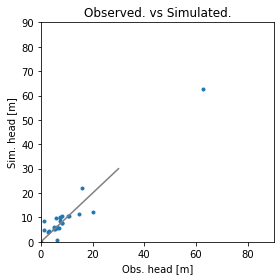

Error is - 3.162372806015184
Params are - [3.27345821e+00 4.07222852e+01 1.22813496e-03 2.98721679e+01
 3.09500736e+00 8.85524034e-05 9.62889889e-04 2.56343428e-01
 9.54492328e-01 1.05011817e+00 2.43659114e-03]


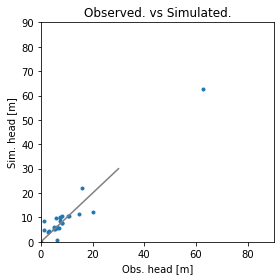

Error is - 3.1623648299425033
Params are - [3.27364774e+00 4.07161547e+01 1.22800836e-03 2.98711038e+01
 3.09424032e+00 1.25141302e-04 9.63047995e-04 2.56346825e-01
 9.54523576e-01 1.05008746e+00 2.43546752e-03]


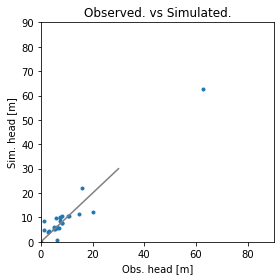

Error is - 3.1624382013951315
Params are - [3.27151424e+00 4.07313779e+01 1.22848991e-03 2.99144232e+01
 3.08967759e+00 1.22423849e-03 9.63305742e-04 2.55051032e-01
 9.54646518e-01 1.05180747e+00 2.43329050e-03]


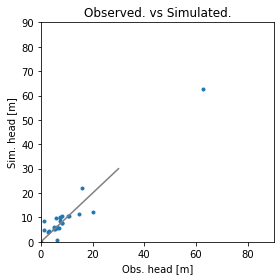

Error is - 3.1624382013951315
Params are - [ 3.27290207e+00  4.07261565e+01  1.22878648e-03  2.99247616e+01
  3.09136566e+00 -9.02255293e-04  9.62922887e-04  2.55217353e-01
  9.54722817e-01  1.05196825e+00  2.43503776e-03]


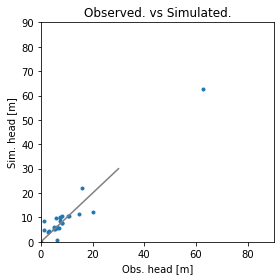

Error is - 3.1624382013951315
Params are - [ 3.27315461e+00  4.07236205e+01  1.22855069e-03  2.99174597e+01
  3.09212545e+00 -7.21246908e-04  9.62964805e-04  2.55394871e-01
  9.54808011e-01  1.05167843e+00  2.43363106e-03]


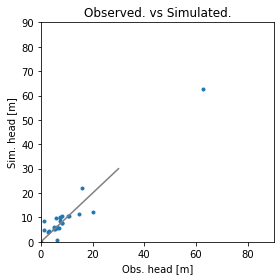

Error is - 3.1624382013951315
Params are - [ 3.27348336e+00  4.07203512e+01  1.22814766e-03  2.98875947e+01
  3.09514512e+00 -8.47985363e-04  9.62925921e-04  2.56286165e-01
  9.54794836e-01  1.05048717e+00  2.43470299e-03]


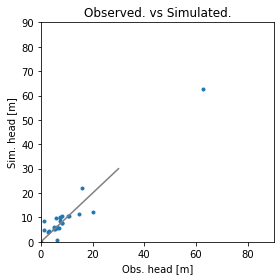

Error is - 3.1623553119367305
Params are - [3.27339372e+00 4.07173814e+01 1.22815803e-03 2.98890911e+01
 3.09337949e+00 8.60532557e-05 9.63043383e-04 2.55960645e-01
 9.54705858e-01 1.05068714e+00 2.43451319e-03]


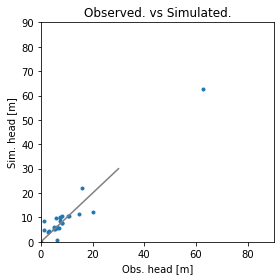

Error is - 3.162352461386236
Params are - [3.27047094e+00 4.07386578e+01 1.22976395e-03 2.99948446e+01
 3.08393641e+00 1.75930291e-04 9.63335302e-04 2.53396053e-01
 9.54899931e-01 1.05463038e+00 2.43139587e-03]


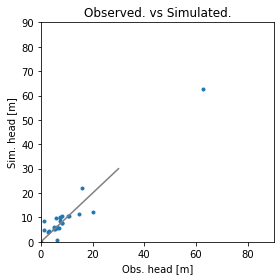

Error is - 3.1623592213608003
Params are - [3.27329895e+00 4.07204466e+01 1.22822134e-03 2.98896231e+01
 3.09376301e+00 6.77588065e-05 9.62964330e-04 2.55958946e-01
 9.54690234e-01 1.05070250e+00 2.43507500e-03]


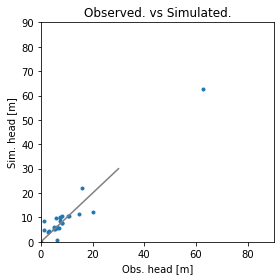

Error is - 3.162370519492456
Params are - [3.27186045e+00 4.07274395e+01 1.22881839e-03 2.99310819e+01
 3.08936397e+00 3.65341831e-04 9.63163738e-04 2.54757146e-01
 9.54802812e-01 1.05240171e+00 2.43398436e-03]


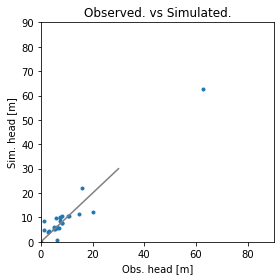

Error is - 3.16237845467938
Params are - [3.27276407e+00 4.07201207e+01 1.22848502e-03 2.99068474e+01
 3.09171796e+00 3.07016770e-04 9.63015535e-04 2.55316318e-01
 9.54691572e-01 1.05142580e+00 2.43509836e-03]


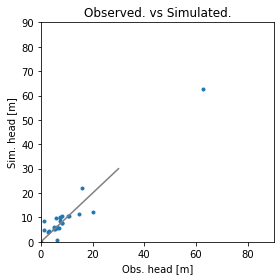

Error is - 3.16237845467938
Params are - [ 3.27305140e+00  4.07231104e+01  1.22816229e-03  2.99176429e+01
  3.09307912e+00 -5.10304060e-04  9.63061183e-04  2.55620938e-01
  9.54974969e-01  1.05148448e+00  2.43289712e-03]


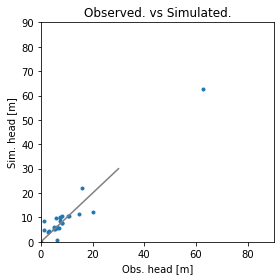

Error is - 3.1623901609908347
Params are - [3.27294512e+00 4.07225571e+01 1.22839537e-03 2.99057737e+01
 3.09165902e+00 3.12425432e-04 9.62942083e-04 2.55393927e-01
 9.54712909e-01 1.05139988e+00 2.43492558e-03]


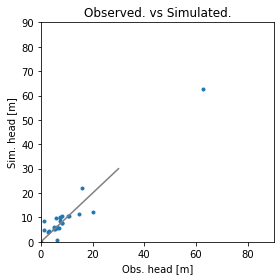

Error is - 3.1623901609908347
Params are - [ 3.27312301e+00  4.07234842e+01  1.22846388e-03  2.99091287e+01
  3.09158076e+00 -8.74787952e-05  9.63035968e-04  2.55390603e-01
  9.54751110e-01  1.05142386e+00  2.43429570e-03]


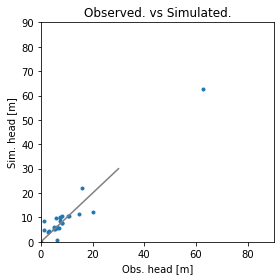

Error is - 3.1623901609908347
Params are - [ 3.27325218e+00  4.07215120e+01  1.22859652e-03  2.99176431e+01
  3.09222351e+00 -7.82060672e-04  9.62917019e-04  2.55423629e-01
  9.54818195e-01  1.05165434e+00  2.43458952e-03]


In [32]:
# run optimization 

"""             {-12:Alluvium_Aua, 
               -14:Alluvium_Fagaalu, 
               -15:Alluvium_minor,
               -13:Alluvium_Utulei,
               -11:Alluvium_Vaipito,
               -10:Alluvium_Vatia,
               -50:Dikes,
               -30:Pago_inner_E,
               -40:Pago_inner_W,
               -20:Pago_outer,
               -60:Trachyte}   """

# Start
# params = [4.6, 13.0, 0.1, 5.0, 2.6, 0.4, 0.3, 0.1, 0.5, 0.6, 0.3]
# Better
# params = [2.1, 28.6, 0.05, 7.2, 1.8, 0.7, 0.01, 0.15, 0.4, 1.5, 0.01]
# Better
 params = [2.6, 39, 0.001, 14, 3.7, 1.2, 0.001, 0.37, 0.9, 0.7, 0.003]

# The main optimization function
results = opt.minimize(calibrateo, x0= params, method="Nelder-Mead",tol = 0.1)

In [26]:
calibrateo(results["x"])


Error is - 3.2446989745873096
Params are - [2.66734909e+00 3.88938662e+01 1.35015054e-03 1.44380768e+01
 3.70378031e+00 1.11188899e+00 9.53875900e-04 3.65098285e-01
 8.97305579e-01 7.23140076e-01 3.12300993e-03]


3.2446989745873096

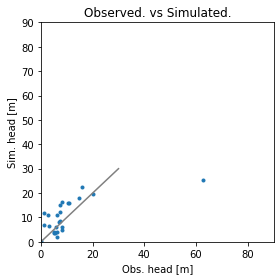

In [30]:
plot_calibrateo(Howd_we_do)